# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:,.4f}'.format) 
# pd.options.display.
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from tqdm import tqdm
from itertools import combinations, permutations
import copy
import re
import math
import scipy.stats as ss
import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.utils import parallel_backend
from scipy.stats import randint, uniform, loguniform
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
import sklearn
sklearn.set_config(display='diagram')

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score


import copy
from collections import Counter
import os
import time
from datetime import datetime
from joblib import dump, load
from tempfile import mkdtemp
from shutil import rmtree

import shap

import networkx as nx
from networkx.exception import NetworkXNoPath
from node2vec import Node2Vec
import os
import re
from datetime import datetime
from gensim.models import Word2Vec

# Import functions

## custom_division()

In [ ]:
def custom_division(numerator, denominator, default_value = np.nan): # default value for ZeroDivisionError, SUM should be $0 if there are no transactions
  # = numerator / denominator
  # = 0 if both = 0
  # = default_value if only denominator = 0 (ZeroDivisionError)
  return np.where((numerator == 0) & (denominator == 0), 0, np.where(denominator == 0, default_value, numerator / denominator))

# Import custom transformers

## ManualTransformer()

In [ ]:
# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class ManualTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    # flag variables for missingness (red flag if a person can open an account without providing a name)
    output['MISSING_NAME'] = output.NAME.isna().astype(int).astype('category')
    # let's not have these as we will take a look at missingness
    # output['MISSING_GENDER'] = output.GENDER.isna().astype(int).astype('category')
    # output['MISSING_CUST_ADD_DT'] = output.CUST_ADD_DT.isna().astype(int).astype('category')
    # output['MISSING_occupation_risk'] = output.occupation_risk.isna().astype(int).astype('category')

    output['DIFF_CNTRY'] = (output['RES_CNTRY_CA'] != output['CNTRY_OF_INCOME_CA']).astype(int).astype('category')

    today = pd.Timestamp('2023-01-01')
    # Age = Today - BIRTH_DT (does not take leap years into account)
    output['AGE'] = (today - output.BIRTH_DT).dt.days / 365.25
    # Days since customer joined = Today - CUST_ADD_DT
    output['HIST_JOIN'] = (today - output.CUST_ADD_DT).dt.days / 365.25
    
    # $ Average transaction amt = SUM / CNT for both incoming and outgoing cash flows
    output['WIRES_AVG_IN'] = custom_division(output.WIRES_SUM_IN, 
                                             output.WIRES_CNT_IN, 
                                             default_value=999_999_999)
    output['WIRES_AVG_OUT'] = custom_division(output.WIRES_SUM_OUT, 
                                              output.WIRES_CNT_OUT, 
                                              default_value=999_999_999)
    output['CASH_AVG_IN'] = custom_division(output.CASH_SUM_IN, 
                                            output.CASH_CNT_IN, 
                                            default_value=999_999_999)
    output['CASH_AVG_OUT'] = custom_division(output.CASH_SUM_OUT, 
                                             output.CASH_CNT_OUT, 
                                             default_value=999_999_999)
    
    
    # Remove rows with invalid data entry (CNT == 0 while SUM != 0)
    EntryError_df = output.loc[(output == 999_999_999).any(axis=1), [x for x in output.columns if ('_SUM_' in x) | ('_CNT_' in x) | (x == 'RISK')]]
    # add dummy variable to indicate data entry error
    output['DATA_ENTRY_ERROR'] = 0
    output.loc[output.index.isin(EntryError_df.index), 'DATA_ENTRY_ERROR'] = 1
    output['DATA_ENTRY_ERROR'] = output['DATA_ENTRY_ERROR'].astype(int).astype('category')
    # replace 999_999_999 with 0
    output.replace(999_999_999, 0, inplace=True)

    # helper columns for ease of calculation to be dropped later
    output['TOTAL_SUM'] = (output.WIRES_SUM_IN + output.WIRES_SUM_OUT + output.CASH_SUM_IN + output.CASH_SUM_OUT)
    output['TOTAL_IN_SUM'] = (output.WIRES_SUM_IN + output.CASH_SUM_IN)
    output['TOTAL_OUT_SUM'] = (output.WIRES_SUM_OUT + output.CASH_SUM_OUT)
    output['TOTAL_WIRES_SUM'] = (output.WIRES_SUM_IN + output.WIRES_SUM_OUT)
    output['TOTAL_CASH_SUM'] = (output.CASH_SUM_IN + output.CASH_SUM_OUT)

    output['TOTAL_CNT'] = (output.WIRES_CNT_IN + output.WIRES_CNT_OUT + output.CASH_CNT_IN + output.CASH_CNT_OUT)
    output['TOTAL_IN_CNT'] = (output.WIRES_CNT_IN + output.CASH_CNT_IN)
    output['TOTAL_OUT_CNT'] = (output.WIRES_CNT_OUT + output.CASH_CNT_OUT)
    output['TOTAL_WIRES_CNT'] = (output.WIRES_CNT_IN + output.WIRES_CNT_OUT)
    output['TOTAL_CASH_CNT'] = (output.CASH_CNT_IN + output.CASH_CNT_OUT)

    output['TOTAL_AVG'] = custom_division(output.TOTAL_SUM, output.TOTAL_CNT, 0)
    output['TOTAL_IN_AVG'] = custom_division(output.TOTAL_IN_SUM, output.TOTAL_IN_CNT, 0)
    output['TOTAL_OUT_AVG'] = custom_division(output.TOTAL_OUT_SUM, output.TOTAL_OUT_CNT, 0)
    output['TOTAL_WIRES_AVG'] = custom_division(output.TOTAL_WIRES_SUM, output.TOTAL_WIRES_CNT, 0)
    output['TOTAL_CASH_AVG'] = custom_division(output.TOTAL_CASH_SUM, output.TOTAL_CASH_CNT, 0)
    

    # WIRES_AVG >> CASH_AVG
    output['WIRES_VS_CASH_AVG'] = custom_division(output.TOTAL_WIRES_AVG, output.TOTAL_CASH_AVG, 0) #output.TOTAL_AVG)
    # ratio of IN_AVG vs OUT_AVG for WIRES and CASH
    output['IN_VS_OUT_WIRES_AVG'] = custom_division(output.WIRES_AVG_IN, output.WIRES_AVG_OUT, 0) #output.TOTAL_WIRES_AVG)
    output['IN_VS_OUT_CASH_AVG'] = custom_division(output.CASH_AVG_IN, output.CASH_AVG_OUT, 0) #output.TOTAL_CASH_AVG)

    # don't compare WIRES_AVG with CASH_AVG as WIRES_AVG >> CASH_AVG
    # output['WIRES_IN_pct_AVG'] = custom_division(output.WIRES_AVG_IN, output.TOTAL_AVG)
    # output['WIRES_OUT_pct_AVG'] = custom_division(output.WIRES_AVG_OUT, output.TOTAL_AVG) 
    # output['CASH_IN_pct_AVG'] = custom_division(output.CASH_AVG_IN, output.TOTAL_AVG)
    # output['WIRES_pct_IN_AVG'] = custom_division(output.WIRES_AVG_IN, output.TOTAL_IN_AVG)
    # output['WIRES_pct_OUT_AVG'] = custom_division(output.WIRES_AVG_OUT, output.TOTAL_OUT_AVG)
      

    # WIRES_CNT contribute for a majority % of TOTAL_CNT
    output['WIRES_pct_CNT'] = custom_division(output.TOTAL_WIRES_CNT, output.TOTAL_CNT)
    # % of TOTAL_WIRES_CNT and TOTAL_CASH_CNT
    output['IN_pct_WIRES_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_WIRES_CNT)
    output['IN_pct_CASH_CNT'] = custom_division(output.CASH_CNT_IN, output.TOTAL_CASH_CNT)

    # don't compare WIRES_CNT with CASH_CNT as WIRES_CNT >> CASH_CNT
    # output['WIRES_IN_pct_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_CNT)
    # output['WIRES_OUT_pct_CNT'] = custom_division(output.WIRES_CNT_OUT, output.TOTAL_CNT)
    # output['CASH_IN_pct_CNT'] = custom_division(output.CASH_CNT_IN, output.TOTAL_CNT)
    # output['WIRES_pct_IN_CNT'] = custom_division(output.WIRES_CNT_IN, output.TOTAL_IN_CNT)
    # output['WIRES_pct_OUT_CNT'] = custom_division(output.WIRES_CNT_OUT, output.TOTAL_OUT_CNT) # similar to WIRES_pct_CNT
    


    # ratio of CNT VS AVG
    output['WIRES_IN_CNT_VS_AVG'] = custom_division(output.WIRES_CNT_IN, output.WIRES_AVG_IN)
    output['WIRES_OUT_CNT_VS_AVG'] = custom_division(output.WIRES_CNT_OUT, output.WIRES_AVG_OUT)
    output['CASH_IN_CNT_VS_AVG'] = custom_division(output.CASH_CNT_IN, output.CASH_AVG_IN)
    output['CASH_OUT_CNT_VS_AVG'] = custom_division(output.CASH_CNT_OUT, output.CASH_AVG_OUT)

    # change in balance within last 12 months due to cash and wires transactions
    output["CASH_BALANCE"] = output["CASH_SUM_IN"] - output["CASH_SUM_OUT"]
    output["WIRES_BALANCE"] = output["WIRES_SUM_IN"] - output["WIRES_SUM_OUT"]

    
    output.drop(columns = [
        # drop BIRTH_DT, CUST_ADD_DT
        'NAME', 'BIRTH_DT', 'CUST_ADD_DT',
        # drop helper TOTAL columns (only created for ease of calculation)
        # keep TOTAL_SUM for sample_weights
        'TOTAL_IN_SUM', 'TOTAL_OUT_SUM', 'TOTAL_WIRES_SUM', 'TOTAL_CASH_SUM',
        'TOTAL_CNT', 'TOTAL_IN_CNT', 'TOTAL_OUT_CNT', 'TOTAL_WIRES_CNT', 'TOTAL_CASH_CNT',
        # drop SUM 
        'WIRES_SUM_IN', 'WIRES_SUM_OUT', 'CASH_SUM_IN', 'CASH_SUM_OUT',
        # drop AVG: similar to WIRES_AVG_IN, WIRES_AVG_OUT, CASH_AVG_IN, CASH_AVG_OUT
        'TOTAL_AVG', 'TOTAL_WIRES_AVG', 'TOTAL_CASH_AVG', 'TOTAL_IN_AVG', 'TOTAL_OUT_AVG'
        ], inplace = True)

    
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

## OutlierRemoval()

In [ ]:
# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class OutlierRemoval(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)
    output = output.loc[~(output.AGE >= 118)] # remove customers with AGE >= 118 years old
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

## MyMinMaxScaler(), MyQuantileTransformer(), ThermometerEncoder(), MyOneHotEncoder(), RandomImputer(), MySimpleImputer()

In [ ]:
# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self, feature_range = (0,1)):
    self.feature_range = feature_range
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler(feature_range = self.feature_range).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class MyPowerTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, random_state=42):
    self.random_state=42
  
  def fit(self, X, y = None):
    self.PowerTransformer_ = PowerTransformer().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.PowerTransformer_.transform(output),
                          columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state, n_quantiles = 1000):
    self.output_distribution = output_distribution
    self.random_state = random_state
    self.n_quantiles = n_quantiles
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(self.n_quantiles, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class ThermometerEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    output_final = pd.DataFrame()

    for col in output.columns:
      
      temp = []
      for code in sorted(output[col].cat.codes.unique())[:-1]:
        temp.append((output[col].cat.codes > code).astype(int))
      temp = pd.DataFrame(np.array(temp).T)
      # temp = output[col].cat.codes.apply(lambda x: ','.join(np.ones(x+1).astype(int).astype(str))).str.split(',', expand=True).astype(float).fillna(0).astype(int)
      temp.columns = [col + '_' + str(x) for x in output[col].cat.categories.unique()[1:]]
      output_final = pd.concat([output_final, temp], axis = 1)

    self.output_names = output_final.columns
    return output_final
  
  def get_feature_names_out(self, names = None):
    return self.output_names

class MyOneHotEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, drop = None, sparse = True):
    self.drop = drop
    self.sparse = sparse
  
  def fit(self, X, y = None):
    self.OneHotEncoder_ = OneHotEncoder(drop = self.drop, sparse = self.sparse).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.OneHotEncoder_.transform(output),
                          columns = self.OneHotEncoder_.get_feature_names_out())
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class RandomImputer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    
    output = copy.deepcopy(X)

    for na_col in ['GENDER', 'HIST_JOIN', 'occupation_risk']:
      if na_col in output.columns:
        if na_col == 'GENDER':
          try:
            # sample GENDER within MISSING_NAME == 1
            output.loc[output[na_col].isna(), na_col] = output.loc[(output[na_col].notnull()) & (output.MISSING_NAME == 1), na_col].sample(output[na_col].isna().sum(), random_state = 42, replace = True).to_numpy()
          except ValueError:
            # pass if there is no missing
            pass
        else:
          try:
            # sample HIST_JOIN and occupation_risk randomly
            output.loc[output[na_col].isna(), na_col] = output.loc[output[na_col].notnull(), na_col].sample(output[na_col].isna().sum(), random_state = 42, replace = True).to_numpy()
          except ValueError:
            # pass if there is no missing
            pass

    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class MySimpleImputer(BaseEstimator, TransformerMixin):
  def __init__(self, strategy = 'mean', random_state=42):
    self.random_state=42
    self.strategy = strategy
  
  def fit(self, X, y = None):
    self.SimpleImputer_ = SimpleImputer(strategy=self.strategy).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    if self.strategy == 'most_frequent':
      output = pd.DataFrame(self.SimpleImputer_.transform(output),
                            columns = output.columns).astype('category')
    else:
      output = pd.DataFrame(self.SimpleImputer_.transform(output),
                            columns = output.columns)
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# Import files

## UofT_nodes (customer features)

- BIRTH_DT (Date): date of birth
- CUST_ADD_DT (Date): date of joining the bank
- OCPTN_NM (int): occupation code -> occupation risk
- RES_CNTRY_CA (Bool): whether customer lives in Canada
- CNTRY_OF_INCOME_CA (Bool): whether customer receives income in Canada
- PEP_FL (Bool): whether person is PEP
- CASH_SUM_IN (float): sum of cash in LTM
- CASH_CNT_IN (int): count of cash in LTM
- CASH_SUM_OUT (float): sum of cash out LTM
- CASH_CNT_OUT (int): count of cash out LTM
- WIRES_SUM_IN (float): sum of wire in LTM
- WIRES_CNT_IN (int): count of wire in LTM
- WIRES_SUM_OUT (float): sum of wire out LTM
- WIRES_CNT_OUT (int): count of wire out LTM
- COUNTRY_RISK_INCOME (int): country of income risk rating
- COUNTRY_RISK_RESIDENCY (int): country of residency risk rating
- RISK (str, categorical): customer risk rating
- NAME (str): name of customer
- Gender (bool): gender of customer
- CUSTOMER_ID (int): customer_id <font color='red'> (unique identifier) </font>

np.array: top 50 bad actors <font color='red'> (target) </font>

In [ ]:
nodes_df = pd.read_csv('../UofT_nodes.csv')
nodes_df

BIRTH_DT CUST_ADD_DT  OCPTN_NM  RES_CNTRY_CA  CNTRY_OF_INCOME_CA  \
0       1981-09-01  2007-07-05   89.0000             1                   1   
1       1994-02-21  2019-05-19   89.0000             1                   1   
2       1962-11-16  2011-08-02   89.0000             1                   1   
3       1998-06-20  2001-08-15   89.0000             1                   1   
4       1942-01-24  2012-10-28   89.0000             1                   1   
...            ...         ...       ...           ...                 ...   
999995  1939-01-16  1994-03-19  467.0000             0                   1   
999996  1970-12-13  1995-12-22  467.0000             0                   1   
999997  1958-09-09  2010-11-03   65.0000             0                   1   
999998  1983-09-15  2013-01-30  231.0000             0                   1   
999999  1962-01-23  2017-03-07   89.0000             0                   0   

        PEP_FL  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  CASH_CNT_OUT  \
0       0.0000   2,577.7850       2.0000    2,851.6630        7.0000   
1       0.0000   3,035.5020       2.0000    4,805.9970       15.0000   
2       0.0000   1,617.5710       1.0000    3,482.8090       11.0000   
3       0.0000   3,587.0420       5.0000    1,940.9430        8.0000   
4       0.0000   1,725.5240       2.0000   13,197.1690       43.0000   
...        ...          ...          ...           ...           ...   
999995  0.0000  18,945.1080      10.0000   32,210.0000       21.0000   
999996  0.0000   5,775.6010       7.0000    5,015.7410       15.0000   
999997  0.0000   2,351.2550       2.0000   15,997.0000       19.0000   
999998  0.0000  27,312.6130       8.0000    3,399.0000        5.0000   
999999  0.0000   1,421.3630       1.0000    1,276.0000        1.0000   

         WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  WIRES_CNT_OUT  \
0         70,774.0000       62.0000    24,244.0000        35.0000   
1        282,929.0000       76.0000   196,439.0000       152.0000   
2          7,632.0000        6.0000    33,598.0000        20.0000   
3        149,253.0000       71.0000   105,896.0000       238.0000   
4         92,318.0000       96.0000   187,403.0000       180.0000   
...               ...           ...            ...            ...   
999995 1,186,467.0000       25.0000 2,550,098.0000       174.0000   
999996   244,504.0000       53.0000   417,992.0000       337.0000   
999997 3,024,271.0000       68.0000   948,981.0000       124.0000   
999998   943,477.0000        9.0000   376,429.0000        12.0000   
999999   683,797.0000        5.0000   617,628.0000        12.0000   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  RISK  \
0                      Low                    Low   low   
1                      Low                    Low   low   
2                      Low                    Low   low   
3                      Low                    Low   low   
4                      Low                    Low   low   
...                    ...                    ...   ...   
999995                 Low                   High  high   
999996                 Low                    Low   low   
999997                 Low                   High  high   
999998                 Low                   High  high   
999999                High                   High  high   

                                  NAME  GENDER  CUSTOMER_ID  
0         Young, Marie Mildren Coleman  Female 935,382.0000  
1                     Mark Stupar Lecy    Male   2,305.0000  
2           Dean Glasper Wendel Reeves    Male 472,403.0000  
3                  Hulsey, Linda Rauth  Female 227,994.0000  
4           Carolyn Washington Roberts  Female 418,265.0000  
...                                ...     ...          ...  
999995               Bret* Dove Gainey    Male 420,884.0000  
999996       Anthony Ray Montano Gomez    Male 429,418.0000  
999997  Bernadette Schofield Pace Mile  Female 731,360.0000  
999998         Wasson, Russell Terrell    Male 837

In [ ]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   BIRTH_DT                1000000 non-null  object 
 1   CUST_ADD_DT             995822 non-null   object 
 2   OCPTN_NM                993616 non-null   float64
 3   RES_CNTRY_CA            1000000 non-null  int64  
 4   CNTRY_OF_INCOME_CA      1000000 non-null  int64  
 5   PEP_FL                  1000000 non-null  float64
 6   CASH_SUM_IN             1000000 non-null  float64
 7   CASH_CNT_IN             1000000 non-null  float64
 8   CASH_SUM_OUT            1000000 non-null  float64
 9   CASH_CNT_OUT            1000000 non-null  float64
 10  WIRES_SUM_IN            1000000 non-null  float64
 11  WIRES_CNT_IN            1000000 non-null  float64
 12  WIRES_SUM_OUT           1000000 non-null  float64
 13  WIRES_CNT_OUT           1000000 non-null  float64
 14  COU

In [ ]:
# CUSTOMER_ID = unique identifier 
assert nodes_df.CUSTOMER_ID.nunique() == nodes_df.shape[0]

### fix datatypes
- datetime
  - BIRTH_DT 
  - CUST_ADD_DT
- int -> str
  - CUSTOMER_ID
- unordered category
  - OCPTN_NM (contains NA so wait until train test split)
  - PEP_FL
  - RES_CNTRY_CA
  - CNTRY_OF_INCOME_CA
  - GENDER
- ordered category
  - COUNTRY_RISK_INCOME
  - COUNTRY_RISK_RESIDENCY
  - RISK

In [ ]:
# datetime
nodes_df.BIRTH_DT = pd.to_datetime(nodes_df.BIRTH_DT)
nodes_df.CUST_ADD_DT = pd.to_datetime(nodes_df.CUST_ADD_DT)

# string identifier
nodes_df.CUSTOMER_ID = nodes_df.CUSTOMER_ID.astype(int).astype(str)

# unordered category
nodes_df.PEP_FL = nodes_df.PEP_FL.astype(int).astype('category')
nodes_df.RES_CNTRY_CA = nodes_df.RES_CNTRY_CA.astype(int).astype('category')
nodes_df.CNTRY_OF_INCOME_CA = nodes_df.CNTRY_OF_INCOME_CA.astype(int).astype('category')
nodes_df.GENDER = nodes_df.GENDER.astype('category')

# dtype as ordered category
from pandas.api.types import CategoricalDtype
nodes_df.COUNTRY_RISK_INCOME = nodes_df.COUNTRY_RISK_INCOME.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))
nodes_df.COUNTRY_RISK_RESIDENCY = nodes_df.COUNTRY_RISK_RESIDENCY.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))
nodes_df.RISK = nodes_df.RISK.astype(CategoricalDtype(['low', 'medium', 'high'], ordered=True))

In [ ]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   BIRTH_DT                1000000 non-null  datetime64[ns]
 1   CUST_ADD_DT             995822 non-null   datetime64[ns]
 2   OCPTN_NM                993616 non-null   float64       
 3   RES_CNTRY_CA            1000000 non-null  category      
 4   CNTRY_OF_INCOME_CA      1000000 non-null  category      
 5   PEP_FL                  1000000 non-null  category      
 6   CASH_SUM_IN             1000000 non-null  float64       
 7   CASH_CNT_IN             1000000 non-null  float64       
 8   CASH_SUM_OUT            1000000 non-null  float64       
 9   CASH_CNT_OUT            1000000 non-null  float64       
 10  WIRES_SUM_IN            1000000 non-null  float64       
 11  WIRES_CNT_IN            1000000 non-null  float64       
 12  WIRES_SUM_OUT  

## Merge with bad actors from Task 1

In [ ]:
top_50_bad_actors = np.load('../1_FuzzyMatch/top_50_bad_actors_customer_id_high_risk.npy')
top_50_bad_actors

array(['178391', '139717', '121103', '853027', '199900', '752207',
       '763368', '479020', '376264', '592809', '917730', '616682',
       '618677', '894044', '412911', '557416', '479267', '227988',
       '929576', '584841', '546804', '734822', '255636', '275053',
       '758071', '288061', '382314', '883073', '948991', '633939',
       '284176', '289684', '112127', '40939', '433', '888132', '680217',
       '940843', '16499', '305654', '115353', '849608', '708895',
       '661741', '87457', '82855', '179288', '495319', '51394', '273449'],
      dtype='<U6')

In [ ]:
nodes_df['BAD_ACTOR'] = nodes_df.CUSTOMER_ID.isin(top_50_bad_actors).astype(int).astype('category')

### extreme class imbalance -> stratified shuffle split

- stratified + shuffle for train test split and CV

In [ ]:
# extreme class imbalance
nodes_df.BAD_ACTOR.value_counts()

0    999950
1        50
Name: BAD_ACTOR, dtype: int64

## UofT_occupation_risk
- code (int)
- risk (str, categorical)

In [ ]:
occupation_risk_df = pd.read_csv('../UofT_occupation_risk.csv')
occupation_risk_df

code occupation_risk
0       0             Low
1       1            High
2       2             Low
3       3             Low
4       4             Low
..    ...             ...
836   836             Low
837   837             Low
838   838             Low
839   839            High
840   840            High

[841 rows x 2 columns]

In [ ]:
occupation_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   code             841 non-null    int64 
 1   occupation_risk  841 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.3+ KB


In [ ]:
# code = unique identifier 
assert occupation_risk_df.code.nunique() == occupation_risk_df.shape[0]

In [ ]:
occupation_risk_df.occupation_risk.unique()

array(['Low', 'High', 'Moderate'], dtype=object)

In [ ]:
# ordered category
occupation_risk_df.occupation_risk = occupation_risk_df.occupation_risk.astype(CategoricalDtype(['Low', 'Moderate', 'High'], ordered=True))

## Graph embeddings

In [ ]:
time_list = []
time_diff = []
# specify regex pattern to load latest model
match_pattern = 'node2vec_100_([0-9]{8}_[0-9]{6})$'

for current_time in [re.search(match_pattern, x).group(1) for x in os.listdir('../3_Node2Vec/') if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(current_time, "%Y%m%d_%H%M%S"))
  time_list.append(current_time)

latest = time_list[np.argmin(time_diff)]
# print(latest)
for file in [x for x in os.listdir('../3_Node2Vec/') if (re.search(match_pattern, x) is not None) and latest in x]:
  # print(file)
  model = Word2Vec.load('../3_Node2Vec/' + file)
  print(file, "loaded")

edges = pd.read_csv('../UofT_edges.csv')
# Ensure the sum of weights for all outgoing links from a node is 1
edges_weighted = edges.copy(deep = True)
edges_weighted['source'] = edges_weighted['source'].astype(int).astype(str)
edges_weighted['target'] = edges_weighted['target'].astype(int).astype(str)
edges_weighted['weight'] = edges_weighted['emt'] / edges_weighted.groupby('source')['emt'].transform('sum')
 # created a edgelist and loaded
# https://networkx.org/documentation/stable//reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist
G = nx.from_pandas_edgelist(
    edges_weighted, 
    "source", "target", 
    create_using=nx.DiGraph(), # directed graph with self loops
    edge_attr="weight") # edge weights

node_embeddings = pd.concat([
    pd.DataFrame(list(G.nodes), columns=['CUSTOMER_ID']),
    pd.DataFrame(np.vstack([model.wv[node] for node in G.nodes]), columns=[f'embedding_{i}' for i in range(model.wv.vector_size)])],
    axis=1)
node_embeddings

node2vec_100_20230311_204706 loaded


CUSTOMER_ID  embedding_0  embedding_1  embedding_2  embedding_3  \
0           983859      -0.2548       0.0299      -0.1247       0.1265   
1           544485      -0.3962       0.0558      -0.1858       0.2287   
2           605618      -0.2844       0.0324      -0.1327       0.1303   
3           362627      -0.7027       0.1444      -0.3125       0.5864   
4           323189      -0.1358       0.0211      -0.0834       0.0669   
...            ...          ...          ...          ...          ...   
361173      553153      -0.0018       0.0031       0.0002       0.0044   
361174      297191       0.0031       0.0039      -0.0048      -0.0023   
361175      947803       0.0029       0.0033       0.0016       0.0029   
361176      218847      -0.0094      -0.0085       0.0049      -0.0030   
361177      750032       0.0036      -0.0028      -0.0031       0.0034   

        embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  \
0           -0.0418      -0.1602       0.1487      -0.1288      -0.1815   
1           -0.0500      -0.2443       0.2554      -0.2152      -0.3111   
2           -0.0462      -0.1659       0.1557      -0.1546      -0.1946   
3           -0.1120      -0.5178       0.5631      -0.3838      -0.6490   
4           -0.0325      -0.0860       0.0786      -0.0888      -0.0884   
...             ...          ...          ...          ...          ...   
361173      -0.0021       0.0001       0.0026      -0.0044      -0.0024   
361174       0.0013      -0.0033       0.0011      -0.0011       0.0033   
361175       0.0049      -0.0025       0.0001      -0.0012       0.0011   
361176       0.0162      -0.0034       0.0058       0.0135      -0.0145   
361177       0.0007       0.0046      -0.0038       0.0004       0.0026   

        embedding_9  embedding_10  embedding_11  embedding_12  embedding_13  \
0            0.3061        0.0482        0.1882        0.1937       -0.1045   
1            0.4685        0.0548        0.3075        0.3313       -0.1773   
2            0.3145        0.0506        0.2013        0.2226       -0.1190   
3            0.9937        0.1080        0.6708        0.7315       -0.2546   
4            0.1489        0.0280        0.0906        0.0962       -0.0591   
...             ...           ...           ...           ...           ...   
361173      -0.0035       -0.0012        0.0043       -0.0009        0.0050   
361174      -0.0041        0.0019        0.0035        0.0048       -0.0039   
361175       0.0001       -0.0019        0.0044        0.0037       -0.0013   
361176       0.0110       -0.0021        0.0121        0.0013       -0.0084   
361177      -0.0047        0.0029        0.0034        0.0033        0.0002   

        embedding_14  embedding_15  embedding_16  embedding_17  embedding_18  \
0             0.1880       -0.0511        0.5189        0.2070       -0.0348   
1             0.3696       -0.0967        0.8567        0.3082       -0.0906   
2             0.1792       -0.0309        0.5501        0.1942       -0.0379   
3             0.9354       -0.2711        1.7190        0.7195       -0.3206   
4             0.0828       -0.0094        0.2777        0.0924       -0.0059   
...              ...           ...           ...           ...           ...   
361173        0.0039       -0.0047        0.0037        0.0046        0.0021   
361174       -0.0035       -0.0008       -0.0025        0.0045        0.0043   
361175        0.0013        0.0040        0.0018       -0.0032       -0.0046   
361176        0.0242       -0.0157        0.0045       -0.0037       -0.0097   
361177       -0.0044        0.0022       -0.0026        0.0021        0.0009   

        embedding_19  embedding_20  embedding_21  embedding_22  embedding_23  \
0             0.0558        0.1917       -0.0528       -0.1820        0.2625   
1             0.0916        0.3301       -0.1252       -0.3350        0.4384   
2             0.0756        0.1690       -0.0445       -0.1850     

## Merge into nodes_full
- drop NAME, CUSTOMER_ID (unique identifier)
- drop OCPTN_NM, code after merging with occupation_risk_df

In [ ]:
nodes_full = nodes_df.merge(node_embeddings, how = 'left', on = 'CUSTOMER_ID')
# add dummy to indicate NA for embeddings
# nodes_full['embedding_NA'] = nodes_full.embedding_0.isna().astype(int).astype('category')

# impute graph embeddings with random sample in each class of bad actors (1 or 0)
for na_col in node_embeddings.drop(columns=['CUSTOMER_ID']).columns:
  for bad_actor_indicator in nodes_full.BAD_ACTOR.unique():
    nodes_full.loc[(nodes_full[na_col].isna()) & (nodes_full.BAD_ACTOR == bad_actor_indicator), na_col] = nodes_full.loc[(nodes_full[na_col].notnull()) & (nodes_full.BAD_ACTOR == bad_actor_indicator), na_col].sample(nodes_full.loc[nodes_full.BAD_ACTOR == bad_actor_indicator, na_col].isna().sum(), random_state = 42, replace = True).to_numpy()

In [ ]:
# left join to keep NA on OCPTN_NM, code and occupation_risk
nodes_full = nodes_full.\
merge(occupation_risk_df, left_on = 'OCPTN_NM', right_on = 'code', how = 'left') 

# drop OCPTN_NM, code after merging with occupation_risk_df
nodes_full = nodes_full.drop(columns = ['CUSTOMER_ID', 'OCPTN_NM', 'code'])
# recorder columns
nodes_full = nodes_full[[
    # personal information
    'NAME', 'GENDER', 'occupation_risk', 'BIRTH_DT', 'CUST_ADD_DT', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 
    # financial transactions
    'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
    'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT'] +\
    node_embeddings.drop(columns = ['CUSTOMER_ID']).columns.values.tolist() +\
    # 'RISK', # risk rating removed (assume we don't know the risk rating for predicting bad actor)
    # target label
    ['BAD_ACTOR']]
  
nodes_full

NAME  GENDER occupation_risk   BIRTH_DT  \
0         Young, Marie Mildren Coleman  Female            High 1981-09-01   
1                     Mark Stupar Lecy    Male            High 1994-02-21   
2           Dean Glasper Wendel Reeves    Male            High 1962-11-16   
3                  Hulsey, Linda Rauth  Female            High 1998-06-20   
4           Carolyn Washington Roberts  Female            High 1942-01-24   
...                                ...     ...             ...        ...   
999995               Bret* Dove Gainey    Male             Low 1939-01-16   
999996       Anthony Ray Montano Gomez    Male             Low 1970-12-13   
999997  Bernadette Schofield Pace Mile  Female            High 1958-09-09   
999998         Wasson, Russell Terrell    Male            High 1983-09-15   
999999                Daniel Mckeighan    Male            High 1962-01-23   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       2007-07-05            1                  1      0                 Low   
1       2019-05-19            1                  1      0                 Low   
2       2011-08-02            1                  1      0                 Low   
3       2001-08-15            1                  1      0                 Low   
4       2012-10-28            1                  1      0                 Low   
...            ...          ...                ...    ...                 ...   
999995  1994-03-19            0                  1      0                 Low   
999996  1995-12-22            0                  1      0                 Low   
999997  2010-11-03            0                  1      0                 Low   
999998  2013-01-30            0                  1      0                 Low   
999999  2017-03-07            0                  0      0                High   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   2,577.7850       2.0000    2,851.6630   
1                         Low   3,035.5020       2.0000    4,805.9970   
2                         Low   1,617.5710       1.0000    3,482.8090   
3                         Low   3,587.0420       5.0000    1,940.9430   
4                         Low   1,725.5240       2.0000   13,197.1690   
...                       ...          ...          ...           ...   
999995                   High  18,945.1080      10.0000   32,210.0000   
999996                    Low   5,775.6010       7.0000    5,015.7410   
999997                   High   2,351.2550       2.0000   15,997.0000   
999998                   High  27,312.6130       8.0000    3,399.0000   
999999                   High   1,421.3630       1.0000    1,276.0000   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0             7.0000    70,774.0000       62.0000    24,244.0000   
1            15.0000   282,929.0000       76.0000   196,439.0000   
2            11.0000     7,632.0000        6.0000    33,598.0000   
3             8.0000   149,253.0000       71.0000   105,896.0000   
4            43.0000    92,318.0000       96.0000   187,403.0000   
...              ...            ...           ...            ...   
999995       21.0000 1,186,467.0000       25.0000 2,550,098.0000   
999996       15.0000   244,504.0000       53.0000   417,992.0000   
999997       19.0000 3,024,271.0000       68.0000   948,981.0000   
999998        5.0000   943,477.0000        9.0000   376,429.0000   
999999        1.0000   683,797.0000        5.0000   617,628.0000   

        WIRES_CNT_OUT  embedding_0  embedding_1  embedding_2  embedding_3  \
0             35.0000      -0.0246       0.0155       0.0168       0.0261   
1            152.0000       0.0044       0.0046      -0.0042       0.0025   
2             20.0000       0.0001       0.0026      -0.0037       0.0034   
3            238.0000       0.0049      -0.0038      -0.0007       0.0031   
4            180.0000      -0.0029       0.0006       0.0

In [ ]:
nodes_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Columns: 119 entries, NAME to BAD_ACTOR
dtypes: category(8), datetime64[ns](2), float32(100), float64(8), object(1)
memory usage: 480.7+ MB


# Train test split (Stratified Shuffle Split)

In [ ]:
train_set, test_set = train_test_split(nodes_full, test_size = 0.4, random_state = 42, shuffle = True, stratify = nodes_full.BAD_ACTOR)

In [ ]:
print(f"size of full dataset: {nodes_full.shape}")
print(f"size of train dataset: {train_set.shape}")
print(f"size of test dataset: {test_set.shape}")
print(f"train-test ratio: {train_set.shape[0] / nodes_full.shape[0]:0.2} / {test_set.shape[0] / nodes_full.shape[0]:0.2}")

size of full dataset: (1000000, 119)
size of train dataset: (600000, 119)
size of test dataset: (400000, 119)
train-test ratio: 0.6 / 0.4


<AxesSubplot:ylabel='BAD_ACTOR'>

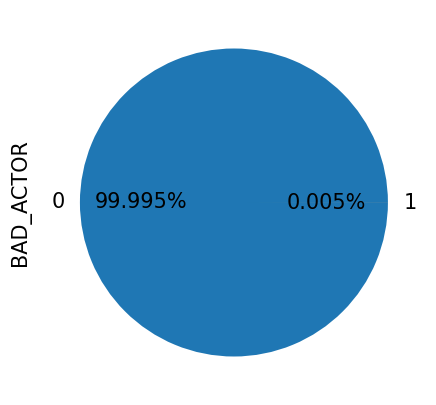

In [ ]:
# maintain same class % in train set
train_set.BAD_ACTOR.value_counts().plot(kind = 'pie', autopct='%.3f%%')

In [ ]:
# output
train_set.reset_index(drop=True).to_pickle('Task_3B_train.pkl')
test_set.reset_index(drop=True).to_pickle('Task_3B_test.pkl')

In [ ]:
# 10 bad actors in test set
np.unique(test_set.BAD_ACTOR, return_counts=True)

(array([0, 1], dtype=int64), array([399980,     20], dtype=int64))

## Read train set

In [ ]:
train_set = pd.read_pickle("Task_3B_train.pkl")
train_set

NAME  GENDER occupation_risk   BIRTH_DT  \
0         wally Kramer Williams Martin    Male        Moderate 1965-09-09   
1                Cory Hale Benton maes    Male            High 1950-04-29   
2               Furches, Jessie Mencia  Female             Low 1969-02-15   
3       George Espinoza CIOK Zimmerman    Male            High 1955-08-18   
4             Kimberly Garcia Browning  Female            High 1971-03-01   
...                                ...     ...             ...        ...   
599995                      Lauren Mri  Female             Low 1953-07-26   
599996           Vegter, Arthur Holzer    Male             Low 1977-12-31   
599997     Olivia Witherspoon Caldwell  Female             Low 1977-12-08   
599998   Ivory Dejesus Hendricks Roper  Female             Low 1942-10-02   
599999                     Soo Creasey  Female            High 1994-03-26   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       1989-01-24            1                  1      0                 Low   
1       1988-11-12            1                  1      0                 Low   
2       2002-10-19            1                  1      0                 Low   
3       2001-09-09            1                  1      0                 Low   
4       1991-10-10            1                  1      0                 Low   
...            ...          ...                ...    ...                 ...   
599995  1998-01-16            1                  1      0                 Low   
599996  2000-05-21            1                  1      0                 Low   
599997  2004-07-18            1                  1      0                 Low   
599998  2000-09-15            1                  1      0                 Low   
599999  2015-05-03            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   9,402.4490      11.0000    7,988.9620   
1                         Low     424.6520       1.0000    5,710.8990   
2                         Low   7,395.6720      13.0000   19,486.6940   
3                         Low   1,194.0560       2.0000   11,287.7720   
4                         Low   4,121.0000       2.0000   54,030.0000   
...                       ...          ...          ...           ...   
599995                    Low   2,169.9990       2.0000    1,412.9430   
599996                    Low   7,179.7630      10.0000    5,797.9610   
599997                    Low     175.5020       0.0000    1,580.1880   
599998                    Low   4,516.5470       6.0000    2,936.8200   
599999                    Low   2,160.6630       2.0000    2,760.3960   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            28.0000   220,558.0000      124.0000   239,696.0000   
1            21.0000   210,186.0000      142.0000    50,625.0000   
2            59.0000    71,345.0000      140.0000    71,125.0000   
3            29.0000   219,817.0000      103.0000    89,914.0000   
4            21.0000 9,325,137.0000      135.0000 2,901,611.0000   
...              ...            ...           ...            ...   
599995        3.0000    85,348.0000       11.0000    67,034.0000   
599996       19.0000   523,567.0000      252.0000   331,844.0000   
599997        5.0000   454,410.0000      160.0000   149,214.0000   
599998       13.0000   223,800.0000       59.0000   114,586.0000   
599999        5.0000   204,620.0000      101.0000   181,637.0000   

        WIRES_CNT_OUT  embedding_0  embedding_1  embedding_2  embedding_3  \
0            229.0000      -0.0661       0.0164       0.1000       0.0737   
1             92.0000      -0.0043       0.0003       0.0021       0.0003   
2            216.0000      -0.0009      -0.0041       0.0010       0.0023   
3            129.0000      -0.0611      -0.0173       0.0741      -0.0032   
4            159.0000      -0.0446      -0.0624       0.0

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 119 entries, NAME to BAD_ACTOR
dtypes: category(8), datetime64[ns](2), float32(100), float64(8), object(1)
memory usage: 283.8+ MB


# Dataset preparation

## Manual transformers on df
- manual transformers on entire train_set, not X_train
- involve row remvoal

### Inconsistency: Detect Entry Error


Add
- Average transaction amt ($) = SUM / CNT for both incoming and outgoing cash flows (size of transaction, as a large sum can be due to a large count)
  - CASH_AVG_IN = CASH_SUM_IN / CASH_CNT_IN
  - CASH_AVG_OUT = CASH_SUM_OUT / CASH_CNT_OUT
  - WIRES_AVG_IN = WIRES_SUM_IN / WIRES_CNT_IN
  - WIRES_AVG_OUT = WIRES_SUM_OUT / WIRES_CNT_OUT

Entry error
  - if any AVG = 999_999_999 (default value when CNT = 0 but SUM != 0), the record is invalid due to data entry error

In [ ]:
train_clean = copy.deepcopy(train_set)
# $ Average transaction amt = SUM / CNT for both incoming and outgoing cash flows
train_clean['WIRES_AVG_IN'] = custom_division(train_clean.WIRES_SUM_IN, train_clean.WIRES_CNT_IN, default_value=999_999_999)
train_clean['WIRES_AVG_OUT'] = custom_division(train_clean.WIRES_SUM_OUT, train_clean.WIRES_CNT_OUT, default_value=999_999_999)
train_clean['CASH_AVG_IN'] = custom_division(train_clean.CASH_SUM_IN, train_clean.CASH_CNT_IN, default_value=999_999_999)
train_clean['CASH_AVG_OUT'] = custom_division(train_clean.CASH_SUM_OUT, train_clean.CASH_CNT_OUT, default_value=999_999_999)
train_clean

NAME  GENDER occupation_risk   BIRTH_DT  \
0         wally Kramer Williams Martin    Male        Moderate 1965-09-09   
1                Cory Hale Benton maes    Male            High 1950-04-29   
2               Furches, Jessie Mencia  Female             Low 1969-02-15   
3       George Espinoza CIOK Zimmerman    Male            High 1955-08-18   
4             Kimberly Garcia Browning  Female            High 1971-03-01   
...                                ...     ...             ...        ...   
599995                      Lauren Mri  Female             Low 1953-07-26   
599996           Vegter, Arthur Holzer    Male             Low 1977-12-31   
599997     Olivia Witherspoon Caldwell  Female             Low 1977-12-08   
599998   Ivory Dejesus Hendricks Roper  Female             Low 1942-10-02   
599999                     Soo Creasey  Female            High 1994-03-26   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       1989-01-24            1                  1      0                 Low   
1       1988-11-12            1                  1      0                 Low   
2       2002-10-19            1                  1      0                 Low   
3       2001-09-09            1                  1      0                 Low   
4       1991-10-10            1                  1      0                 Low   
...            ...          ...                ...    ...                 ...   
599995  1998-01-16            1                  1      0                 Low   
599996  2000-05-21            1                  1      0                 Low   
599997  2004-07-18            1                  1      0                 Low   
599998  2000-09-15            1                  1      0                 Low   
599999  2015-05-03            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   9,402.4490      11.0000    7,988.9620   
1                         Low     424.6520       1.0000    5,710.8990   
2                         Low   7,395.6720      13.0000   19,486.6940   
3                         Low   1,194.0560       2.0000   11,287.7720   
4                         Low   4,121.0000       2.0000   54,030.0000   
...                       ...          ...          ...           ...   
599995                    Low   2,169.9990       2.0000    1,412.9430   
599996                    Low   7,179.7630      10.0000    5,797.9610   
599997                    Low     175.5020       0.0000    1,580.1880   
599998                    Low   4,516.5470       6.0000    2,936.8200   
599999                    Low   2,160.6630       2.0000    2,760.3960   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            28.0000   220,558.0000      124.0000   239,696.0000   
1            21.0000   210,186.0000      142.0000    50,625.0000   
2            59.0000    71,345.0000      140.0000    71,125.0000   
3            29.0000   219,817.0000      103.0000    89,914.0000   
4            21.0000 9,325,137.0000      135.0000 2,901,611.0000   
...              ...            ...           ...            ...   
599995        3.0000    85,348.0000       11.0000    67,034.0000   
599996       19.0000   523,567.0000      252.0000   331,844.0000   
599997        5.0000   454,410.0000      160.0000   149,214.0000   
599998       13.0000   223,800.0000       59.0000   114,586.0000   
599999        5.0000   204,620.0000      101.0000   181,637.0000   

        WIRES_CNT_OUT  embedding_x  embedding_y BAD_ACTOR  WIRES_AVG_IN  \
0            229.0000     -10.7901      48.4972         0    1,778.6935   
1             92.0000      28.6092     -35.1086         0    1,480.1831   
2            216.0000      -0.1792     -52.4174         0      509.6071   
3            129.0000      16.7555      49.0015         0    2,134.1456   
4            159.0000      27.8601      26.6846         0   69,075.

### Add dummy to indicate 999,999,999
- Add dummy variable to indicate 999_999_999 due to data entry error (CNT == 0 while SUM != 0)

In [ ]:
# rows with invalid data entry (CNT == 0 while SUM != 0)
EntryError_df = train_clean.loc[(train_clean == 999_999_999).any(axis=1), [x for x in train_clean.columns if ('_SUM_' in x) | ('_CNT_' in x) | (x == 'BAD_ACTOR')]]
EntryError_df

CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  CASH_CNT_OUT  WIRES_SUM_IN  \
19       3,643.0000       1.0000   15,075.0000        6.0000  851,845.0000   
27         199.7610       0.0000   18,564.5940       56.0000  402,592.0000   
33         225.3510       0.0000    4,497.6120       12.0000  254,083.0000   
34       1,824.2340       2.0000       14.6530        0.0000   21,545.0000   
38       3,749.8700       3.0000       70.1790        0.0000   44,025.0000   
...             ...          ...           ...           ...           ...   
599917   2,004.9210       4.0000        3.6110        0.0000   24,728.0000   
599918     112.7730       0.0000    3,481.8770        5.0000  144,035.0000   
599925     140.4950       0.0000      745.0100        5.0000  274,593.0000   
599967     157.1600       0.0000    5,258.0000        4.0000  153,131.0000   
599997     175.5020       0.0000    1,580.1880        5.0000  454,410.0000   

        WIRES_CNT_IN  WIRES_SUM_OUT  WIRES_CNT_OUT BAD_ACTOR  
19            8.0000   149,179.0000         0.0000         0  
27          169.0000   240,825.0000       238.0000         0  
33           89.0000    15,711.0000        52.0000         0  
34            5.0000    62,786.0000        21.0000         0  
38           26.0000    19,039.0000        10.0000         0  
...              ...            ...            ...       ...  
599917       12.0000     6,154.0000         5.0000         0  
599918       23.0000    39,686.0000        52.0000         0  
599925       70.0000   124,919.0000       118.0000         0  
599967        0.0000   617,557.0000        19.0000         0  
599997      160.0000   149,214.0000       169.0000         0  

[37748 rows x 9 columns]

In [ ]:
EntryError_df.BAD_ACTOR.value_counts()

0    37747
1        1
Name: BAD_ACTOR, dtype: int64

In [ ]:
# bad actor with data entry error
train_clean.loc[((train_clean == 999_999_999).any(axis=1)) & (train_clean.BAD_ACTOR == 1)]

NAME GENDER occupation_risk   BIRTH_DT  \
199829  Robert Johnson Myles Montoya   Male             Low 1955-05-26   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
199829  1993-07-15            1                  1      1                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
199829                    Low   1,102.9160       0.0000   16,001.0000   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
199829        7.0000 2,433,128.0000       42.0000 1,418,367.0000   

        WIRES_CNT_OUT  embedding_x  embedding_y BAD_ACTOR  WIRES_AVG_IN  \
199829       291.0000      15.8636      55.3025         1   57,931.6190   

        WIRES_AVG_OUT      CASH_AVG_IN  CASH_AVG_OUT  
199829     4,874.1134 999,999,999.0000    2,285.8571

In [ ]:
# CNT is not recorded as 0 due to threshold in SUM but due to data entry error
for CNT_col, SUM_col in [('CASH_CNT_IN', 'CASH_SUM_IN'), ('CASH_CNT_OUT', 'CASH_SUM_OUT'), ('WIRES_CNT_IN', 'WIRES_SUM_IN'), ('WIRES_CNT_OUT', 'WIRES_SUM_OUT')]:
  print(f'when {CNT_col} == 0, max({SUM_col}) = {EntryError_df[EntryError_df[CNT_col] == 0][SUM_col].max():,.2f}')
  print(f'when {CNT_col} != 0, min({SUM_col}) = {train_clean[train_clean[CNT_col] != 0][SUM_col].min():,.2f}')

when CASH_CNT_IN == 0, max(CASH_SUM_IN) = 12,030.00
when CASH_CNT_IN != 0, min(CASH_SUM_IN) = 44.14
when CASH_CNT_OUT == 0, max(CASH_SUM_OUT) = 12,397.00
when CASH_CNT_OUT != 0, min(CASH_SUM_OUT) = 12.26
when WIRES_CNT_IN == 0, max(WIRES_SUM_IN) = 14,216,221.00
when WIRES_CNT_IN != 0, min(WIRES_SUM_IN) = 4.00
when WIRES_CNT_OUT == 0, max(WIRES_SUM_OUT) = 3,736,233.00
when WIRES_CNT_OUT != 0, min(WIRES_SUM_OUT) = 10.00


In [ ]:
# add dummy variable to indicate data entry error
train_clean['DATA_ENTRY_ERROR'] = 0
train_clean.loc[train_clean.index.isin(EntryError_df.index), 'DATA_ENTRY_ERROR'] = 1
# replace 999_999_999 with 0
train_clean.replace(999_999_999, 0, inplace=True)
train_clean

NAME  GENDER occupation_risk   BIRTH_DT  \
0         wally Kramer Williams Martin    Male        Moderate 1965-09-09   
1                Cory Hale Benton maes    Male            High 1950-04-29   
2               Furches, Jessie Mencia  Female             Low 1969-02-15   
3       George Espinoza CIOK Zimmerman    Male            High 1955-08-18   
4             Kimberly Garcia Browning  Female            High 1971-03-01   
...                                ...     ...             ...        ...   
599995                      Lauren Mri  Female             Low 1953-07-26   
599996           Vegter, Arthur Holzer    Male             Low 1977-12-31   
599997     Olivia Witherspoon Caldwell  Female             Low 1977-12-08   
599998   Ivory Dejesus Hendricks Roper  Female             Low 1942-10-02   
599999                     Soo Creasey  Female            High 1994-03-26   

       CUST_ADD_DT RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL COUNTRY_RISK_INCOME  \
0       1989-01-24            1                  1      0                 Low   
1       1988-11-12            1                  1      0                 Low   
2       2002-10-19            1                  1      0                 Low   
3       2001-09-09            1                  1      0                 Low   
4       1991-10-10            1                  1      0                 Low   
...            ...          ...                ...    ...                 ...   
599995  1998-01-16            1                  1      0                 Low   
599996  2000-05-21            1                  1      0                 Low   
599997  2004-07-18            1                  1      0                 Low   
599998  2000-09-15            1                  1      0                 Low   
599999  2015-05-03            1                  1      0                 Low   

       COUNTRY_RISK_RESIDENCY  CASH_SUM_IN  CASH_CNT_IN  CASH_SUM_OUT  \
0                         Low   9,402.4490      11.0000    7,988.9620   
1                         Low     424.6520       1.0000    5,710.8990   
2                         Low   7,395.6720      13.0000   19,486.6940   
3                         Low   1,194.0560       2.0000   11,287.7720   
4                         Low   4,121.0000       2.0000   54,030.0000   
...                       ...          ...          ...           ...   
599995                    Low   2,169.9990       2.0000    1,412.9430   
599996                    Low   7,179.7630      10.0000    5,797.9610   
599997                    Low     175.5020       0.0000    1,580.1880   
599998                    Low   4,516.5470       6.0000    2,936.8200   
599999                    Low   2,160.6630       2.0000    2,760.3960   

        CASH_CNT_OUT   WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0            28.0000   220,558.0000      124.0000   239,696.0000   
1            21.0000   210,186.0000      142.0000    50,625.0000   
2            59.0000    71,345.0000      140.0000    71,125.0000   
3            29.0000   219,817.0000      103.0000    89,914.0000   
4            21.0000 9,325,137.0000      135.0000 2,901,611.0000   
...              ...            ...           ...            ...   
599995        3.0000    85,348.0000       11.0000    67,034.0000   
599996       19.0000   523,567.0000      252.0000   331,844.0000   
599997        5.0000   454,410.0000      160.0000   149,214.0000   
599998       13.0000   223,800.0000       59.0000   114,586.0000   
599999        5.0000   204,620.0000      101.0000   181,637.0000   

        WIRES_CNT_OUT  embedding_x  embedding_y BAD_ACTOR  WIRES_AVG_IN  \
0            229.0000     -10.7901      48.4972         0    1,778.6935   
1             92.0000      28.6092     -35.1086         0    1,480.1831   
2            216.0000      -0.1792     -52.4174         0      509.6071   
3            129.0000      16.7555      49.0015         0    2,134.1456   
4            159.0000      27.8601      26.6846         0   69,075.

### Feature Engineering

*Placement: sum / count of cash flow*

• Example: customer deposits a total of $20,000 in cash using multiple transactions to
avoid reporting and detection of large cash deposits

*Layering*

• Customer receives an incoming wire from Country A for
$20,000, then sends an outgoing wire in the same
amount to Country B, or

• Customer makes a deposit to their account, then
transfers the funds to another of their accounts with
another financial institution

*Integration*

• Use illicit proceeds to purchase luxury assets such as real
estate, high end artwork, jewelry or vehicles

• A client opens an offshore bank account with a debit or credit
card to access the account. They wire illicit proceeds to this
offshore account, which are used for withdrawals or purchases

In [ ]:
def plot_percentiles(df, col_select = '', col_drop = None):
  fig, axes = plt.subplots(1,2, sharex = True, sharey = False, figsize = (20,5))

  # col_select = 'AVG'
  if col_select != '':
    if col_drop is None:
      norm_clean = pd.concat([
          df.select_dtypes(np.number)[[x for x in df.columns if col_select in x]].apply(lambda x: (x - x.mean()) / x.std()),
          df.BAD_ACTOR], axis = 1)
    else:
      norm_clean = pd.concat([
          df.select_dtypes(np.number)[[x for x in df.drop(columns = col_drop).columns if col_select in x]].apply(lambda x: (x - x.mean()) / x.std()),
          df.BAD_ACTOR], axis = 1)
  else:
    norm_clean = pd.concat([
        df.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std()),
        df.BAD_ACTOR], axis = 1)

  for ax, risk in zip(axes.flatten(), norm_clean.BAD_ACTOR.unique()):
    # norm_clean[norm_clean.BAD_ACTOR == risk].describe(percentiles = [.05, .25, .5, .75, .95], exclude=['category', 'object'], datetime_is_numeric=True).loc['25%':'75%',:].T.plot(kind = 'barh', ax = ax, legend = False)
    norm_clean[norm_clean.BAD_ACTOR == risk].select_dtypes(np.number).plot(kind='box', vert=False, showfliers=False, ax = ax)
    ax.set_title(f"Bad Actor = {risk}")
    # ax.set_yticks(ticks = np.arange(1,6,1), labels = [])
    ax.axvline(0, ls = '--')
    ax.axvline(1, ls = '--')
    ax.axvline(-1, ls = '--')
    ax.set_xlim(-1.5, 1.5)

  plt.subplots_adjust(hspace = 0.2)
  plt.suptitle('25th percentile, median, 75th percentile and 1.5 x IQR', fontsize = 20)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

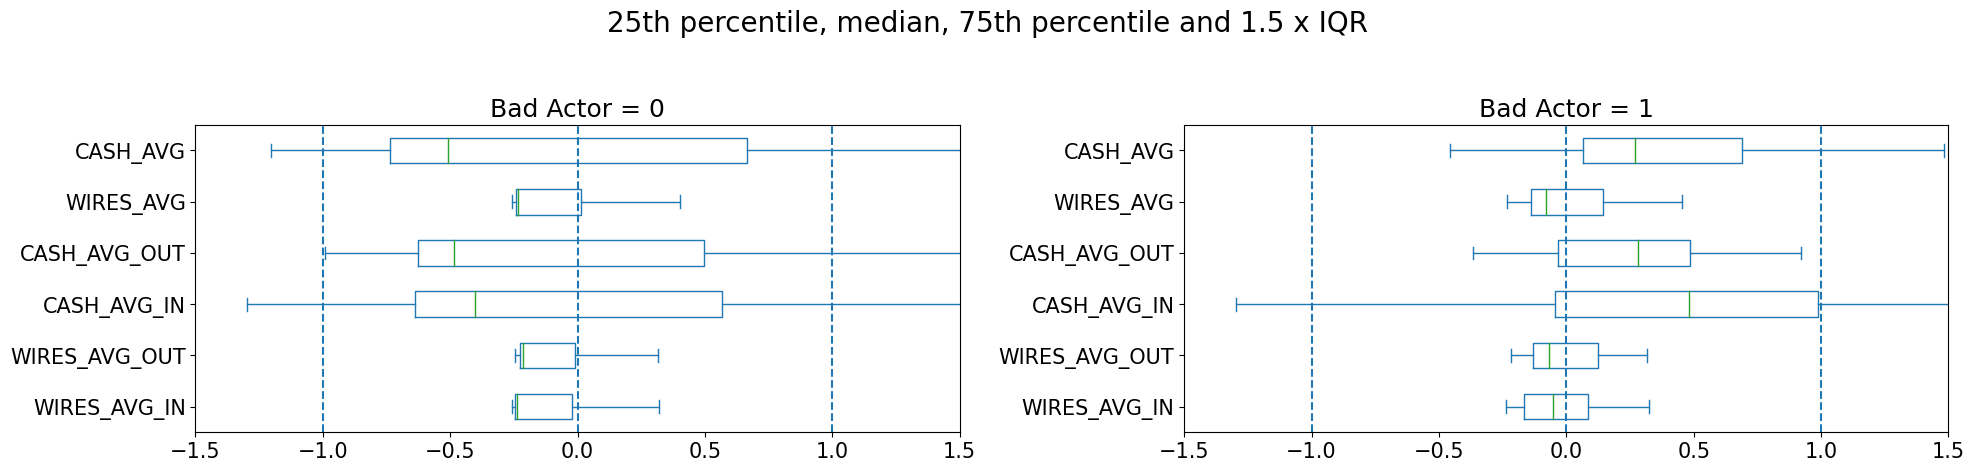

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT))
train_clean2['WIRES_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT))
train_clean2['CASH_AVG'] = custom_division((train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT))
train_clean2['IN_AVG'] = custom_division((train_clean2.WIRES_SUM_IN + train_clean2.CASH_SUM_IN),
                                            (train_clean2.WIRES_CNT_IN + train_clean2.CASH_CNT_IN))
train_clean2['OUT_AVG'] = custom_division((train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_OUT),
                                            (train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_OUT))
train_clean2.drop(columns = [
    # need to split between WIRES and CASH (magnitude)
    'TOTAL_AVG', 'IN_AVG', 'OUT_AVG',
], inplace = True)

plot_percentiles(train_clean2, 'AVG')

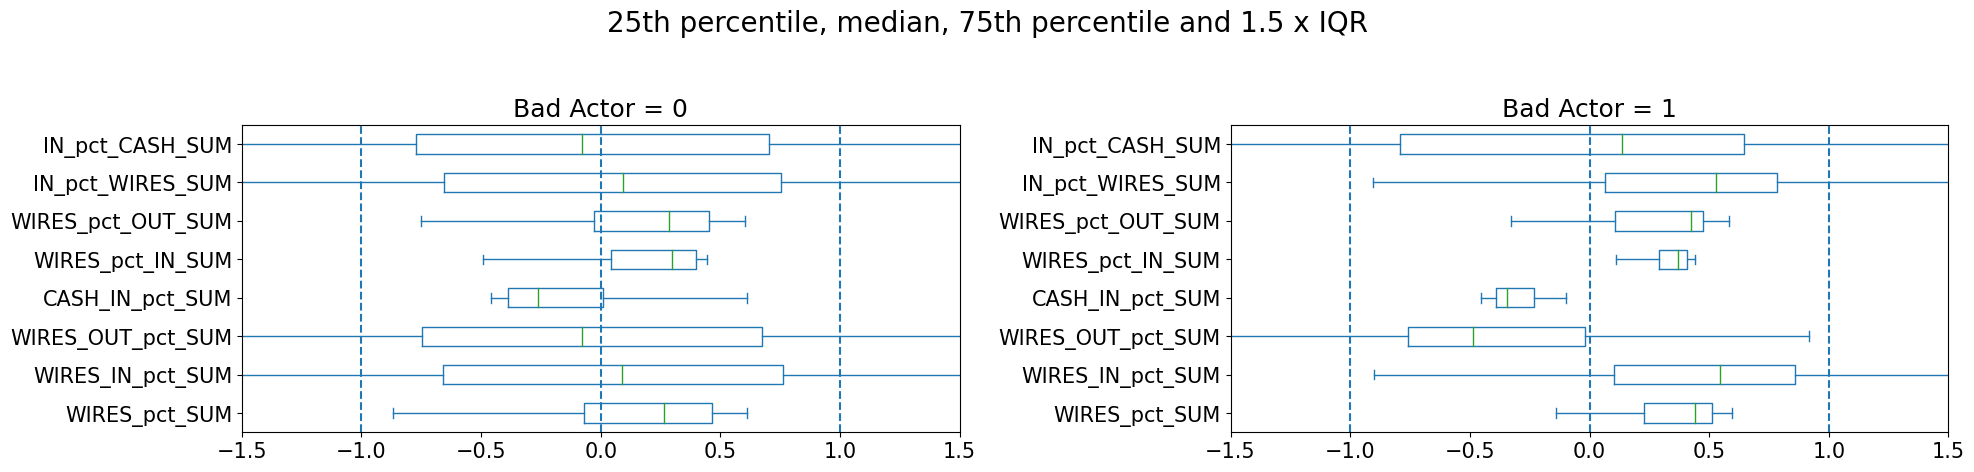

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT)
train_clean2['TOTAL_IN_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.CASH_SUM_IN)
train_clean2['TOTAL_OUT_SUM'] = (train_clean2.WIRES_SUM_OUT + train_clean2.CASH_SUM_OUT)
train_clean2['TOTAL_WIRES_SUM'] = (train_clean2.WIRES_SUM_IN + train_clean2.WIRES_SUM_OUT)
train_clean2['TOTAL_CASH_SUM'] = (train_clean2.CASH_SUM_IN + train_clean2.CASH_SUM_OUT)

train_clean2['WIRES_pct_SUM'] = custom_division(train_clean2.TOTAL_WIRES_SUM, train_clean2.TOTAL_SUM)

train_clean2['WIRES_IN_pct_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_SUM)
train_clean2['WIRES_OUT_pct_SUM'] = custom_division(train_clean2.WIRES_SUM_OUT, train_clean2.TOTAL_SUM)
train_clean2['CASH_IN_pct_SUM'] = custom_division(train_clean2.CASH_SUM_IN, train_clean2.TOTAL_SUM)

train_clean2['WIRES_pct_IN_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_IN_SUM)
train_clean2['WIRES_pct_OUT_SUM'] = custom_division(train_clean2.WIRES_SUM_OUT, train_clean2.TOTAL_OUT_SUM)

train_clean2['IN_pct_WIRES_SUM'] = custom_division(train_clean2.WIRES_SUM_IN, train_clean2.TOTAL_WIRES_SUM)
train_clean2['IN_pct_CASH_SUM'] = custom_division(train_clean2.CASH_SUM_IN, train_clean2.TOTAL_CASH_SUM)


train_clean2.drop(columns = [
    # drop TOTAL (only created for ease of calculation)
    'TOTAL_SUM', 'TOTAL_IN_SUM', 'TOTAL_OUT_SUM', 'TOTAL_WIRES_SUM', 'TOTAL_CASH_SUM',
    # drop SUM 
    'WIRES_SUM_IN', 'WIRES_SUM_OUT', 'CASH_SUM_IN', 'CASH_SUM_OUT'

], inplace = True)

plot_percentiles(train_clean2, 'SUM')

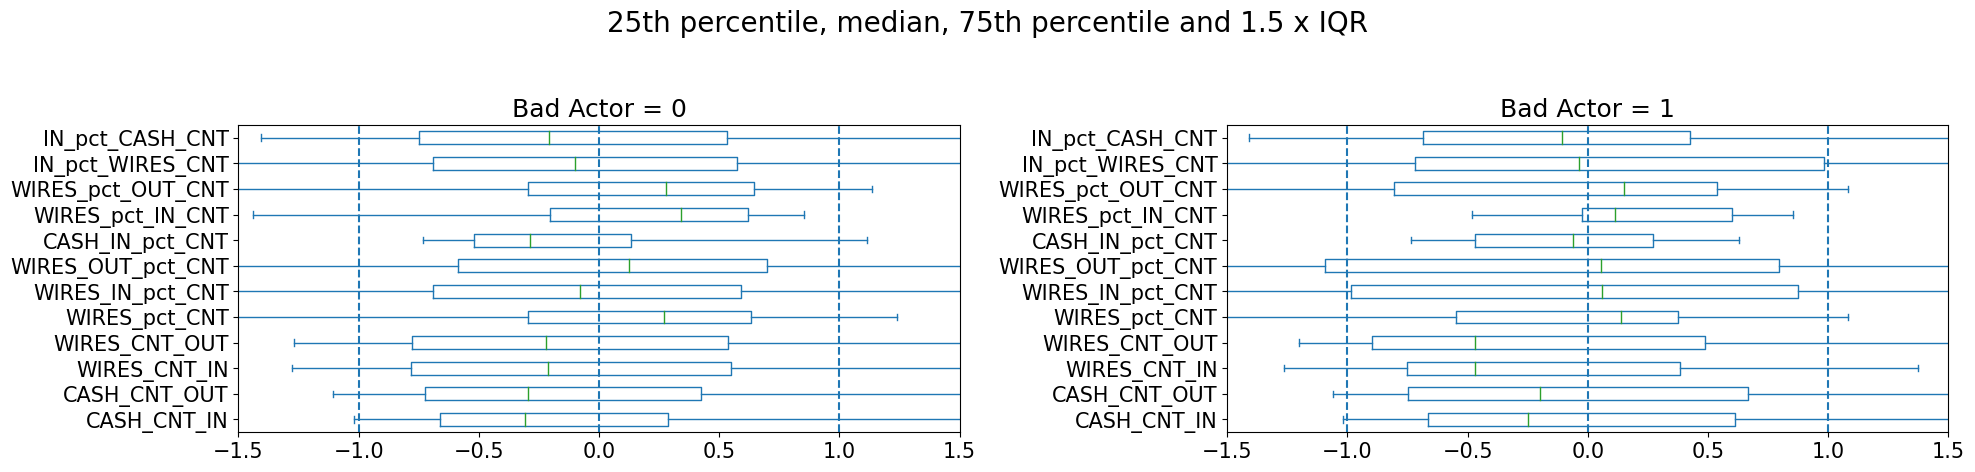

In [ ]:
train_clean2 = copy.deepcopy(train_clean)

train_clean2['TOTAL_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT)
train_clean2['TOTAL_IN_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.CASH_CNT_IN)
train_clean2['TOTAL_OUT_CNT'] = (train_clean2.WIRES_CNT_OUT + train_clean2.CASH_CNT_OUT)
train_clean2['TOTAL_WIRES_CNT'] = (train_clean2.WIRES_CNT_IN + train_clean2.WIRES_CNT_OUT)
train_clean2['TOTAL_CASH_CNT'] = (train_clean2.CASH_CNT_IN + train_clean2.CASH_CNT_OUT)

train_clean2['WIRES_pct_CNT'] = custom_division(train_clean2.TOTAL_WIRES_CNT, train_clean2.TOTAL_CNT)

train_clean2['WIRES_IN_pct_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_CNT)
train_clean2['WIRES_OUT_pct_CNT'] = custom_division(train_clean2.WIRES_CNT_OUT, train_clean2.TOTAL_CNT)
train_clean2['CASH_IN_pct_CNT'] = custom_division(train_clean2.CASH_CNT_IN, train_clean2.TOTAL_CNT)

train_clean2['WIRES_pct_IN_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_IN_CNT)
train_clean2['WIRES_pct_OUT_CNT'] = custom_division(train_clean2.WIRES_CNT_OUT, train_clean2.TOTAL_OUT_CNT)

train_clean2['IN_pct_WIRES_CNT'] = custom_division(train_clean2.WIRES_CNT_IN, train_clean2.TOTAL_WIRES_CNT)
train_clean2['IN_pct_CASH_CNT'] = custom_division(train_clean2.CASH_CNT_IN, train_clean2.TOTAL_CASH_CNT)


train_clean2.drop(columns = [
    # 
    'TOTAL_CNT', 'TOTAL_IN_CNT', 'TOTAL_OUT_CNT', 'TOTAL_WIRES_CNT', 'TOTAL_CASH_CNT'
], inplace = True)

plot_percentiles(train_clean2, 'CNT', ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA'])

### ManualTransformer

Normal cost-efficient but slow transactions
- use EMT for small amount
- use wires transfer for large amount
- use as few transactions as possible to save transaction fee
- maximize EMT limit before using wires transfer

Abnormal cost-inefficient but fast transactions
- use as many transactions as possible
- use wires transfer to avoid caps in EMT

Transfer limit
- EMT trasnfer: minimum = CAD0.01, maximum = CAD25k per transaction
- Wire transfer limit: minimum = CAD100
- https://help.scotiabank.com/article/how-much-can-i-send-with-scotia-international-money-transfer?origin=help-center


Money Laundering indicators involving transactions (https://fintrac-canafe.canada.ca/guidance-directives/transaction-operation/indicators-indicateurs/fin_mltf-eng)
- Client frequents multiple locations utilizing cash, prepaid credit cards or money orders/cheques/drafts to send wire transfers overseas.
  - high count of transactions
- Funds are deposited or received into several accounts and then consolidated into one before transferring the funds outside the country.
  - multiple IN_CNT
  - there are no limits in accepting e-transfer https://help.scotiabank.com/article/are-there-interac-e-transfer-limits?origin=scotia-connect
- Immediately after transferred funds have cleared, the client moves funds, to another account or to another person or entity.
  - IN_SUM similar to OUT_SUM
- Client sending to, or receiving wire transfers from, multiple clients.
  - high IN_CNT, high OUT_CNT

Feature creation
- missingness in NAME
  - inability to properly identify the client or there are questions surrounding the client's identity
- AGE (float) = (Today (2023 Jan 01) - BIRTH_DT) / 365.25
- HIST_JOIN (float) = Age when customer joined = (CUST_ADD_DT - BIRTH_DT) / 365.25
- AVG
  - WIRES_AVG_IN
  - WIRES_AVG_OUT
  - CASH_AVG_IN
  - CASH_AVG_OUT
  - drop data entry errors

- ratio of AVG
  - WIRES vs CASH
    - WIRES_VS_CASH_AVG
  - WIRES_IN vs WIRES_OUT
    - IN_VS_OUT_WIRES_AVG
  - CASH_IN vs CASH_OUT
    - IN_VS_OUT_CASH_AVG
- % of CNT
  - % of TOTAL_CNT
    - WIRES_pct_CNT
  - % of TOTAL_WIRES_CNT
    - IN_pct_WIRES_CNT
  - % of TOTAL_CASH_CNT
    - IN_pct_CASH_CNT
- ratio of CNT vs AVG
  - WIRES_IN_CNT_VS_AVG
  - WIRES_OUT_CNT_VS_AVG
  - CASH_IN_CNT_VS_AVG
  - CASH_OUT_CNT_VS_AVG

Drop
  - NAME, BIRTH_DT, CUST_ADD_DT
  - SUM: CASH_SUM_IN, CASH_SUM_OUT, WIRES_SUM_IN, WIRES_SUM_OUT
  - helper columns for SUM, CNT and AVG



In [ ]:
dataset_preparation = make_pipeline(
    ManualTransformer()
)

In [ ]:
train_clean = dataset_preparation.fit_transform(train_set)
train_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0         Male        Moderate            1                  1      0   
1         Male            High            1                  1      0   
2       Female             Low            1                  1      0   
3         Male            High            1                  1      0   
4       Female            High            1                  1      0   
...        ...             ...          ...                ...    ...   
599995  Female             Low            1                  1      0   
599996    Male             Low            1                  1      0   
599997  Female             Low            1                  1      0   
599998  Female             Low            1                  1      0   
599999  Female            High            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low      11.0000       28.0000   
1                      Low                    Low       1.0000       21.0000   
2                      Low                    Low      13.0000       59.0000   
3                      Low                    Low       2.0000       29.0000   
4                      Low                    Low       2.0000       21.0000   
...                    ...                    ...          ...           ...   
599995                 Low                    Low       2.0000        3.0000   
599996                 Low                    Low      10.0000       19.0000   
599997                 Low                    Low       0.0000        5.0000   
599998                 Low                    Low       6.0000       13.0000   
599999                 Low                    Low       2.0000        5.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  embedding_1  embedding_2  \
0           124.0000       229.0000      -0.0661       0.0164       0.1000   
1           142.0000        92.0000      -0.0043       0.0003       0.0021   
2           140.0000       216.0000      -0.0009      -0.0041       0.0010   
3           103.0000       129.0000      -0.0611      -0.0173       0.0741   
4           135.0000       159.0000      -0.0446      -0.0624       0.0761   
...              ...            ...          ...          ...          ...   
599995       11.0000        36.0000       0.0033      -0.0039      -0.0001   
599996      252.0000       395.0000      -0.0021       0.0012       0.0021   
599997      160.0000       169.0000      -0.0353      -0.0082       0.0191   
599998       59.0000        34.0000      -0.0345      -0.0159       0.0343   
599999      101.0000       118.0000      -0.0230      -0.0054       0.0461   

        embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  \
0            0.0737       0.1595      -0.0684      -0.1340       0.0865   
1            0.0003       0.0050       0.0011      -0.0028       0.0020   
2            0.0023      -0.0017      -0.0022       0.0013       0.0045   
3           -0.0032       0.1091       0.0122       0.0279       0.0520   
4            0.0201       0.0483       0.0443       0.0483       0.0498   
...             ...          ...          ...          ...          ...   
599995       0.0021       0.0000       0.0011      -0.0033       0.0009   
599996       0.0019      -0.0030      -0.0049      -0.0022       0.0007   
599997      -0.0023       0.0502      -0.0082       0.0147       0.0165   
599998      -0.0052       0.0423       0.0120      -0.0064       0.0196   
599999       0.0099       0.0428       0.0105       0.0170       0.0241   

        embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  \
0           -0.1798       0.0432       -0.0185       -0.1092        0.1481   
1            0.0030       0.0050       -0.0000        0.0049       -0.0020   
2            0.0018       0.0013        0.0017        0.0025        0.0034   
3           -0.1248 

## Outliers removal
- Check min, max or IQR
  - Alternative: isolation forest (less interpretable)
- Outliers
  - min and max AGE seems wrong (3 and 142 years old)
    - [Scotiabank: No limit in minimum age](https://www.scotiabank.com/ca/en/personal/bank-accounts/students/getting-there-savings-program-youth.html#:~:text=Children%20under%2012%20must%20be,able%20to%20provide%20adequate%20ID.) as children under 12 can open an account while being accompanied by a parent or legal guardian 
    - Oldest person living = [(Guineness Record) 118 years old](https://www.guinnessworldrecords.com/world-records/84549-oldest-person-living)
  - min WIRES_AVG_IN and WIRES_AVG_OUT should be at least CAD100? https://help.scotiabank.com/article/how-much-can-i-send-with-scotia-international-money-transfer?origin=help-center 
- Binning data with QuantileTransformer
- Risk of removing the most important subset (e.g. high risk class that is rare?)

In [ ]:
train_clean.describe()

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  \
count 600,000.0000  600,000.0000  600,000.0000   600,000.0000 600,000.0000   
mean        8.5937       23.1274       85.3052       152.3768      -0.0289   
std         8.4315       20.8698       66.7952       120.2389       0.0702   
min         0.0000        0.0000        0.0000         0.0000      -2.4367   
25%         3.0000        8.0000       33.0000        59.0000      -0.0368   
50%         6.0000       17.0000       71.0000       126.0000      -0.0047   
75%        11.0000       32.0000      122.0000       217.0000       0.0003   
max        78.0000      203.0000      605.0000     1,083.0000       1.0176   

       embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
count 600,000.0000 600,000.0000 600,000.0000 600,000.0000 600,000.0000   
mean       -0.0093       0.0403       0.0047       0.0395       0.0045   
std         0.0561       0.0819       0.0536       0.0801       0.0557   
min        -1.6425      -1.1368      -1.2334      -0.9548      -1.4383   
25%        -0.0117      -0.0001      -0.0027      -0.0001      -0.0028   
50%        -0.0025       0.0079       0.0014       0.0080       0.0013   
75%         0.0018       0.0527       0.0062       0.0515       0.0057   
max         1.0214       1.8645       1.4104       2.5356       1.6399   

       embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
count 600,000.0000 600,000.0000 600,000.0000 600,000.0000  600,000.0000   
mean        0.0049       0.0261      -0.0502       0.0202       -0.0176   
std         0.0537       0.0684       0.0929       0.0625        0.0609   
min        -1.2564      -1.0761      -2.4022      -1.4743       -2.0144   
25%        -0.0027      -0.0004      -0.0675      -0.0007       -0.0222   
50%         0.0013       0.0046      -0.0155       0.0042       -0.0039   
75%         0.0061       0.0331      -0.0000       0.0251        0.0008   
max         1.6502       1.8695       0.9227       1.5225        1.1161   

       embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
count  600,000.0000  600,000.0000  600,000.0000  600,000.0000  600,000.0000   
mean         0.0078        0.0212       -0.0276        0.0916       -0.0529   
std          0.0565        0.0638        0.0674        0.1480        0.0968   
min         -1.3676       -0.8316       -1.9457       -0.2726       -2.1521   
25%         -0.0021       -0.0006       -0.0347        0.0002       -0.0712   
50%          0.0021        0.0043       -0.0047        0.0419       -0.0178   
75%          0.0095        0.0270        0.0003        0.1306       -0.0000   
max          1.4267        2.1449        0.8697        3.5091        0.5996   

       embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  \
count  600,000.0000  600,000.0000  600,000.0000  600,000.0000  600,000.0000   
mean         0.0517        0.0241       -0.0521       -0.0004        0.0242   
std          0.0957        0.0652        0.0956        0.0558        0.0652   
min         -0.7354       -1.1169       -2.9876       -1.6096       -0.9880   
25%          0.0000       -0.0005       -0.0702       -0.0040       -0.0005   
50%          0.0166        0.0045       -0.0172       -0.0001        0.0045   
75%          0.0695        0.0306       -0.0000        0.0039        0.0308   
max          2.4056        1.8414        0.7626        1.6210        1.5459   

       embedding_21  embedding_22  embedding_23  embedding_24  embedding_25  \
count  600,000.0000  600,000.0000  600,000.0000  600,000.0000  600,000.0000   
mean        -0.0479       -0.0708        0.0077        0.0061        0.0566   
std          0.0901        0.1196        0.0551        0.0543        0.1014   
min         -2.6464       -2.9943       -1.2852       -1.3414       -0.5582   
25%         -0.0640       -0.0987       -0.0021       -0.0024        0.0001   
50%         -0.0134       -0.0299        0.0021        0.0017  

In [ ]:
outlier_df = train_set.loc[train_clean[train_clean.AGE >= 118].index, ['NAME', 'BIRTH_DT', 'BAD_ACTOR']].sort_values('BIRTH_DT')
outlier_df

NAME   BIRTH_DT BAD_ACTOR
203152     Rebecca Mayne Newman Paik 1884-08-18         0
405990       Angel Minor paocs Marsh 1887-03-31         0
523278           junius Sims Hendrix 1891-08-03         0
96618          Nance, Beverly Varney 1891-08-25         0
49253     Edith D~.ixon Johnson Apel 1893-08-12         0
...                              ...        ...       ...
354397          Eugene Holmes Beales 1904-10-10         0
285050  Wendolyn Davis Pickett Adams 1904-10-21         0
48518             Reese, Robert Tran 1904-11-23         0
420840     Jacqueline Manning Howard 1904-11-27         0
563372          Louise Reid Brentley 1904-12-06         0

[84 rows x 3 columns]

In [ ]:
outlier_df.BAD_ACTOR.value_counts()

0    84
1     0
Name: BAD_ACTOR, dtype: int64

In [ ]:
dataset_preparation.steps.append(('outlierremoval', OutlierRemoval()))

In [ ]:
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

In [ ]:
dataset_preparation.fit(train_set)
train_clean = dataset_preparation.transform(train_set)
train_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0         Male        Moderate            1                  1      0   
1         Male            High            1                  1      0   
2       Female             Low            1                  1      0   
3         Male            High            1                  1      0   
4       Female            High            1                  1      0   
...        ...             ...          ...                ...    ...   
599995  Female             Low            1                  1      0   
599996    Male             Low            1                  1      0   
599997  Female             Low            1                  1      0   
599998  Female             Low            1                  1      0   
599999  Female            High            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low      11.0000       28.0000   
1                      Low                    Low       1.0000       21.0000   
2                      Low                    Low      13.0000       59.0000   
3                      Low                    Low       2.0000       29.0000   
4                      Low                    Low       2.0000       21.0000   
...                    ...                    ...          ...           ...   
599995                 Low                    Low       2.0000        3.0000   
599996                 Low                    Low      10.0000       19.0000   
599997                 Low                    Low       0.0000        5.0000   
599998                 Low                    Low       6.0000       13.0000   
599999                 Low                    Low       2.0000        5.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  embedding_1  embedding_2  \
0           124.0000       229.0000      -0.0661       0.0164       0.1000   
1           142.0000        92.0000      -0.0043       0.0003       0.0021   
2           140.0000       216.0000      -0.0009      -0.0041       0.0010   
3           103.0000       129.0000      -0.0611      -0.0173       0.0741   
4           135.0000       159.0000      -0.0446      -0.0624       0.0761   
...              ...            ...          ...          ...          ...   
599995       11.0000        36.0000       0.0033      -0.0039      -0.0001   
599996      252.0000       395.0000      -0.0021       0.0012       0.0021   
599997      160.0000       169.0000      -0.0353      -0.0082       0.0191   
599998       59.0000        34.0000      -0.0345      -0.0159       0.0343   
599999      101.0000       118.0000      -0.0230      -0.0054       0.0461   

        embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  \
0            0.0737       0.1595      -0.0684      -0.1340       0.0865   
1            0.0003       0.0050       0.0011      -0.0028       0.0020   
2            0.0023      -0.0017      -0.0022       0.0013       0.0045   
3           -0.0032       0.1091       0.0122       0.0279       0.0520   
4            0.0201       0.0483       0.0443       0.0483       0.0498   
...             ...          ...          ...          ...          ...   
599995       0.0021       0.0000       0.0011      -0.0033       0.0009   
599996       0.0019      -0.0030      -0.0049      -0.0022       0.0007   
599997      -0.0023       0.0502      -0.0082       0.0147       0.0165   
599998      -0.0052       0.0423       0.0120      -0.0064       0.0196   
599999       0.0099       0.0428       0.0105       0.0170       0.0241   

        embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  \
0           -0.1798       0.0432       -0.0185       -0.1092        0.1481   
1            0.0030       0.0050       -0.0000        0.0049       -0.0020   
2            0.0018       0.0013        0.0017        0.0025        0.0034   
3           -0.1248 

## dump as dataset_preparation.joblib

In [ ]:
dump(dataset_preparation, f'dataset_preparation.joblib') 

['dataset_preparation.joblib']

## load dataset_preparation()

In [ ]:
dataset_preparation = load('dataset_preparation.joblib')
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

# X, y, sample weights split()

In [ ]:
# make a copy and split X and y
X_train = train_clean.drop(columns = ["BAD_ACTOR", "TOTAL_SUM"]).reset_index(drop = True).copy(deep = True)
y_train = train_clean["BAD_ACTOR"].reset_index(drop = True)
sample_weights_train = train_clean["TOTAL_SUM"].reset_index(drop = True)

# Exploratory data analysis (EDA)
- Check if all the information needed (to solve the data mining goals) is actually available
- what additional information would be helpful?
- Analyze basic statistics and relate the results to their meaning in business terms

In [ ]:
# either category or numerical
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599916 entries, 0 to 599915
Columns: 132 entries, GENDER to WIRES_BALANCE
dtypes: category(10), float32(100), float64(22)
memory usage: 335.3 MB


## nominal, ordinal, ratio scale
- nominal
  - order doesn't matter
- ordinal
  - order matters but difference is not in fixed interval
- interval
  - order matters + fixed interval 
- ratio
  - order matters + fixed interval + only positive

## Univariate analysis
- compute basic statistics (e.g., compute distribution, average, max, min, standard deviation, variance, mode, skewness, etc.)
- histogram

### Numerical
- WIRES_AVG >> CASH_AVG
- WIRES_CNT >> CASH_CNT
- Outliers
  - min and max AGE seems wrong (3 and 142 years old)
  - min WIRES_AVG_IN and WIRES_AVG_OUT should be at least CAD100?

In [ ]:
# numeric columns
X_train.describe(include = np.number)

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_x  \
count 799,883.0000  799,883.0000  799,883.0000   799,883.0000 799,883.0000   
mean        8.5984       23.1458       85.3443       152.3993      -0.1758   
std         8.4311       20.8819       66.7823       120.1193      21.7858   
min         0.0000        0.0000        0.0000         0.0000     -55.9594   
25%         3.0000        8.0000       33.0000        59.0000     -13.2670   
50%         6.0000       17.0000       71.0000       126.0000       2.9174   
75%        11.0000       32.0000      122.0000       218.0000      16.4667   
max        79.0000      203.0000      605.0000     1,083.0000      42.4883   

       embedding_y          AGE    HIST_JOIN    WIRES_AVG_IN  WIRES_AVG_OUT  \
count 799,883.0000 799,883.0000 796,519.0000    799,883.0000   799,883.0000   
mean       -1.1735      50.8006      18.3809     63,417.7945    13,746.0749   
std        32.8588      18.2102       9.9262    248,059.8874    55,012.0435   
min       -64.8958       3.2580       0.4353          0.0000         0.0000   
25%       -29.6957      38.1383      10.8118      2,108.3079     1,098.0456   
50%        -5.6888      50.7652      17.6509      4,235.1429     1,853.1776   
75%        21.5301      63.2553      24.9884     58,563.4240    13,292.2487   
max        66.1170     117.9904      73.8891 26,065,364.0000 4,880,649.0000   

       CASH_AVG_IN  CASH_AVG_OUT  WIRES_VS_CASH_AVG  IN_VS_OUT_WIRES_AVG  \
count 799,883.0000  799,883.0000       799,883.0000         799,883.0000   
mean    1,422.1833      855.6484            16.9914               3.8300   
std     1,095.9282      863.0227            52.8719               5.4700   
min         0.0000        0.0000             0.0000               0.0000   
25%       721.9947      315.3338             3.1039               1.6728   
50%       982.4512      436.9441             5.3153               2.5272   
75%     2,045.0000    1,285.4176            17.5175               4.3848   
max    21,692.0000   28,133.0000         9,785.2173           1,001.0068   

       IN_VS_OUT_CASH_AVG  WIRES_pct_CNT  IN_pct_WIRES_CNT  IN_pct_CASH_CNT  \
count        799,883.0000   799,883.0000      799,883.0000     799,883.0000   
mean               2.1521         0.8553            0.3779           0.3049   
std                1.5676         0.1166            0.1789           0.2166   
min                0.0000         0.0000            0.0000           0.0000   
25%                1.3241         0.8210            0.2545           0.1429   
50%                1.9693         0.8869            0.3597           0.2595   
75%                2.7027         0.9291            0.4806           0.4203   
max              427.0222         1.0000            1.0000           1.0000   

       WIRES_IN_CNT_VS_AVG  WIRES_OUT_CNT_VS_AVG  CASH_IN_CNT_VS_AVG  \
count         799,883.0000          799,883.0000        799,883.0000   
mean                0.0266                0.0851              0.0067   
std                 0.0527                0.1165              0.0054   
min                 0.0000                0.0000              0.0000   
25%                 0.0014                0.0098              0.0025   
50%                 0.0083                0.0400              0.0055   
75%                 0.0371                0.1256              0.0098   
max                17.4545               22.7611              0.0506   

       CASH_OUT_CNT_VS_AVG  CASH_BALANCE   WIRES_BALANCE  
count         799,883.0000  799,883.0000    799,883.0000  
mean                0.0403   -8,289.0052  2,029,570.2670  
std                 0.0356   27,039.1131  4,032,770.0086  
min                 0.0000 -250,748.0000 -8,245,232.0000  
25%                 0.0130   -8,880.8950    -16,749.5000  
50%                 0.0307   -1,803.2010     82,247.0000  
75%                 0.0577    2,010.9885  2,317,605.5000  
max                 0.3298  135,760.0000 37,042,025.0000

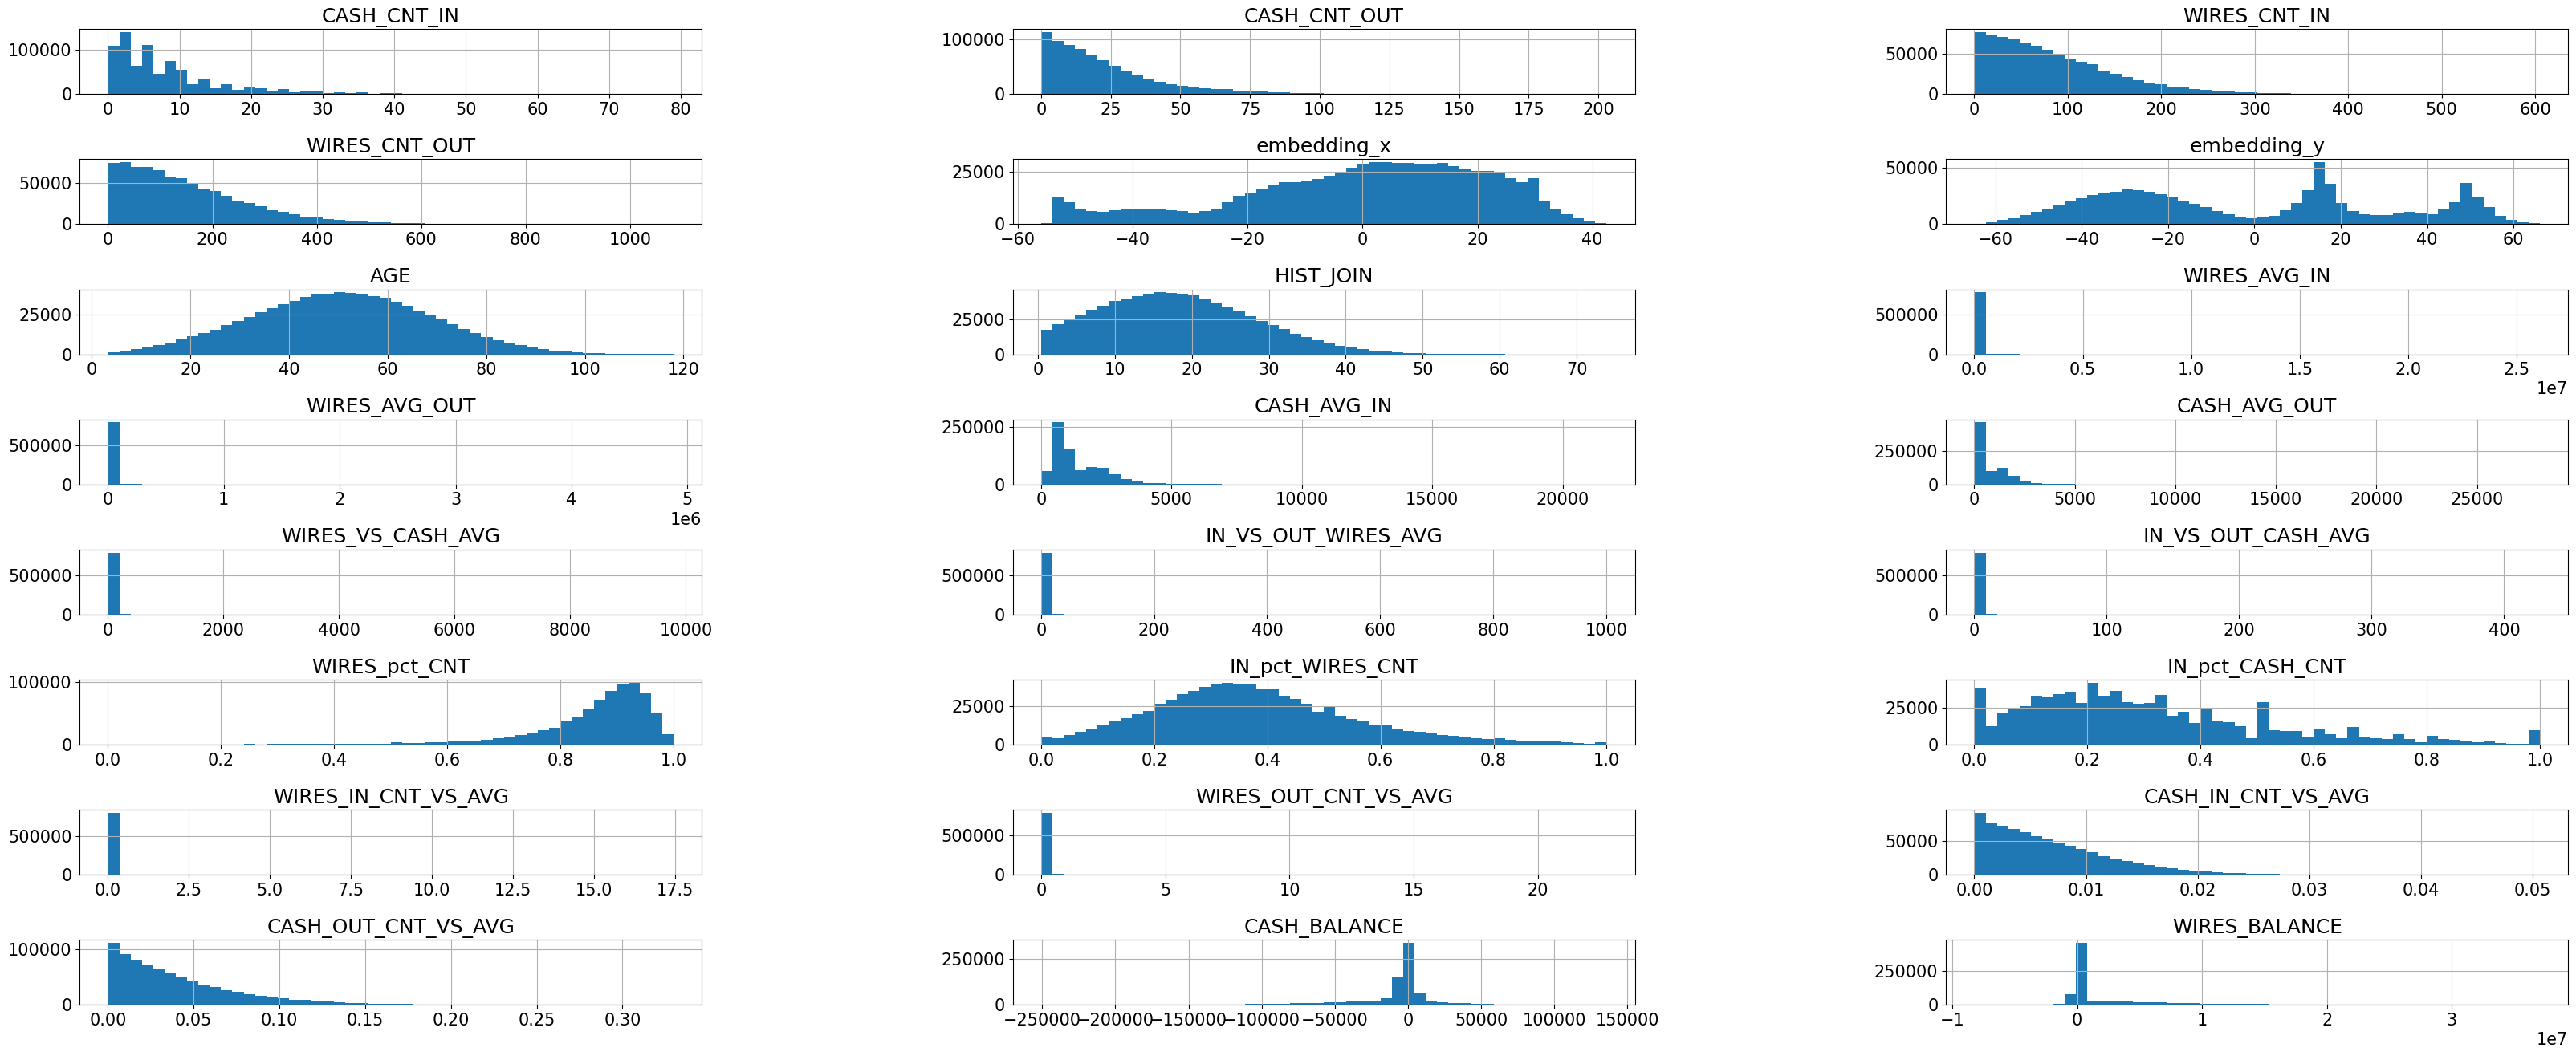

In [ ]:
X_train.hist(bins = 50, layout = (10, int(X_train.select_dtypes(include = np.number).shape[1] / 10) + 1), figsize= (40,20))
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### Categorical
- These categorical features have > 90% in 1 category
  - RES_CNTRY_CA
  - CNTRY_OF_INCOME_CA
  - PEP_FL
  - COUNTRY_RISK_INCOME
  - COUNTRY_RISK_RESIDENCY

In [ ]:
# category columns
X_train.describe(include='category')

GENDER occupation_risk  RES_CNTRY_CA  CNTRY_OF_INCOME_CA  PEP_FL  \
count   799378          794772        799883              799883  799883   
unique       2               3             2                   2       2   
top     Female             Low             1                   1       0   
freq    438772          512539        788377              790710  721934   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  MISSING_NAME  DIFF_CNTRY  \
count               799883                 799883        799883      799883   
unique                   3                      3             2           2   
top                    Low                    Low             0           0   
freq                797115                 791940        799349      780056   

        DATA_ENTRY_ERROR  
count             799883  
unique                 2  
top                    0  
freq              749639

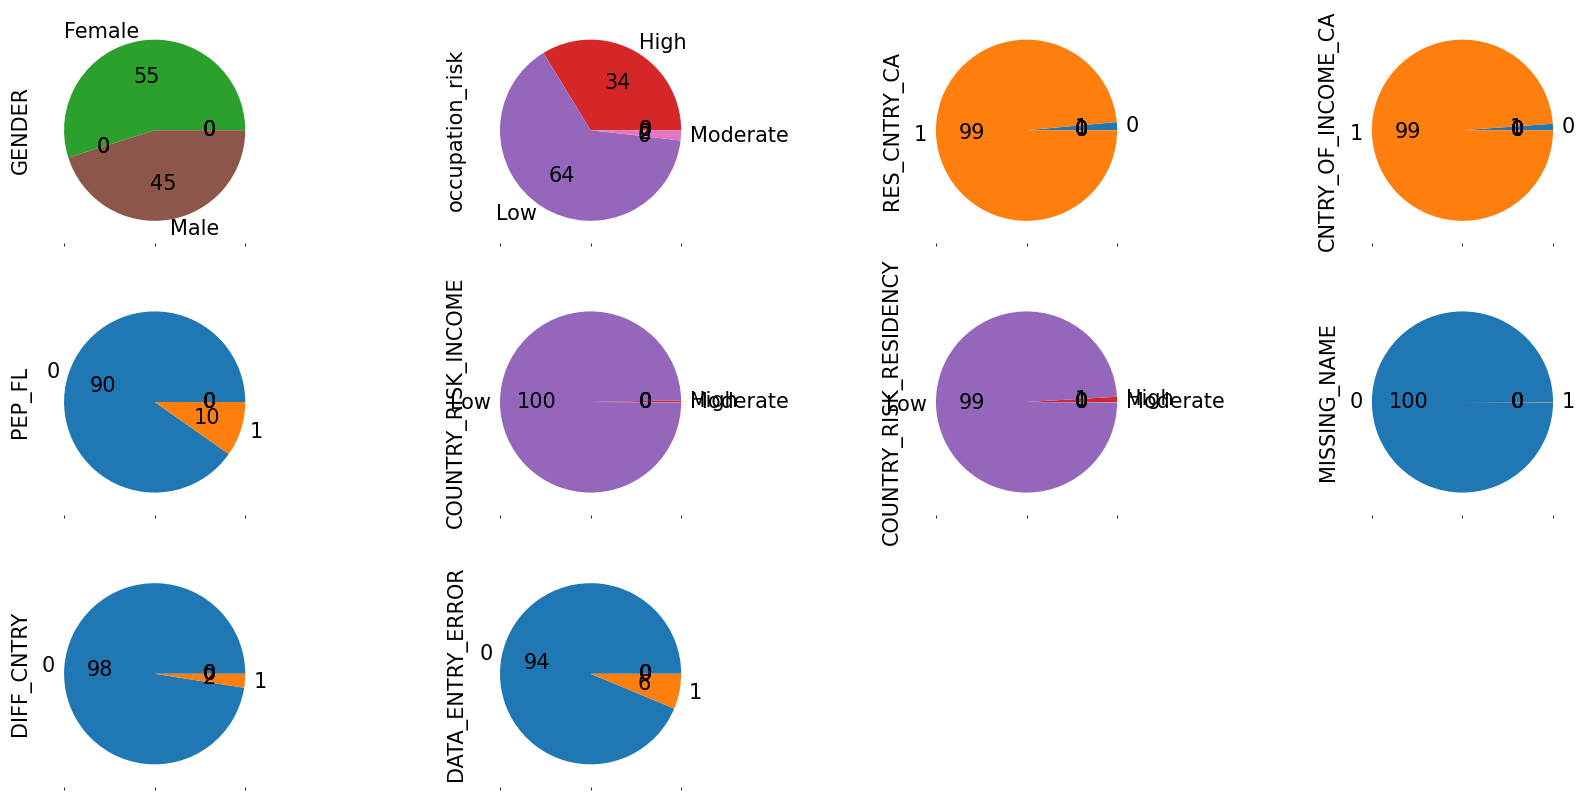

In [ ]:
X_train.select_dtypes(include = 'category').apply(lambda x: x.value_counts(normalize=True)).\
plot(kind = 'pie', subplots = True, autopct='%.0f', layout = (3,4), figsize = (20, 10), legend = False)
plt.subplots_adjust(wspace = 0.8)
plt.show()

### Class imbalance = 0.005% = 5 / 100_000

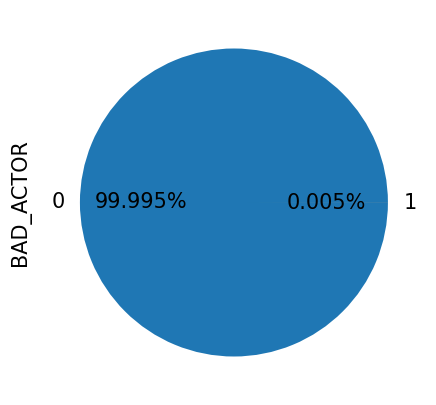

In [ ]:
y_train.value_counts(normalize=True).plot(kind = 'pie', autopct='%.3f%%', figsize = (5, 5), legend = False)
plt.show()

## Multivariate analysis



### Correlation
- numerical vs numerical
  - correlation matrix
  - sns pairplot
- categorical vs categorical
  - uncertainty coefficient (asymmetrical information)
- numerical vs categorical
  - grouped bar chart

#### Numerical

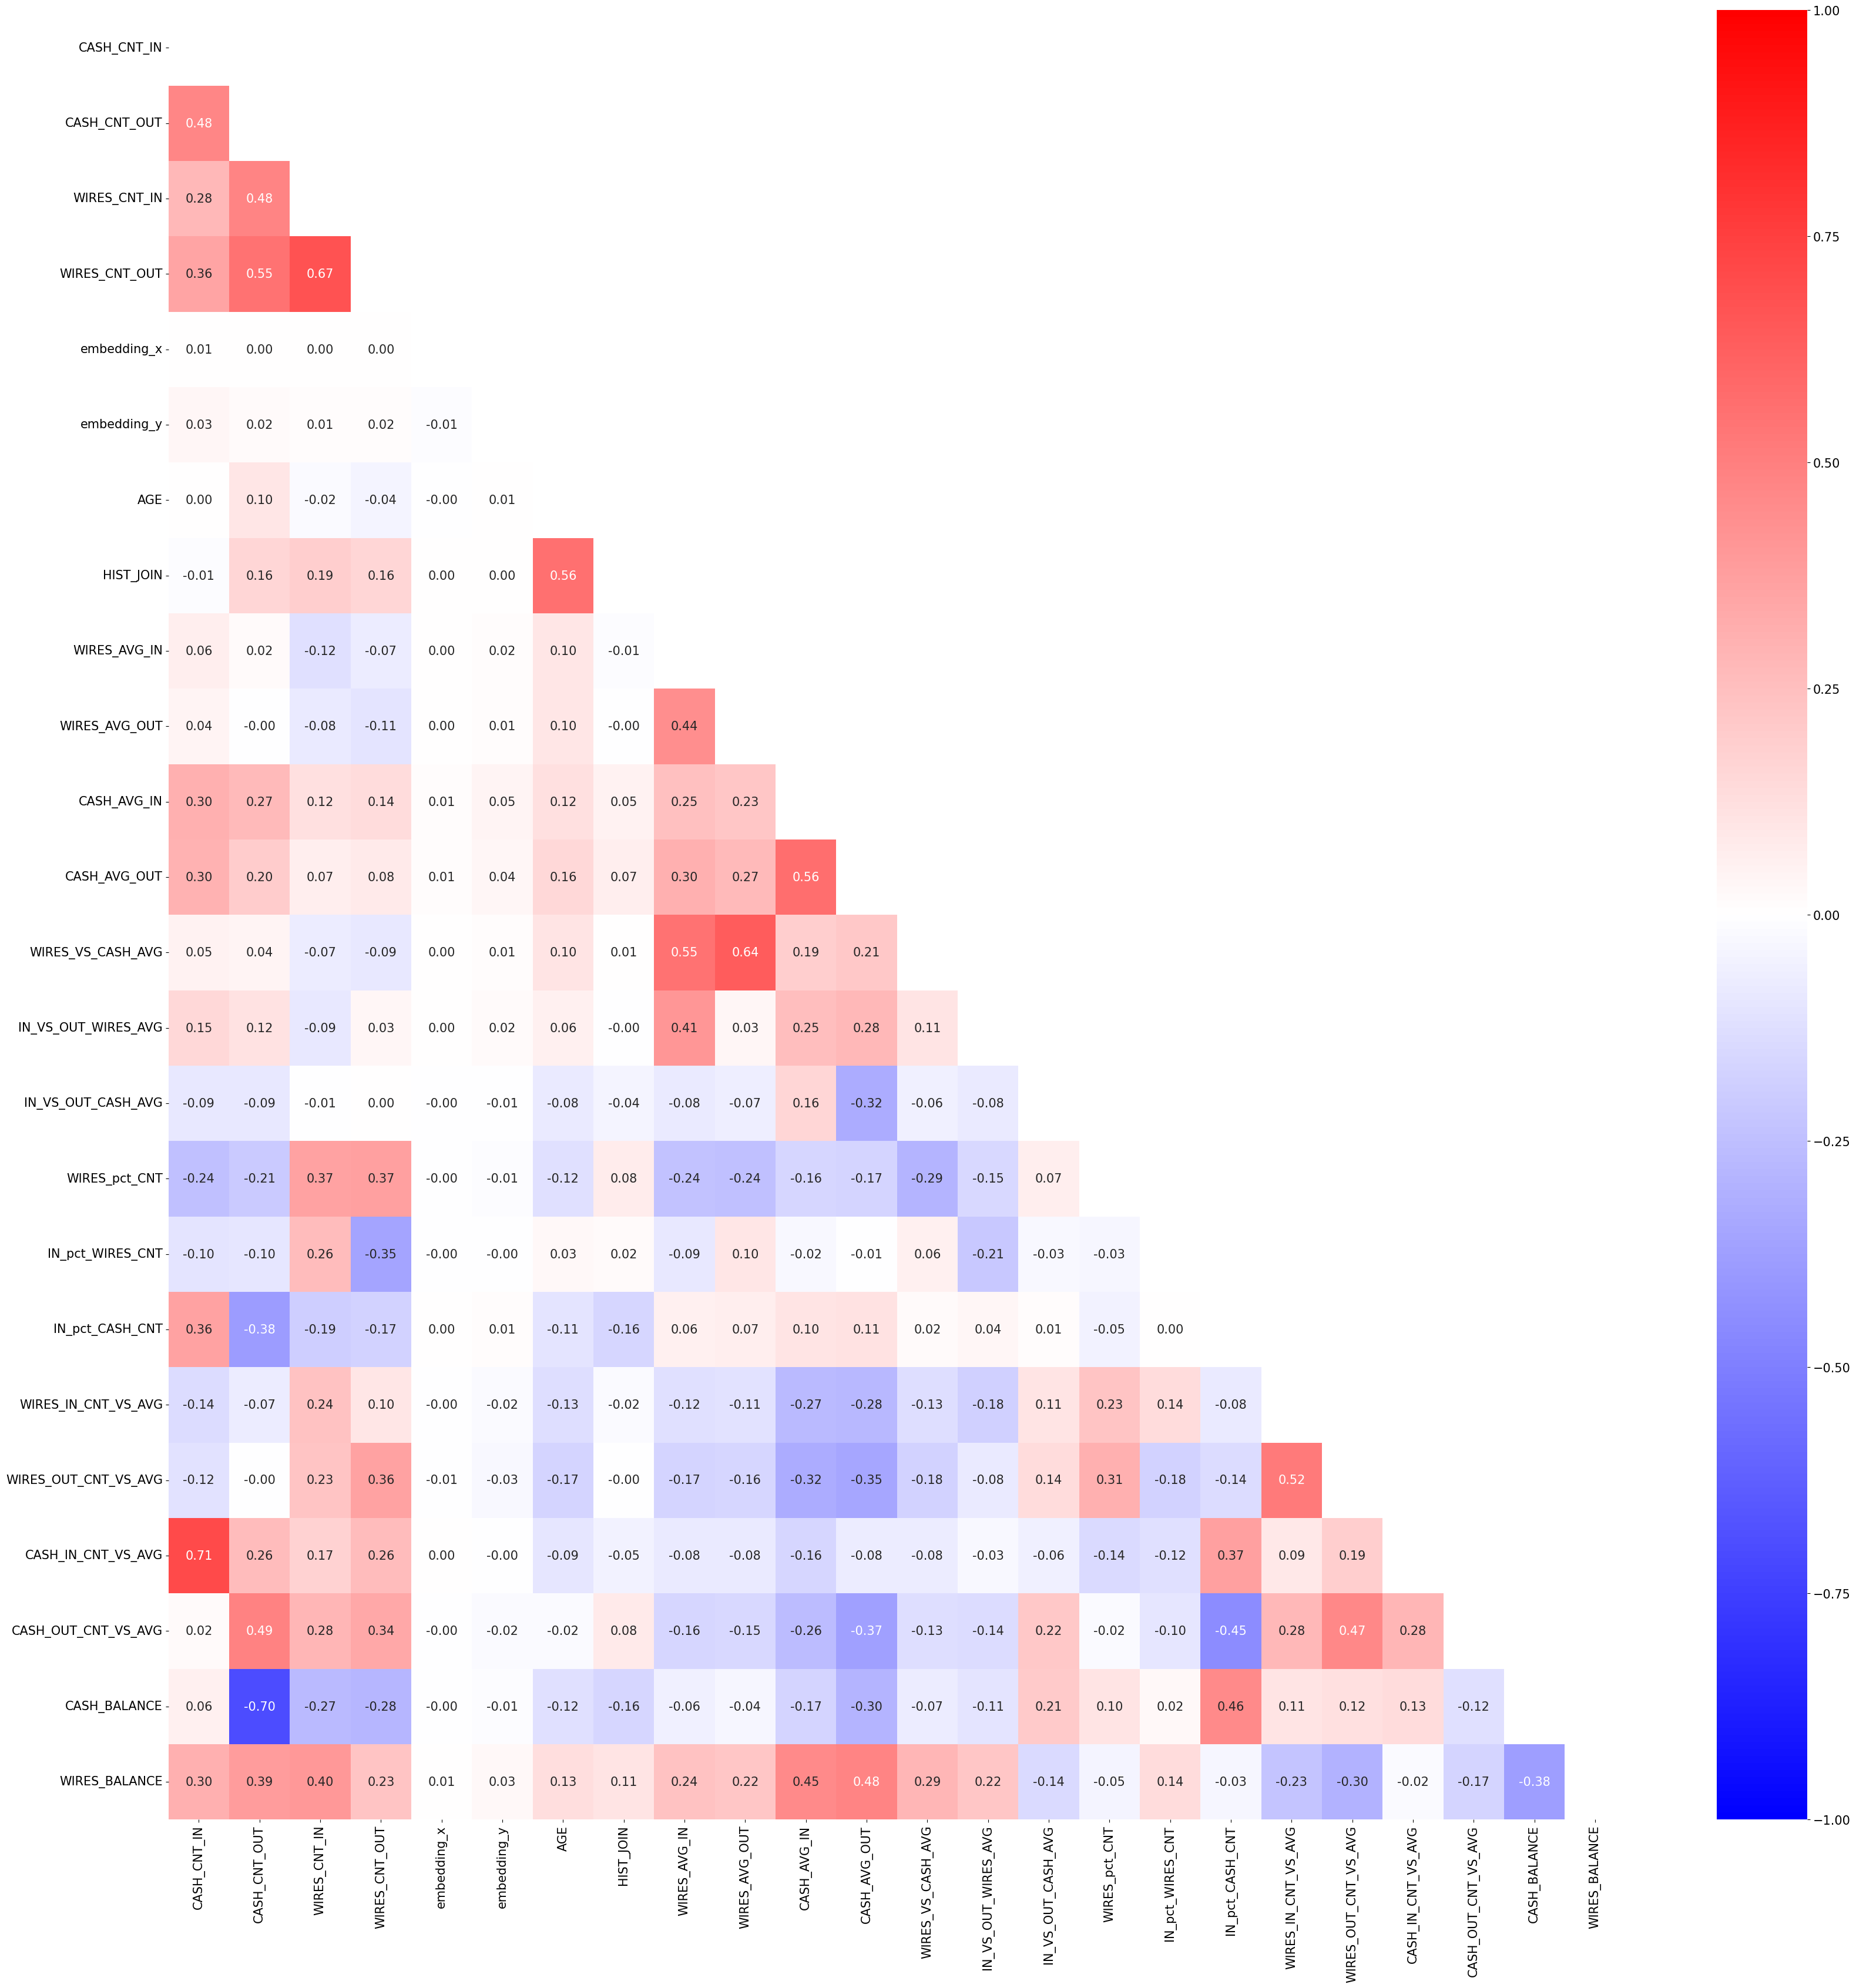

In [ ]:
corr_mat = X_train.corr()
plt.figure(figsize=(40,40))
sns.heatmap(
    corr_mat, 
    annot=True, 
    vmin=-1, vmax=1, 
    mask = np.triu(corr_mat),  # to show only lower triangle
    cmap = 'bwr',
    fmt = '.2f') 
plt.show()

#### Categorical

In [ ]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://www.kaggle.com/code/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival/notebook
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
uncertainty_coef = pd.DataFrame([(col1, col2, theil_u(train_clean[col1], train_clean[col2])) for col1, col2 in permutations(pd.concat([X_train.select_dtypes('category'), y_train], axis=1), 2)],
                                columns =['if we know', 'do we know', 'theil_U'])

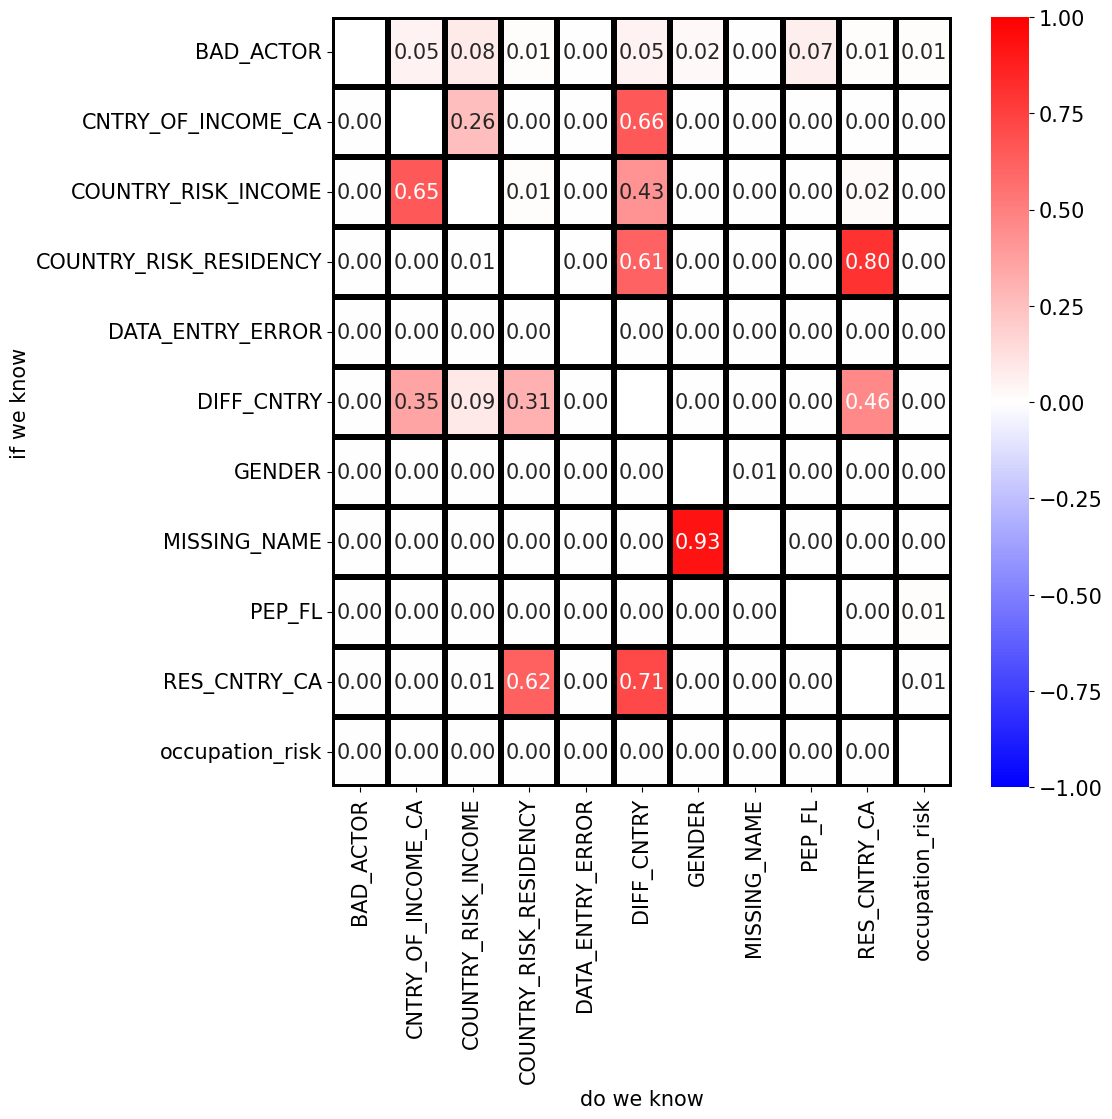

In [ ]:
uncertainty_coef = uncertainty_coef.pivot(index = 'if we know', columns = 'do we know', values = 'theil_U')
plt.figure(figsize=(10,10))
sns.heatmap(
    uncertainty_coef, 
    annot=True, 
    vmin=-1, vmax=1, 
    # mask = np.triu(corr_mat),  # asymmetrical dependence
    cmap = 'bwr',
    linewidths=4, 
    linecolor='black',
    fmt = '.2f') 
plt.show()

In [ ]:
pd.crosstab(X_train.MISSING_NAME, X_train.GENDER)

GENDER        Female    Male
MISSING_NAME                
0             438755  360594
1                 17      12

In [ ]:
pd.crosstab(X_train.COUNTRY_RISK_RESIDENCY, X_train.RES_CNTRY_CA)

RES_CNTRY_CA               0       1
COUNTRY_RISK_RESIDENCY              
Low                     3563  788377
Moderate                 560       0
High                    7383       0

### Correlation with target variable
- kde density plot with hue = target (stacked = True / False)
- hexagon plot of 2 numerical with hue = target
- numerical
  - cut into bins -> cross tab with y
- categorical 
  - cross tab with y

#### Without transformation

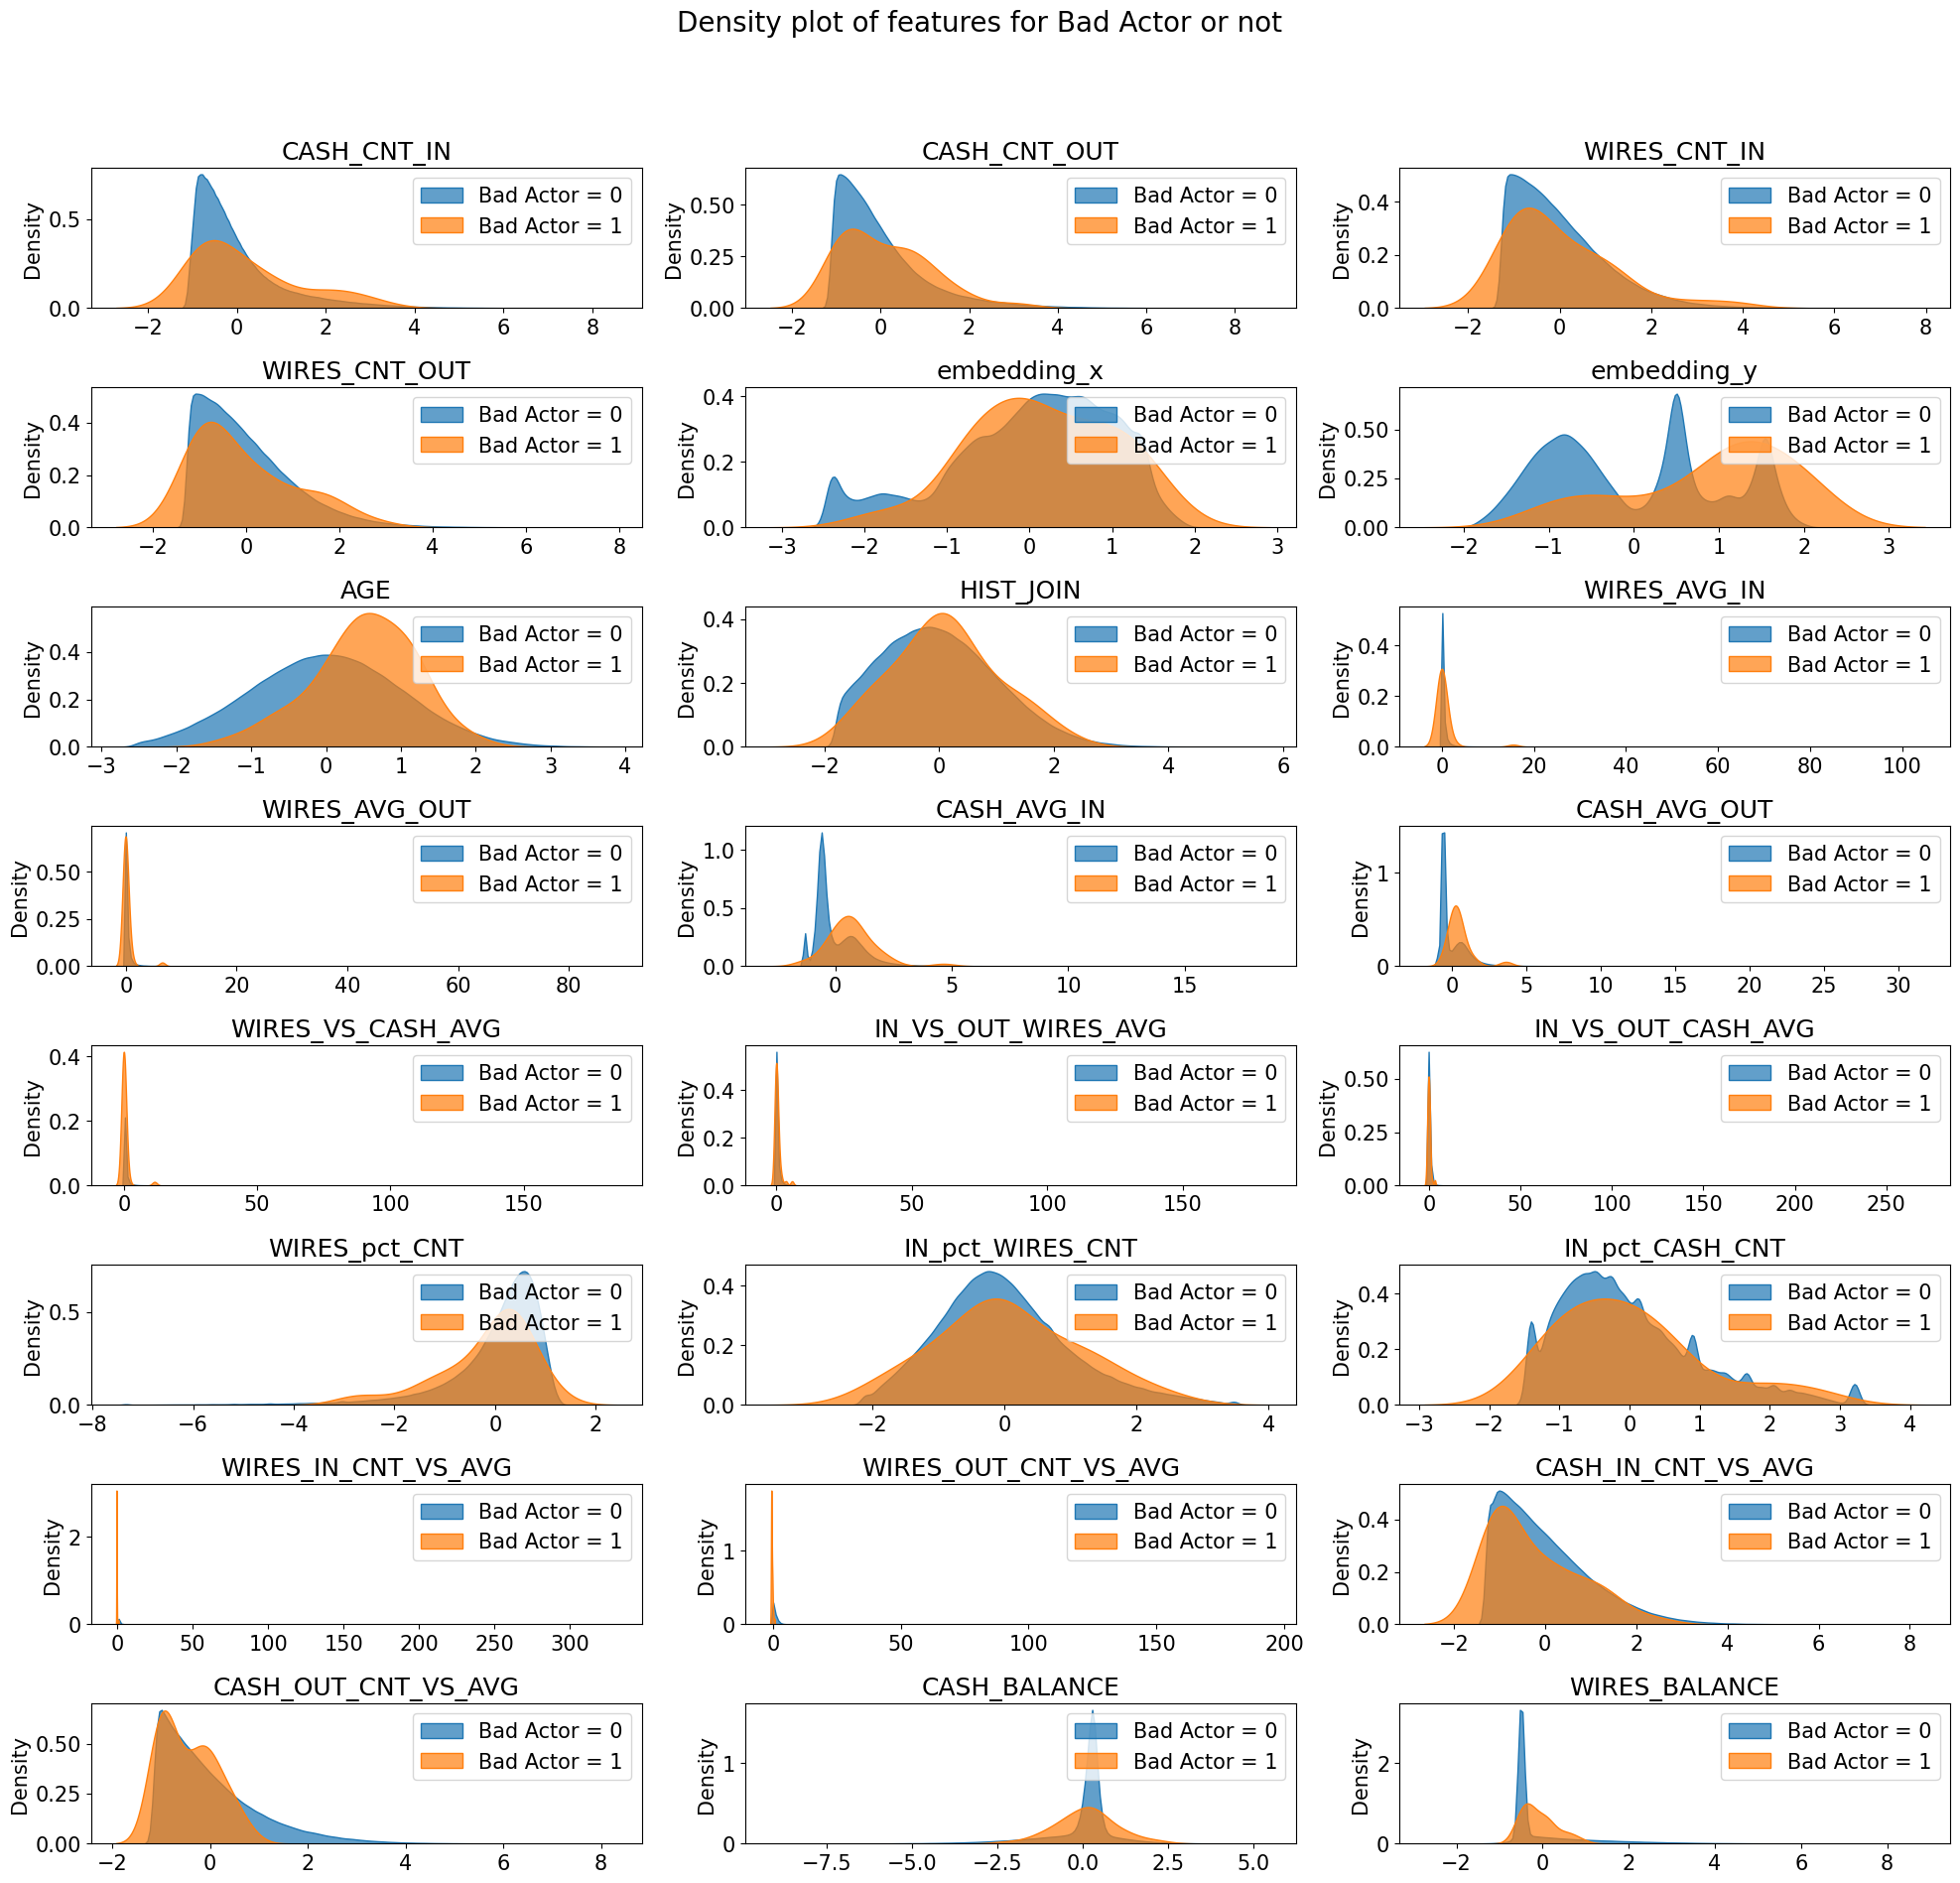

In [ ]:
# Univariate density plot by bad_actor
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

norm_clean = pd.concat([
    X_train.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for bad_actor in sorted(y_train.unique()):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['BAD_ACTOR'] == bad_actor, col], fill=True, label=f"Bad Actor = {bad_actor}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == bad_actor, col].unique()[0]:0.3f} for {col} in bad_actor {bad_actor}")
  ax.set_title(col)
  ax.legend(loc = 'upper right')
  ax.set_xlabel('')

fig.suptitle('Density plot of features for Bad Actor or not', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Normal distribution

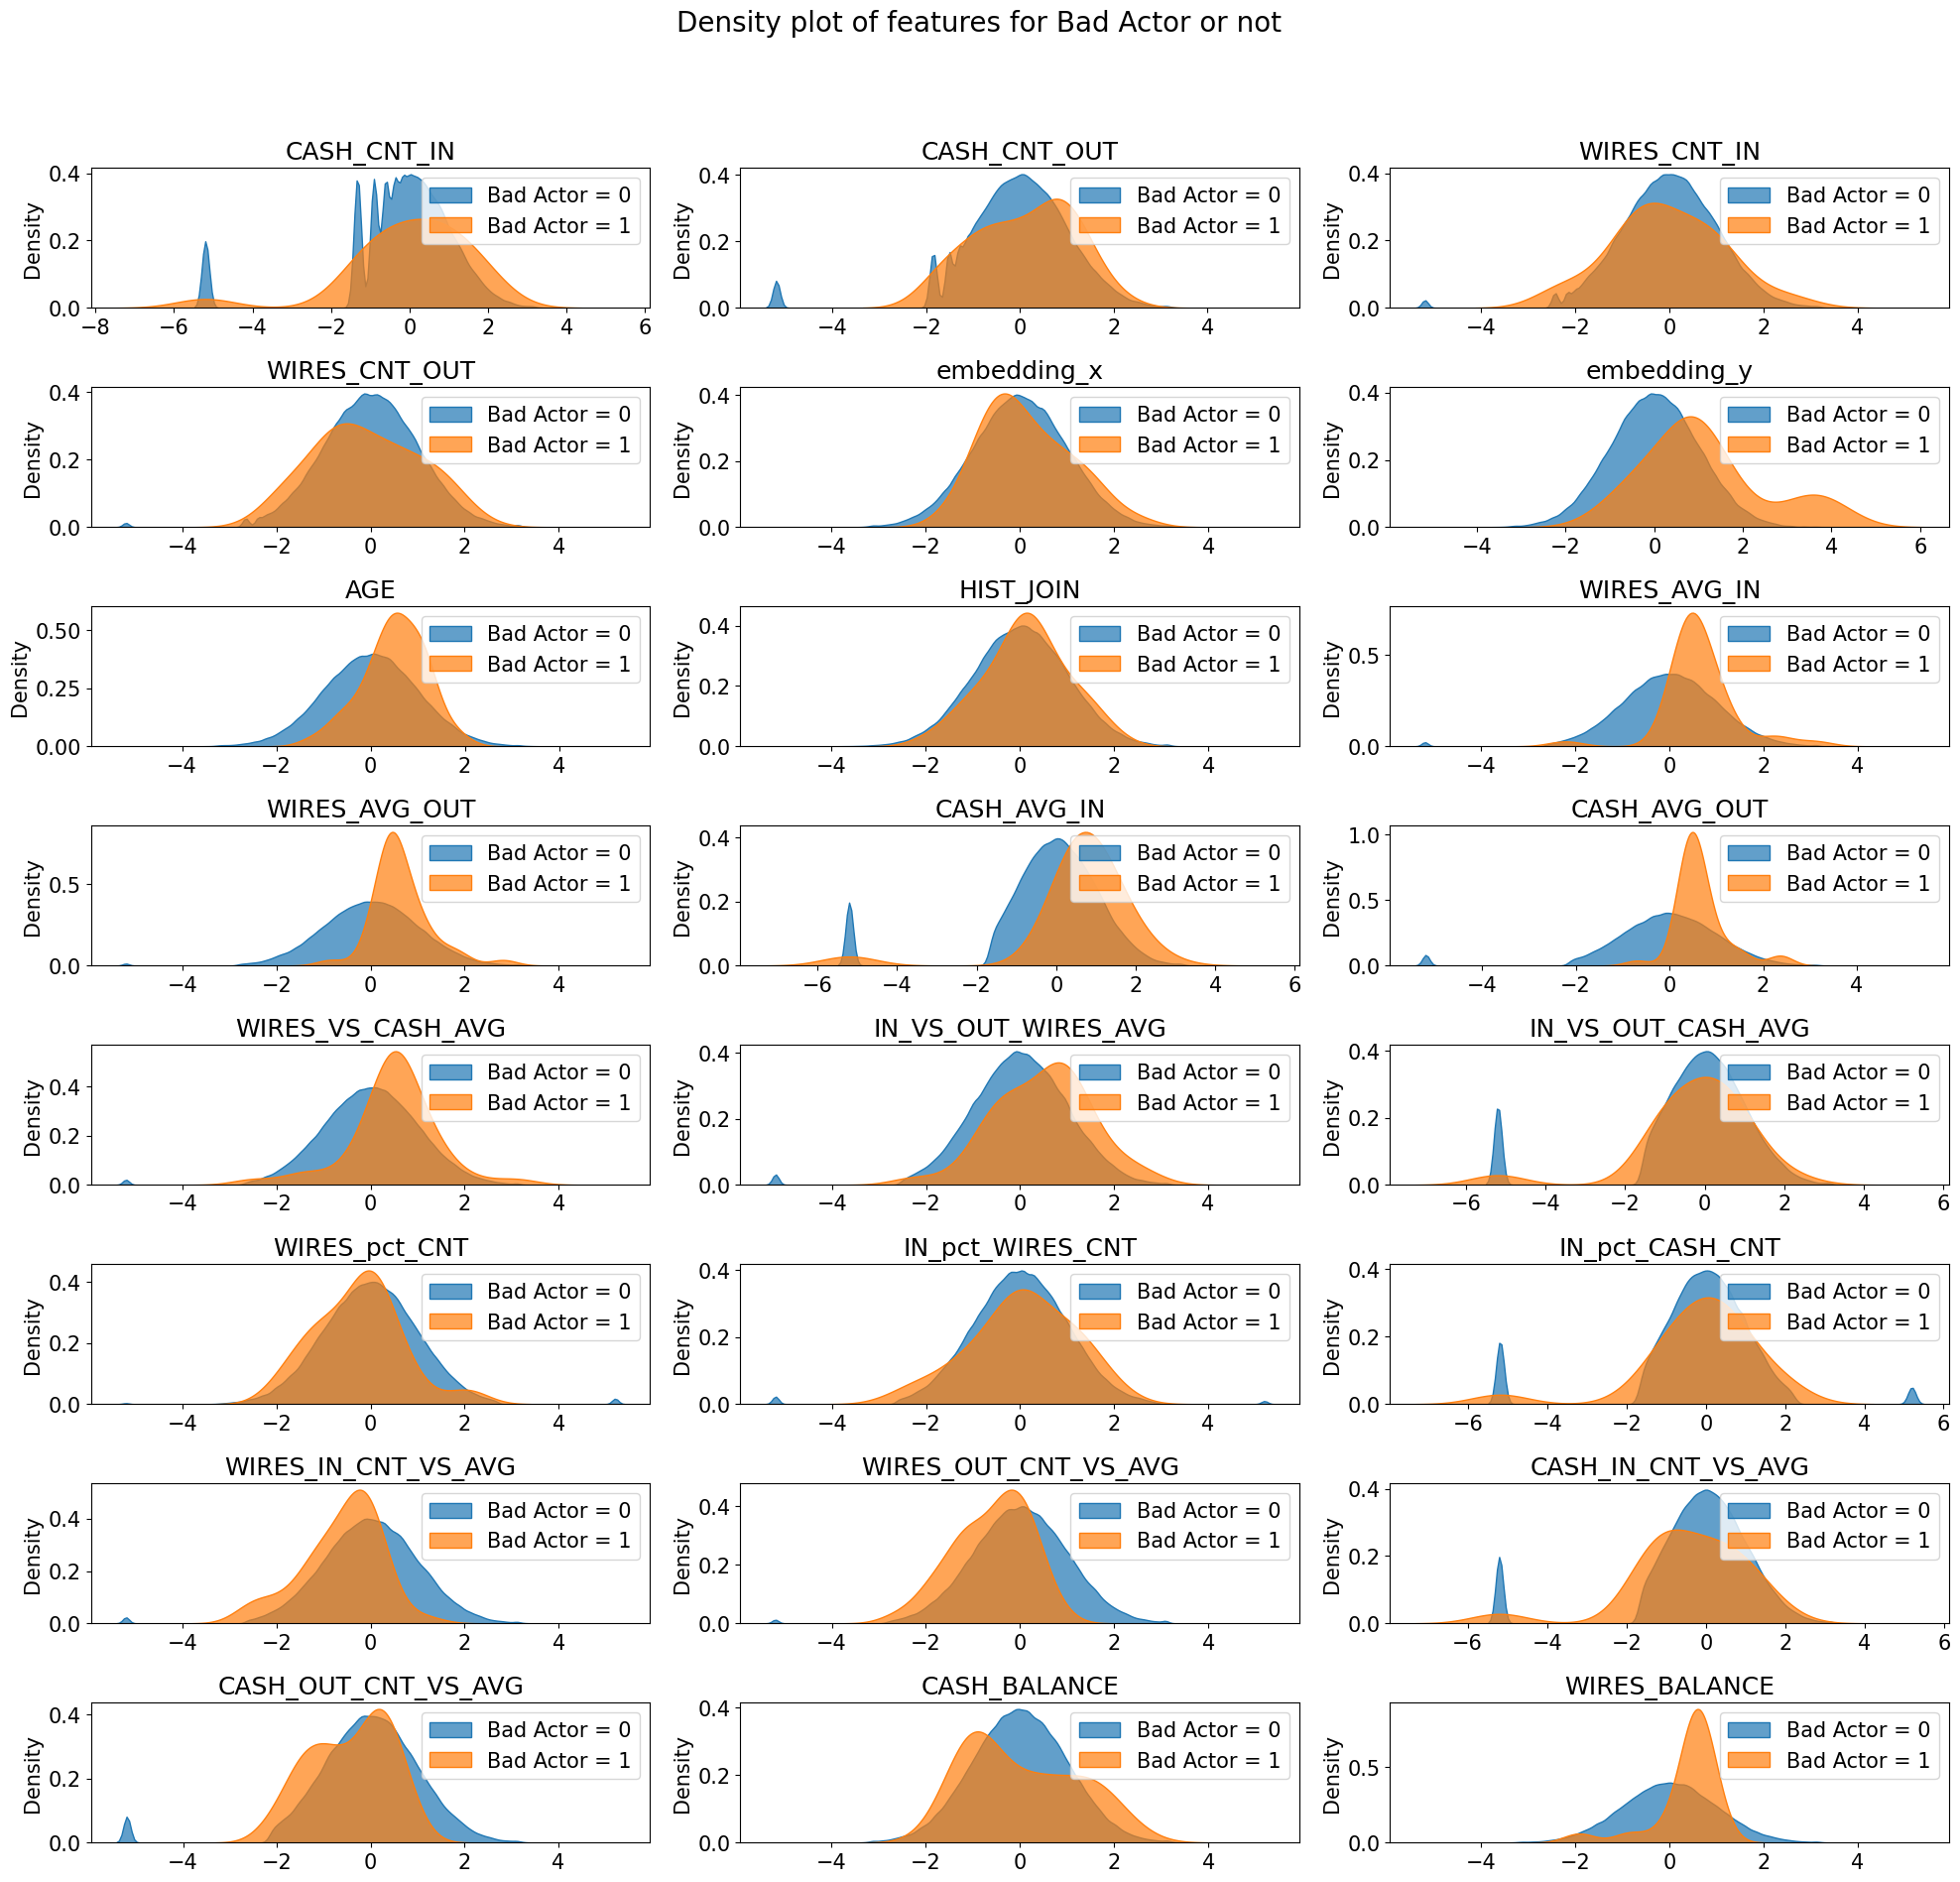

In [ ]:
# Univariate density plot by bad_actor rating
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

abcd = MyQuantileTransformer(output_distribution='normal', random_state=42).fit(X_train.select_dtypes(np.number))

norm_clean = pd.concat([
    pd.DataFrame(abcd.transform(X_train.select_dtypes(np.number)),
                 columns = abcd.get_feature_names_out()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for bad_actor in sorted(y_train.unique()):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['BAD_ACTOR'] == bad_actor, col], fill=True, label=f"Bad Actor = {bad_actor}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == bad_actor, col].unique()[0]:0.3f} for {col} in bad_actor {bad_actor}")
  ax.set_title(col)
  ax.legend(loc = 'upper right')
  ax.set_xlabel('')

fig.suptitle('Density plot of features for Bad Actor or not', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Uniform distribution

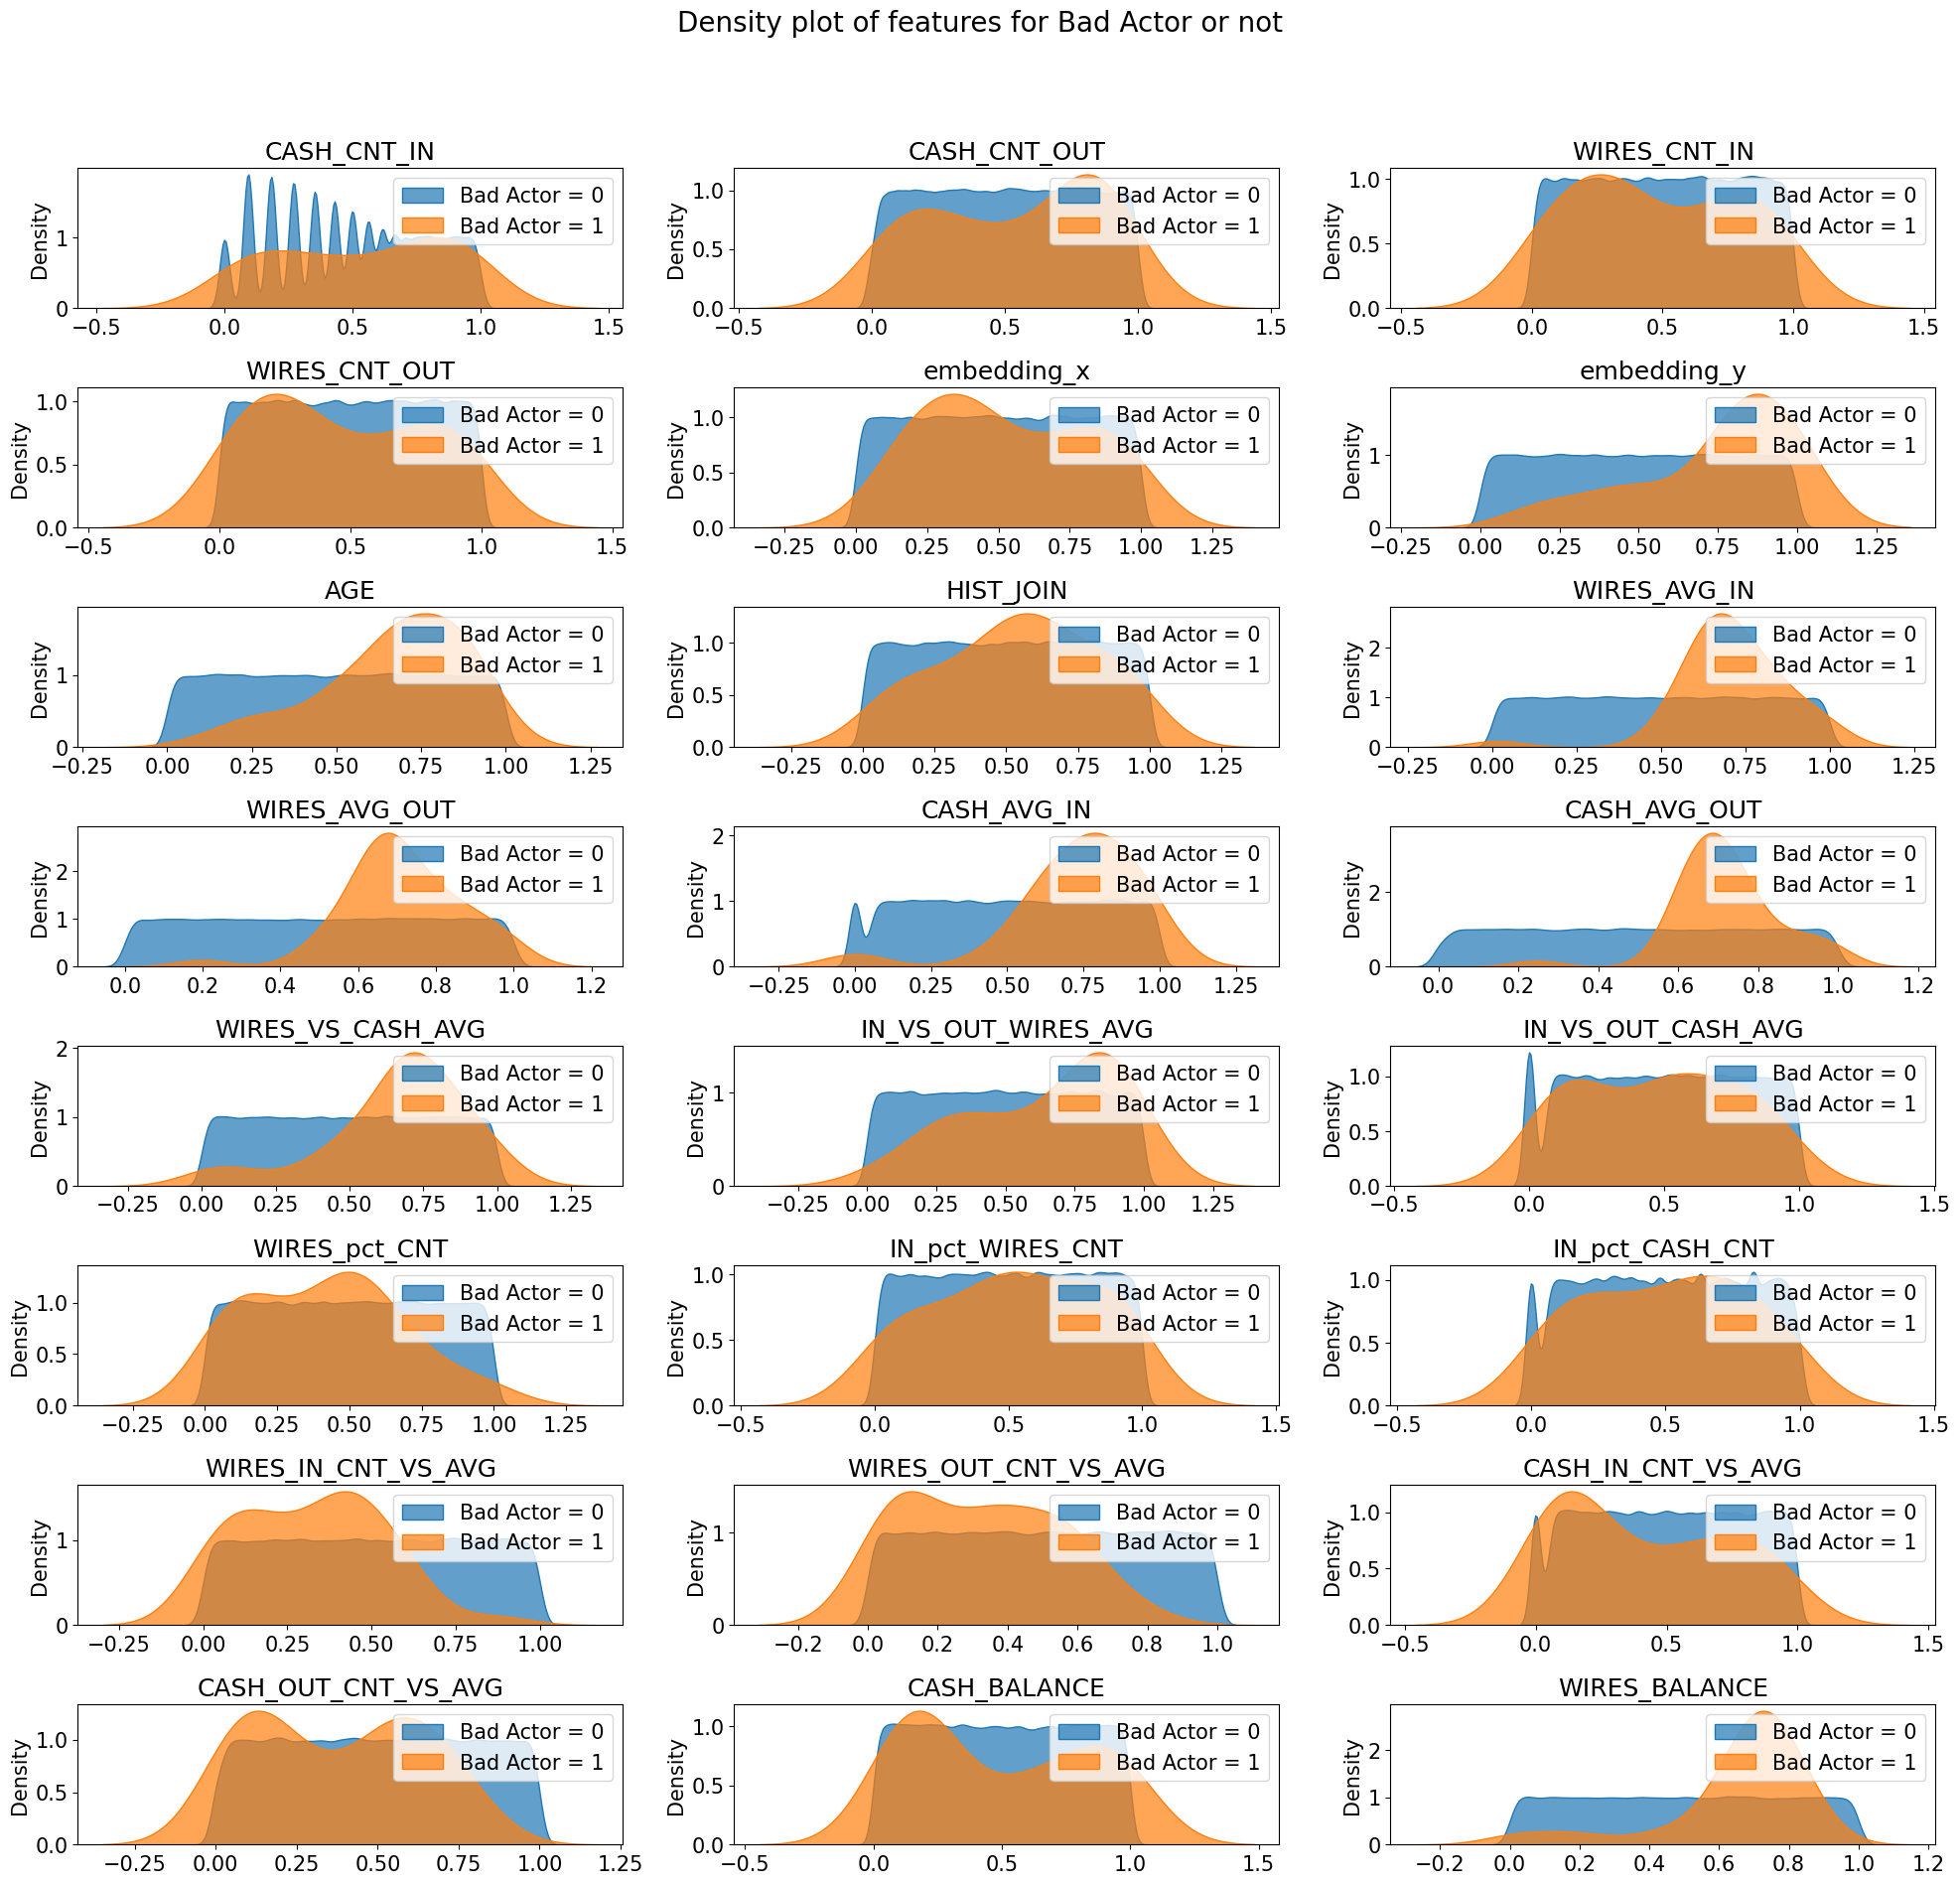

In [ ]:
# Univariate density plot by bad_actor rating
fig, axes = plt.subplots(8,int((X_train.select_dtypes(np.number).shape[1] - 2) // 8) + 1,figsize=(20,20))

abcd = MyQuantileTransformer(output_distribution='uniform', random_state=42).fit(X_train.select_dtypes(np.number))

norm_clean = pd.concat([
    pd.DataFrame(abcd.transform(X_train.select_dtypes(np.number)),
                 columns = abcd.get_feature_names_out()),
    y_train], axis = 1)

for ax, col in zip(axes.flatten(), X_train.select_dtypes(np.number).columns):
  for bad_actor in sorted(y_train.unique()):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['BAD_ACTOR'] == bad_actor, col], fill=True, label=f"Bad Actor = {bad_actor}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == bad_actor, col].unique()[0]:0.3f} for {col} in bad_actor {bad_actor}")
  ax.set_title(col)
  ax.legend(loc = 'upper right')
  ax.set_xlabel('')

fig.suptitle('Density plot of features for Bad Actor or not', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### pairplot

In [ ]:
# randomly select 10**4 samples for faster plotting with probability of being chosen based on 1 / class % split
class_weighted_sample = pd.concat([
    X_train.select_dtypes(np.number),
    y_train], 
    axis = 1).sample(10**2, weights = 1/(y_train.to_frame().groupby('BAD_ACTOR').BAD_ACTOR.transform('size') / y_train.shape[0]))

sns.pairplot(class_weighted_sample,
             # specify off-diagonal cells to be scatter
             kind='scatter',
             hue = 'BAD_ACTOR',
             # specify diagonal to be histogram, or "kde"
             diag_kind='kde',
             plot_kws={'alpha': 0.2},
             corner=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# randomly select samples for faster plotting with probability based on class % split
class_weighted_sample_Q = pd.concat([
  pd.DataFrame(
    QuantileTransformer(output_distribution='normal').fit_transform(class_weighted_sample.drop(columns=['BAD_ACTOR'])),
    columns = class_weighted_sample.drop(columns=['BAD_ACTOR']).columns),
  class_weighted_sample.BAD_ACTOR.reset_index(drop=True)
], axis = 1)

sns.pairplot(class_weighted_sample_Q,
             # specify off-diagonal cells to be scatter
             kind='scatter',
             hue = 'BAD_ACTOR',
             # specify diagonal to be histogram, or "kde"
             diag_kind='kde',
             plot_kws={'alpha': 0.2},
             corner=True)

Output hidden; open in https://colab.research.google.com to view.

#### categorical

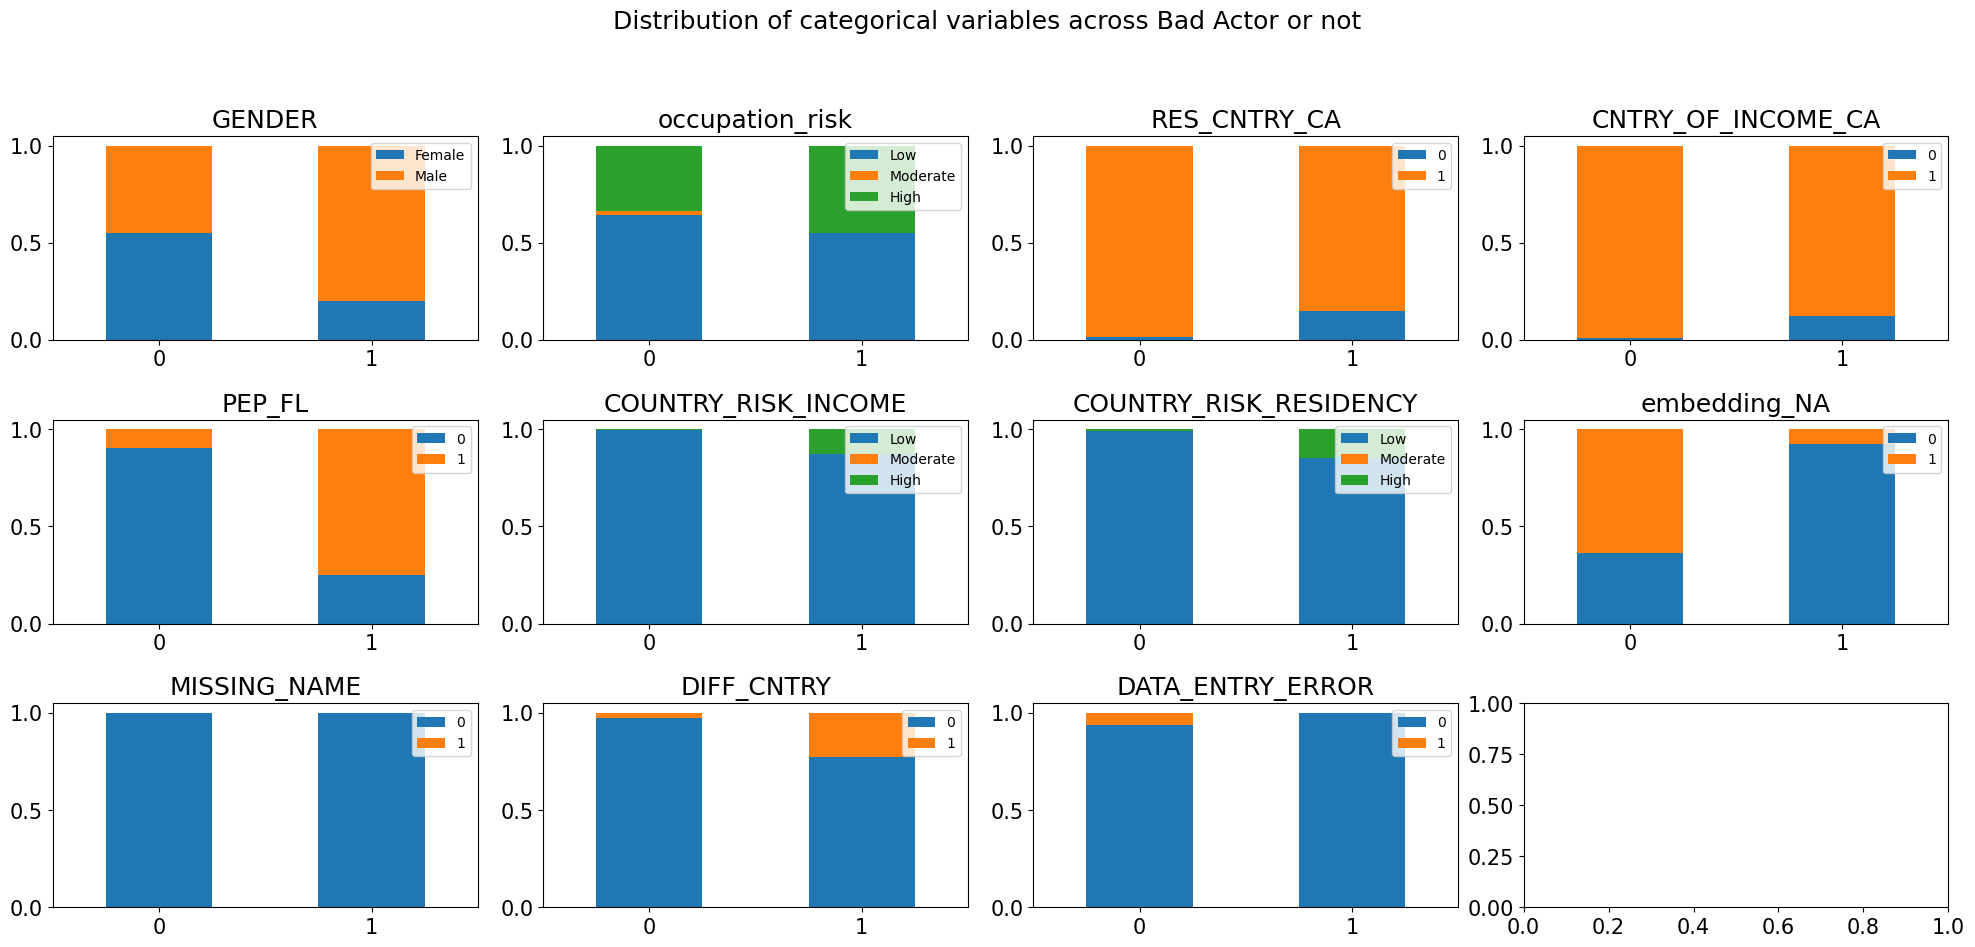

In [ ]:
# plot categorical variables
fig, axes = plt.subplots(3,4, figsize = (20,10))
for col, ax in zip(X_train.select_dtypes(include = ['category']), axes.flatten()):
  pd.crosstab(y_train, X_train[col], normalize = 'index').plot(kind = 'bar', stacked = True, title = col, legend=True, ax = ax)
  ax.set_xlabel('')
  ax.set_xticklabels(['0', '1'], rotation = 0)
  ax.legend(loc = 'upper right', prop={'size': 10})
plt.subplots_adjust(hspace=1, wspace=0.3)
plt.suptitle(f'Distribution of categorical variables across Bad Actor or not')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data preparation

## Missing values
- how are they represented, where do they occur, and 
  - occupation_riks and HIST_JOIN seems to appear at random
  - GENDER is missing when NAME is missing too
- how common are they?
  - not very common c.1%
- msno matrix
  - minimum complete columns = 35 columns
  - maximum = 37 columns
- missingness vs observed values
- missingness in GENDER, occupation risk
  - When opening an account, the client refuses or tries to avoid providing information required by the financial institution

In [ ]:
# count of missingness
X_train.isna().sum().sort_values(ascending=False).to_frame().T

occupation_risk  HIST_JOIN  GENDER  CASH_OUT_CNT_VS_AVG  \
0             5111       3364     505                    0   

   CASH_IN_CNT_VS_AVG  WIRES_OUT_CNT_VS_AVG  WIRES_IN_CNT_VS_AVG  \
0                   0                     0                    0   

   IN_pct_CASH_CNT  IN_pct_WIRES_CNT  WIRES_AVG_OUT  IN_VS_OUT_CASH_AVG  \
0                0                 0              0                   0   

   IN_VS_OUT_WIRES_AVG  WIRES_VS_CASH_AVG  DATA_ENTRY_ERROR  CASH_AVG_OUT  \
0                    0                  0                 0             0   

   CASH_AVG_IN  CASH_BALANCE  WIRES_pct_CNT  WIRES_AVG_IN  AGE  DIFF_CNTRY  \
0            0             0              0             0    0           0   

   MISSING_NAME  embedding_y  embedding_x  WIRES_CNT_OUT  WIRES_CNT_IN  \
0             0            0            0              0             0   

   CASH_CNT_OUT  CASH_CNT_IN  COUNTRY_RISK_RESIDENCY  COUNTRY_RISK_INCOME  \
0             0            0                       0                    0   

   PEP_FL  CNTRY_OF_INCOME_CA  RES_CNTRY_CA  WIRES_BALANCE  
0       0                   0             0              0

### missingness vs RISK

<AxesSubplot:ylabel='BAD_ACTOR'>

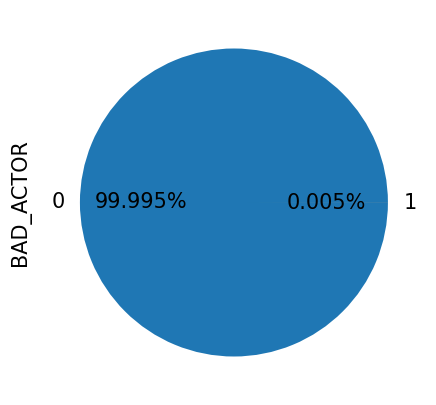

In [ ]:
# normal class %
y_train.value_counts(normalize=True).sort_index().plot(kind = 'pie', autopct='%.3f%%')

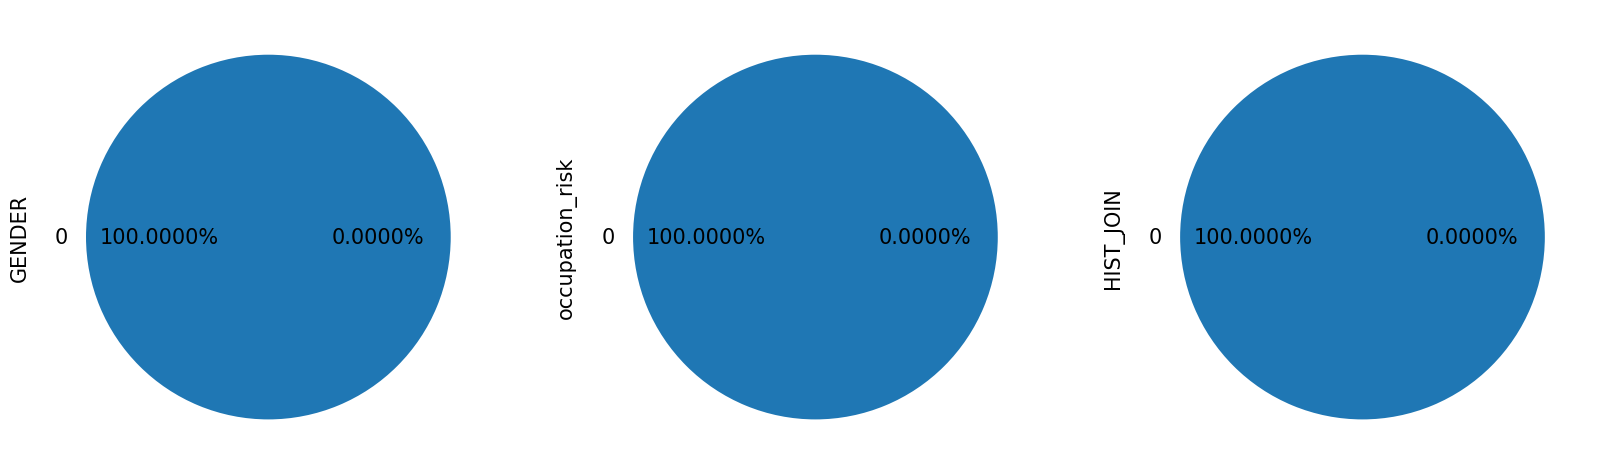

In [ ]:
# similar class % for rows with missing records
fig, axes = plt.subplots(1,sum(X_train.isna().sum() != 0), figsize = (20,10))
for i, na_col in enumerate(X_train.columns[X_train.isna().sum() != 0]):
  y_train[X_train[na_col].isna()].value_counts(normalize=True).sort_index().plot(kind = 'pie', autopct='%.4f%%', ylabel = na_col, ax = axes.flatten()[i])

plt.show()

### missingness vs Numerical

In [ ]:
# check the boxplots of those rows with NA and without NA in na_col to see if any pattern in X
def na_check(df, na_col):
  fig, axes = plt.subplots(1,2, sharex = True, sharey = False, figsize = (20,10))

  output = df.select_dtypes(np.number).apply(lambda x: (x - x.mean()) / x.std())
  
  output[df[na_col].isna()].plot(kind='box', vert=False, showfliers=False, ax = axes[0])
  output[~df[na_col].isna()].plot(kind='box', vert=False, showfliers=False, ax = axes[1])
  
  plt.suptitle(f'Distribution of records with')
  axes[0].set_title(f'NA in {na_col}')
  axes[0].axvline(2, ls = '--')
  axes[0].axvline(-2, ls = '--')
  axes[0].set_xlim(-2.5, 2.5)
  axes[1].set_title(f'non-NA in {na_col}')
  axes[1].axvline(2, ls = '--')
  axes[1].axvline(-2, ls = '--')
  axes[1].set_xlim(-2.5, 2.5)
  plt.subplots_adjust(hspace = 0.4, wspace=0.6)
  plt.show()

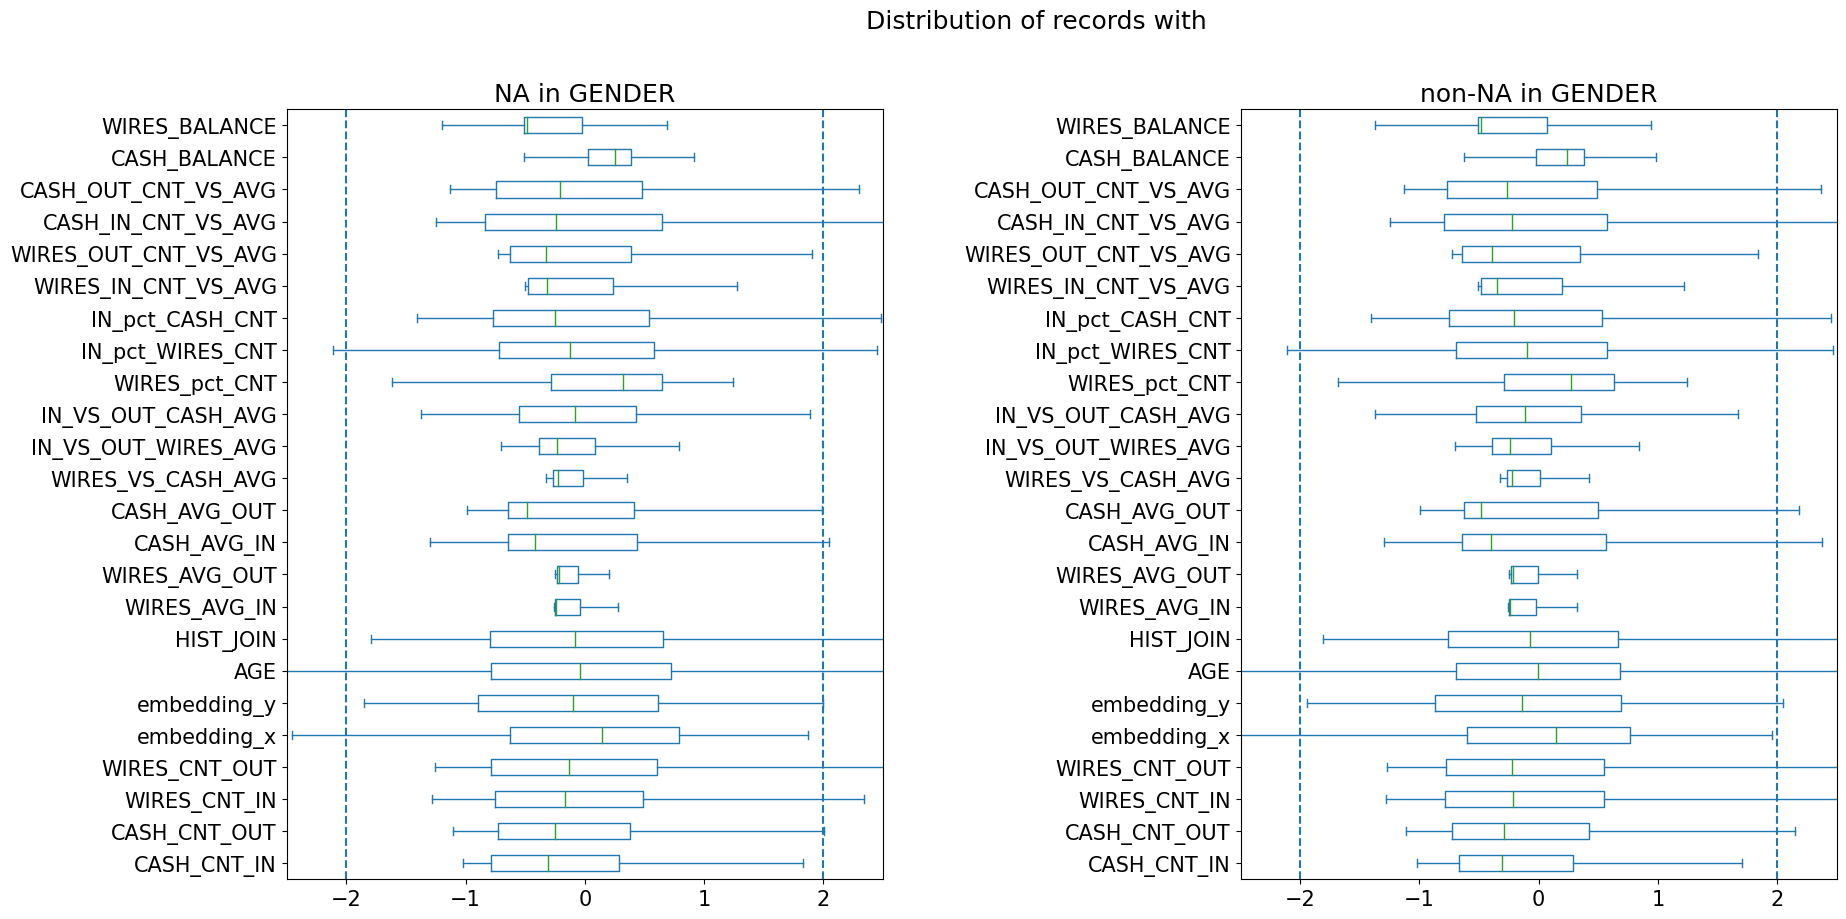

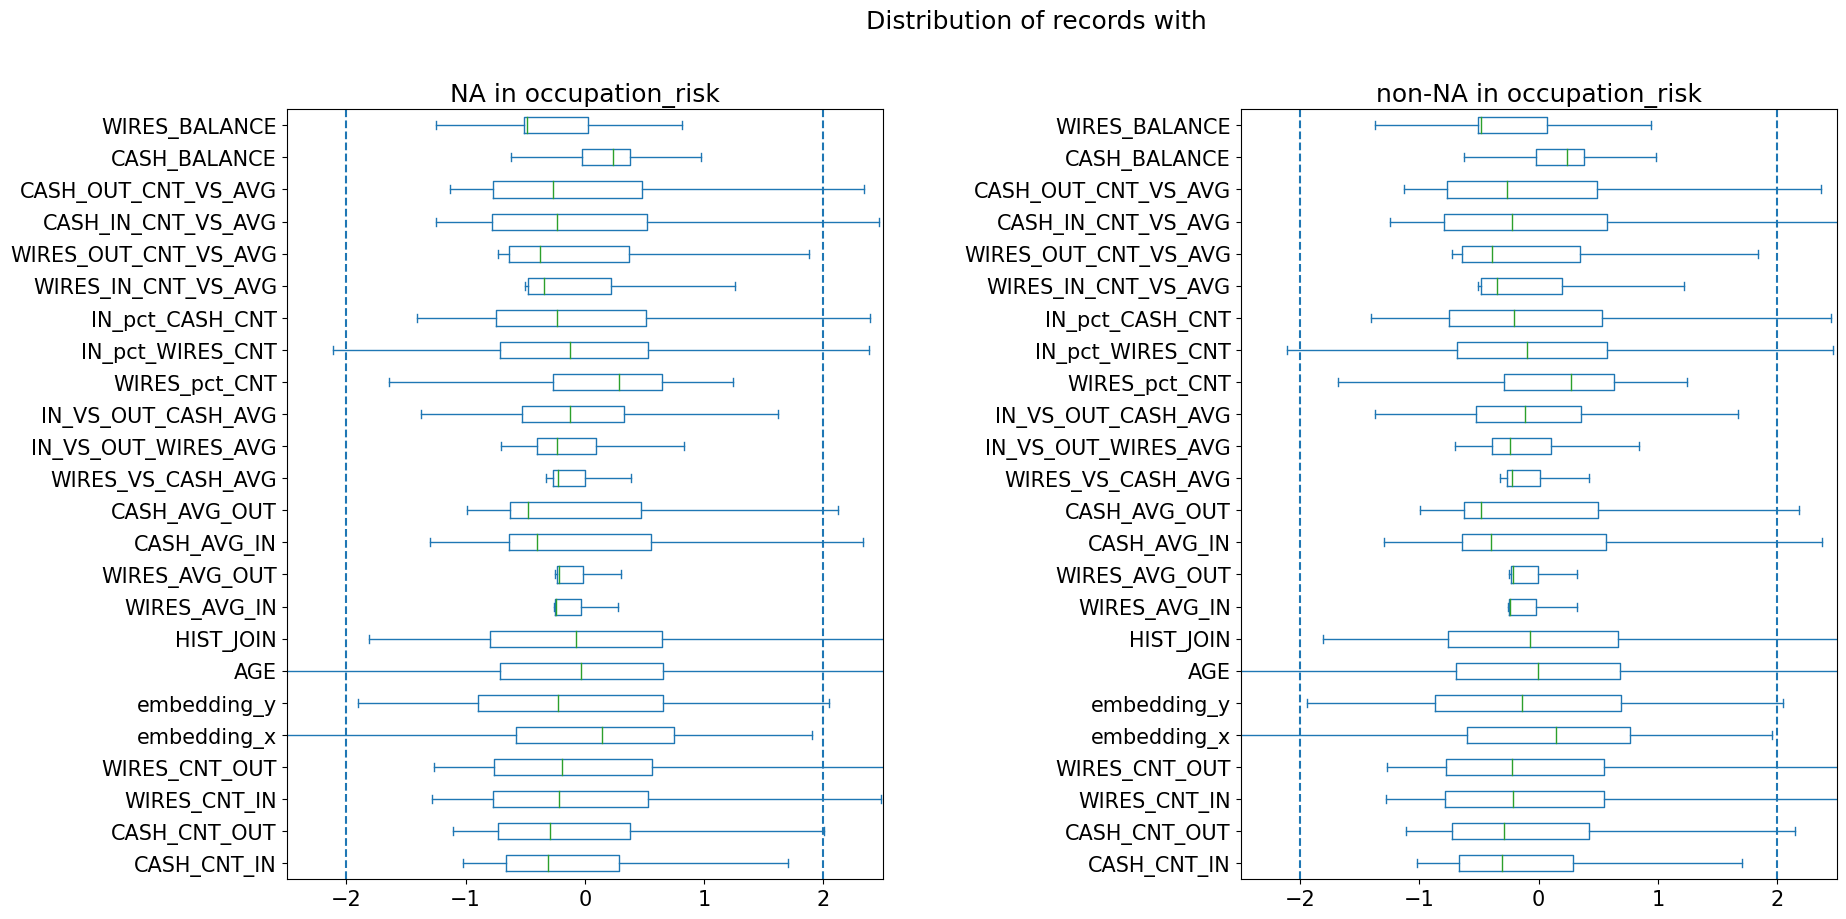

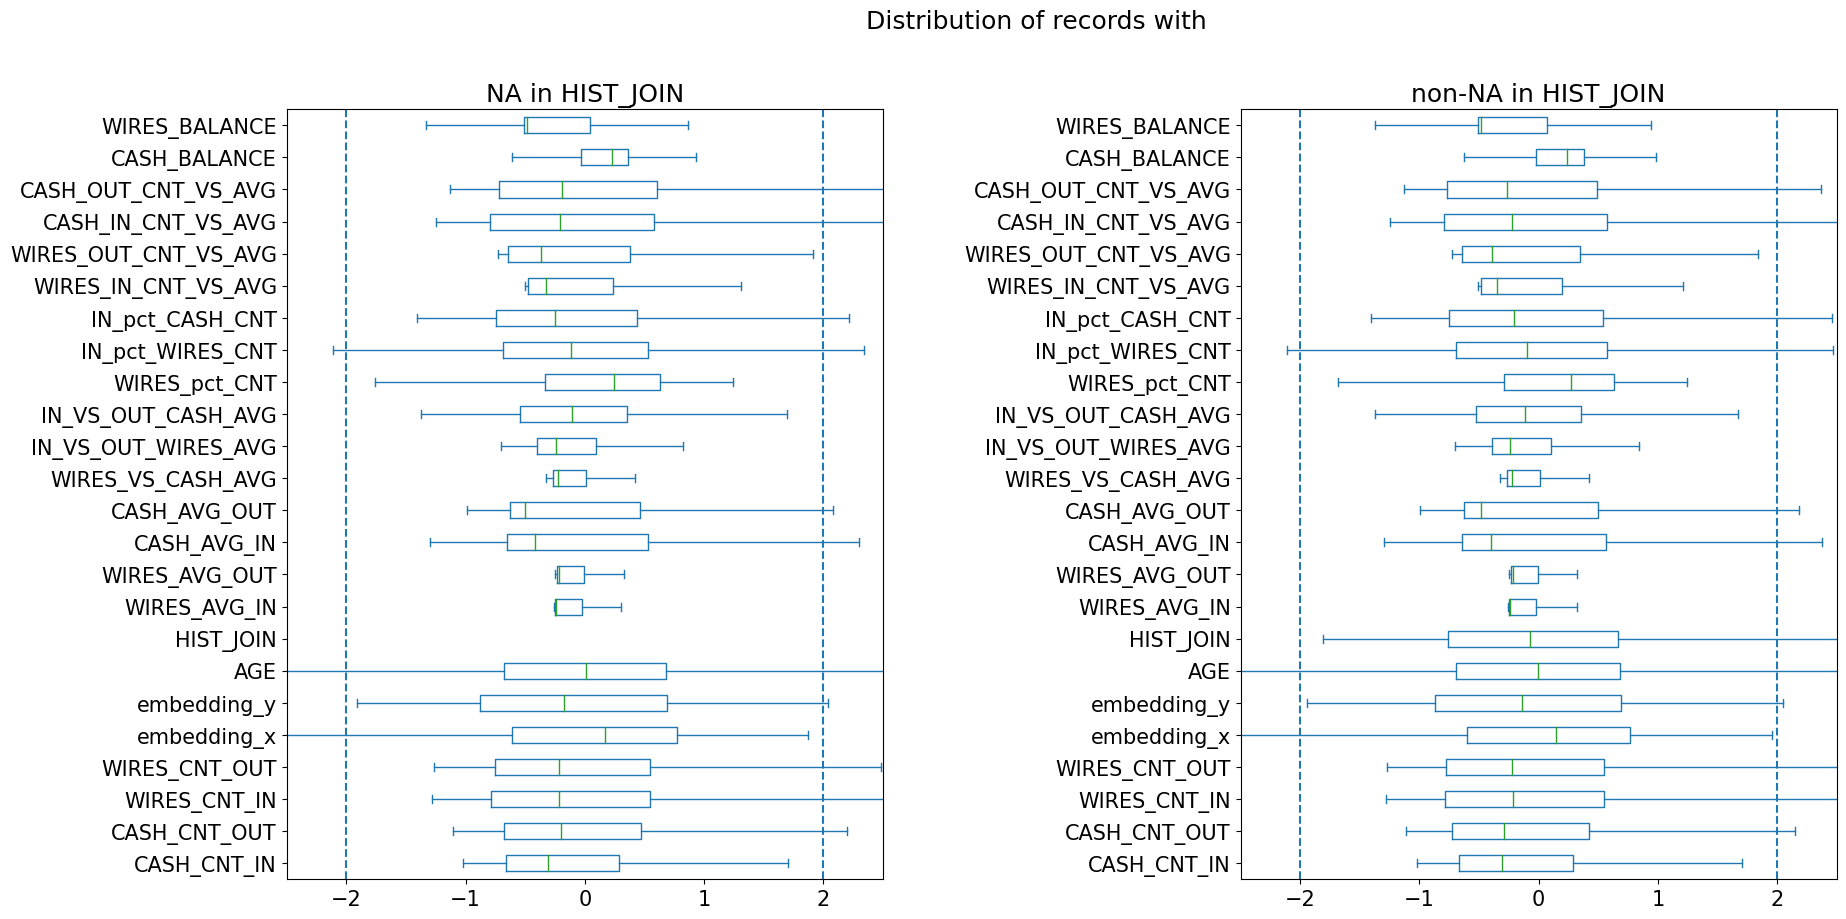

In [ ]:
for na_col in X_train.columns[X_train.isna().sum() != 0]:
  na_check(X_train, na_col)

### missingness vs Categorical

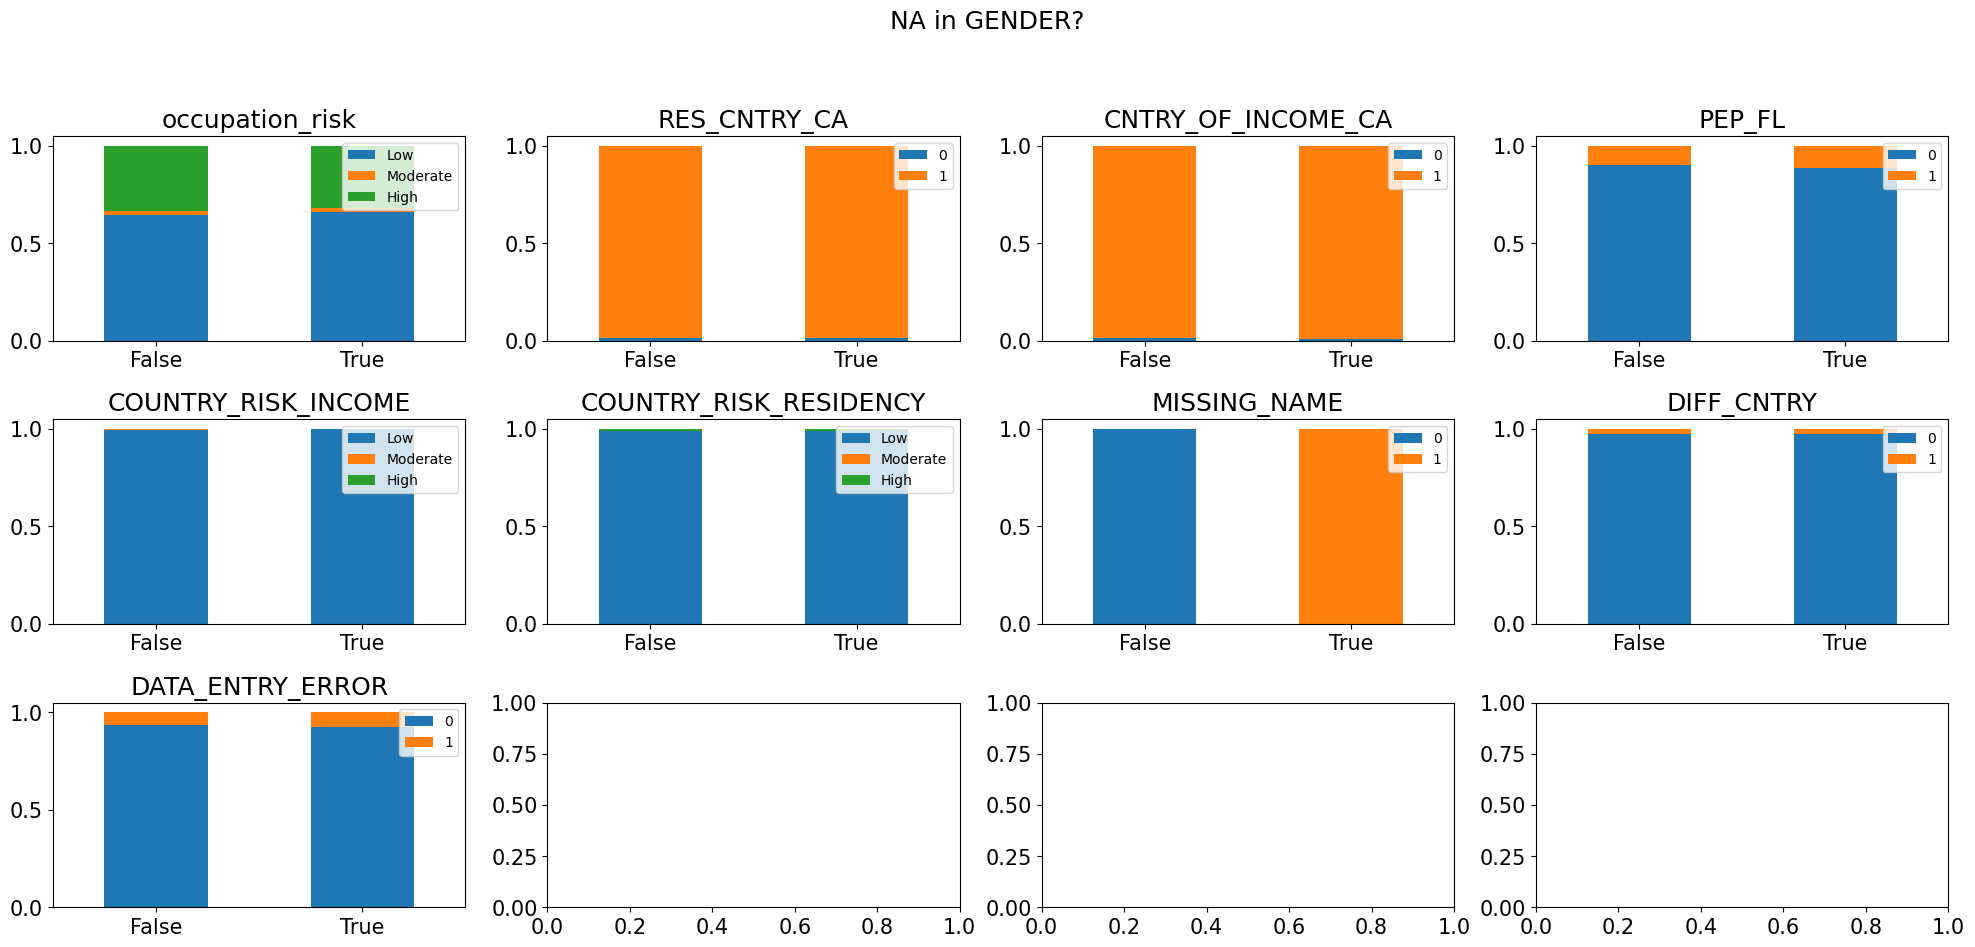

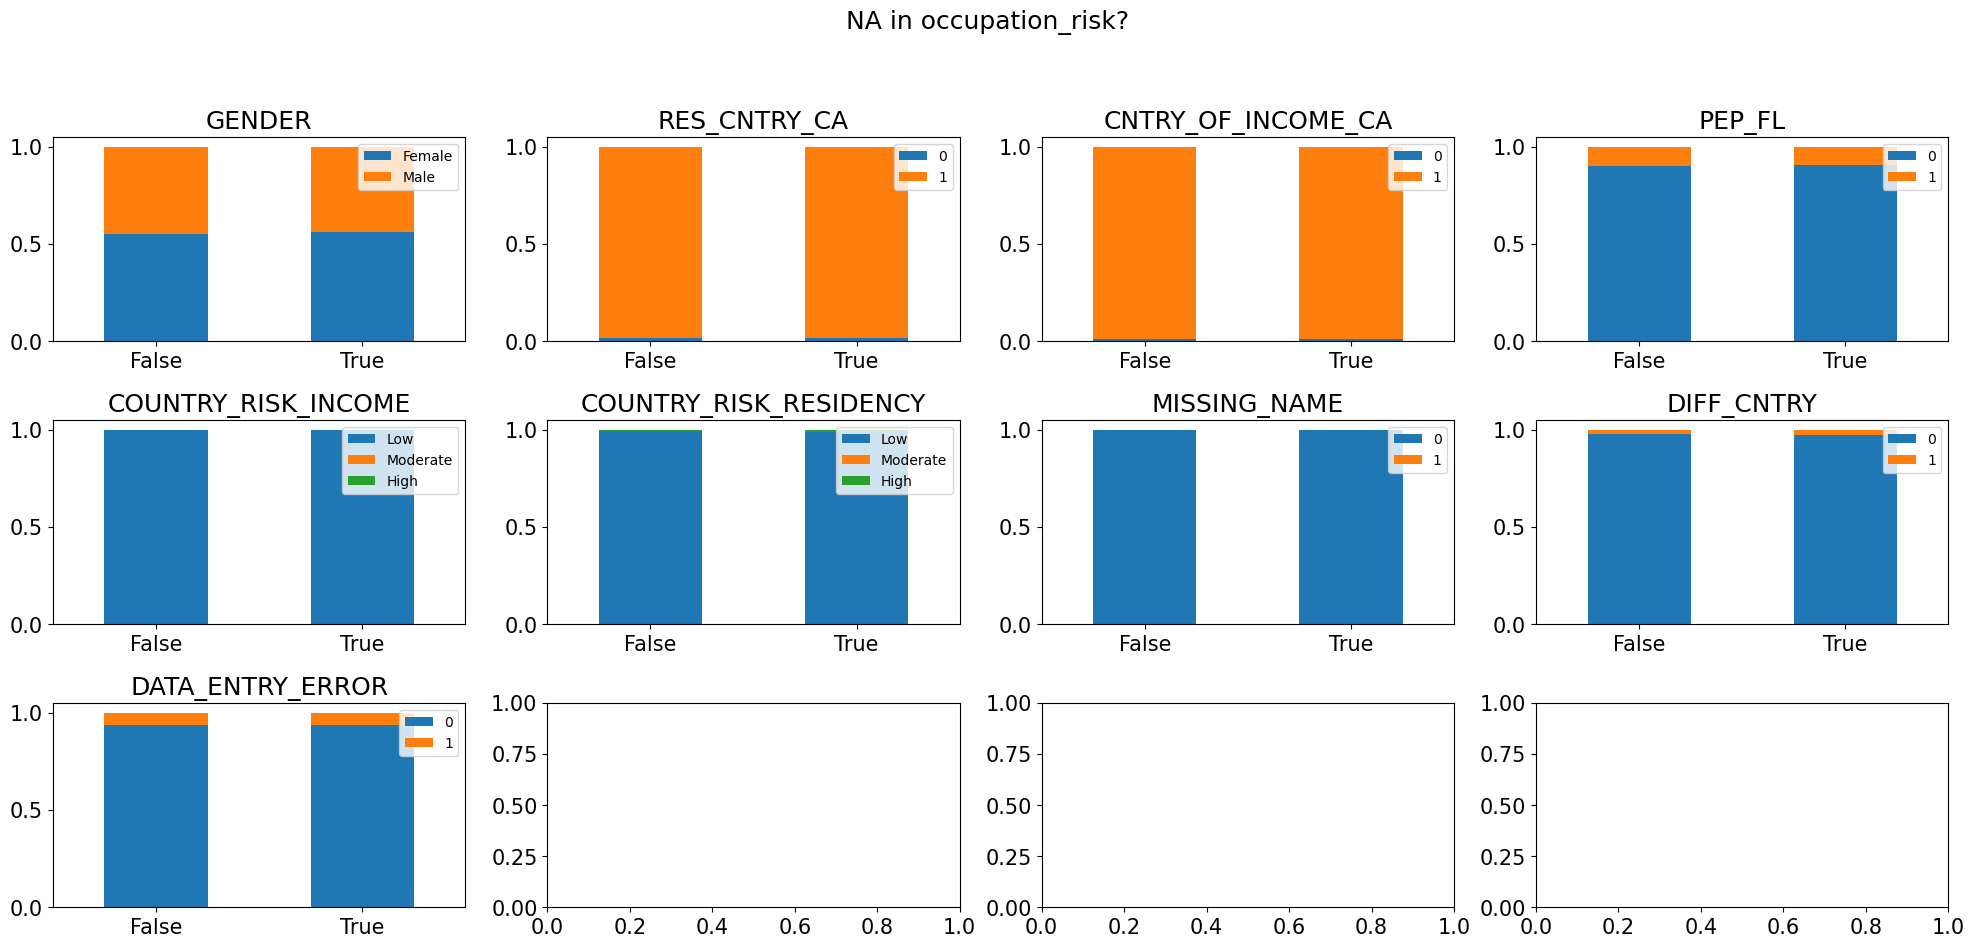

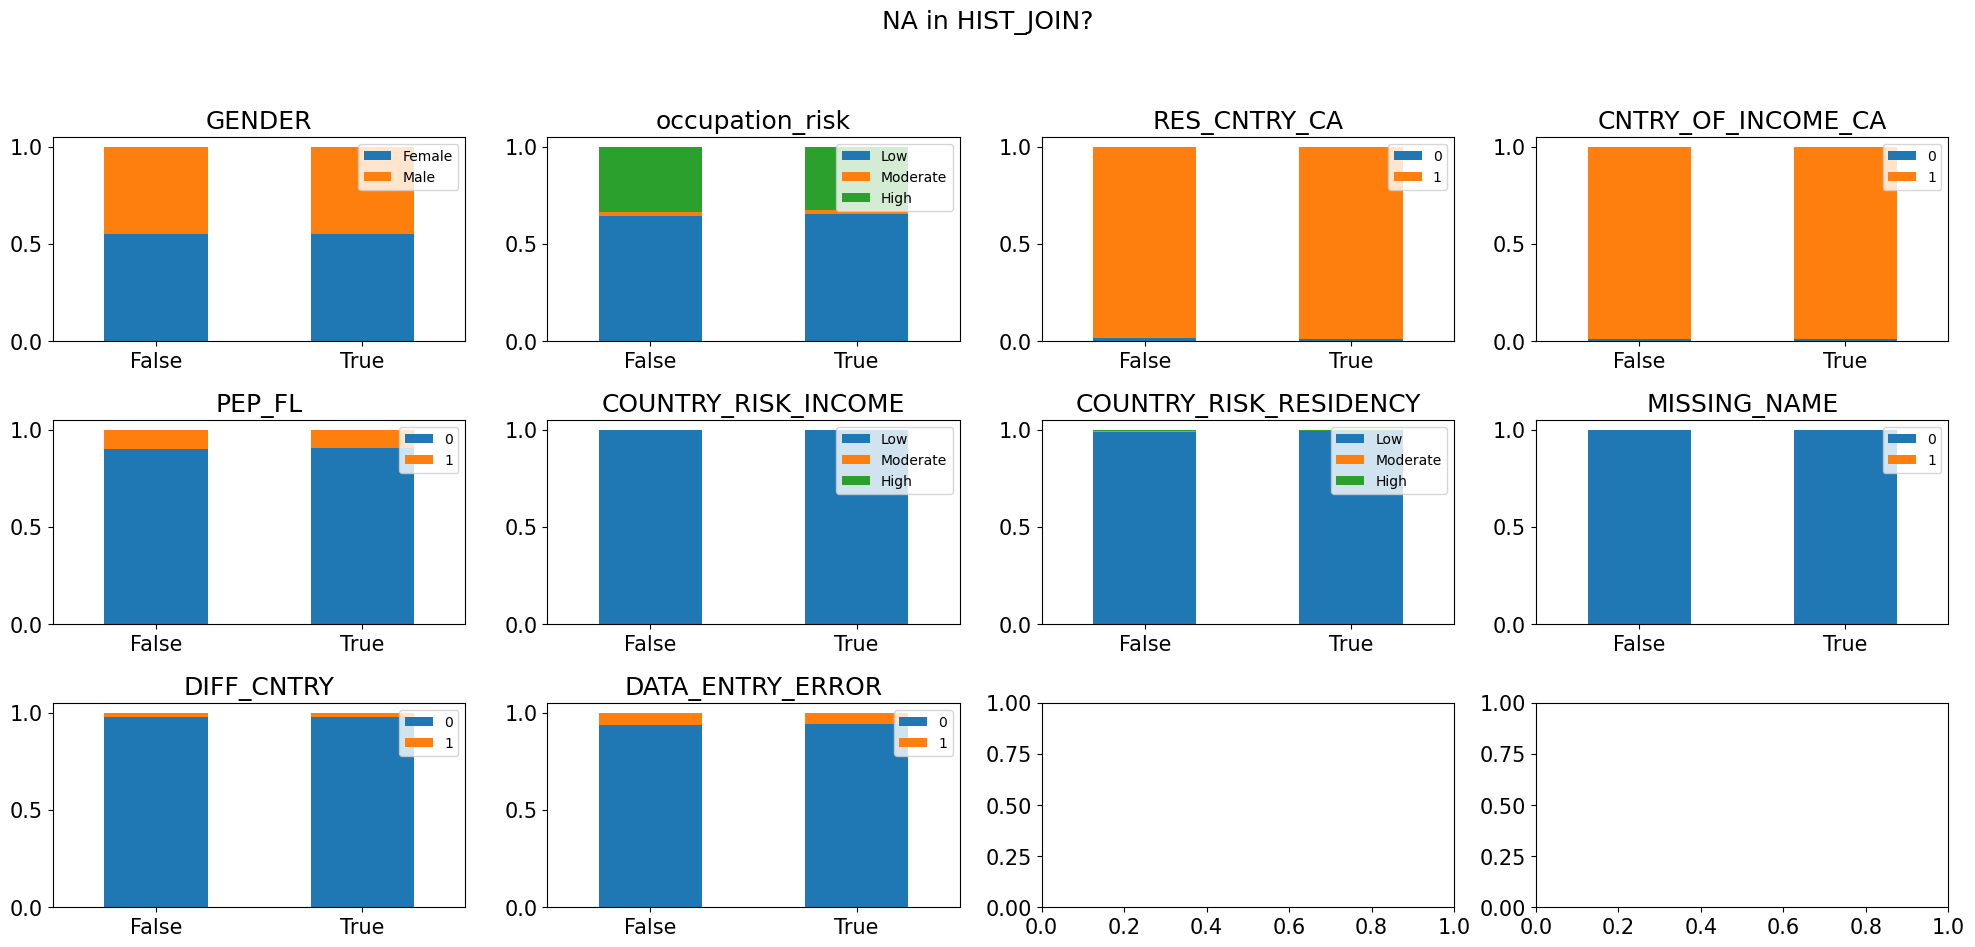

In [ ]:
# relationship in missing GENDER and missing name
for na_col in X_train.columns[X_train.isna().sum() != 0]:
  fig, axes = plt.subplots(3,4, figsize=(20,10))
  for col, ax in zip(X_train.drop(columns=[na_col]).select_dtypes(include = ['category']), axes.flatten()):
    pd.crosstab(X_train[na_col].isna(), X_train[col], normalize = 'index').plot(kind = 'bar', stacked = True, title = col, legend=False, ax = ax)
    ax.set_xlabel('')
    ax.set_xticklabels(['False', 'True'], rotation = 0)
    ax.legend(loc = 'upper right', prop={'size': 10})
  plt.subplots_adjust(hspace=1, wspace=0.3)
  plt.suptitle(f'NA in {na_col}?')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [ ]:
# if GENDER is missing, then MISSING_NAME must be 1
X_train[X_train.GENDER.isna()].MISSING_NAME.value_counts()

1    505
0      0
Name: MISSING_NAME, dtype: int64

### correlation among missingness

<AxesSubplot:>

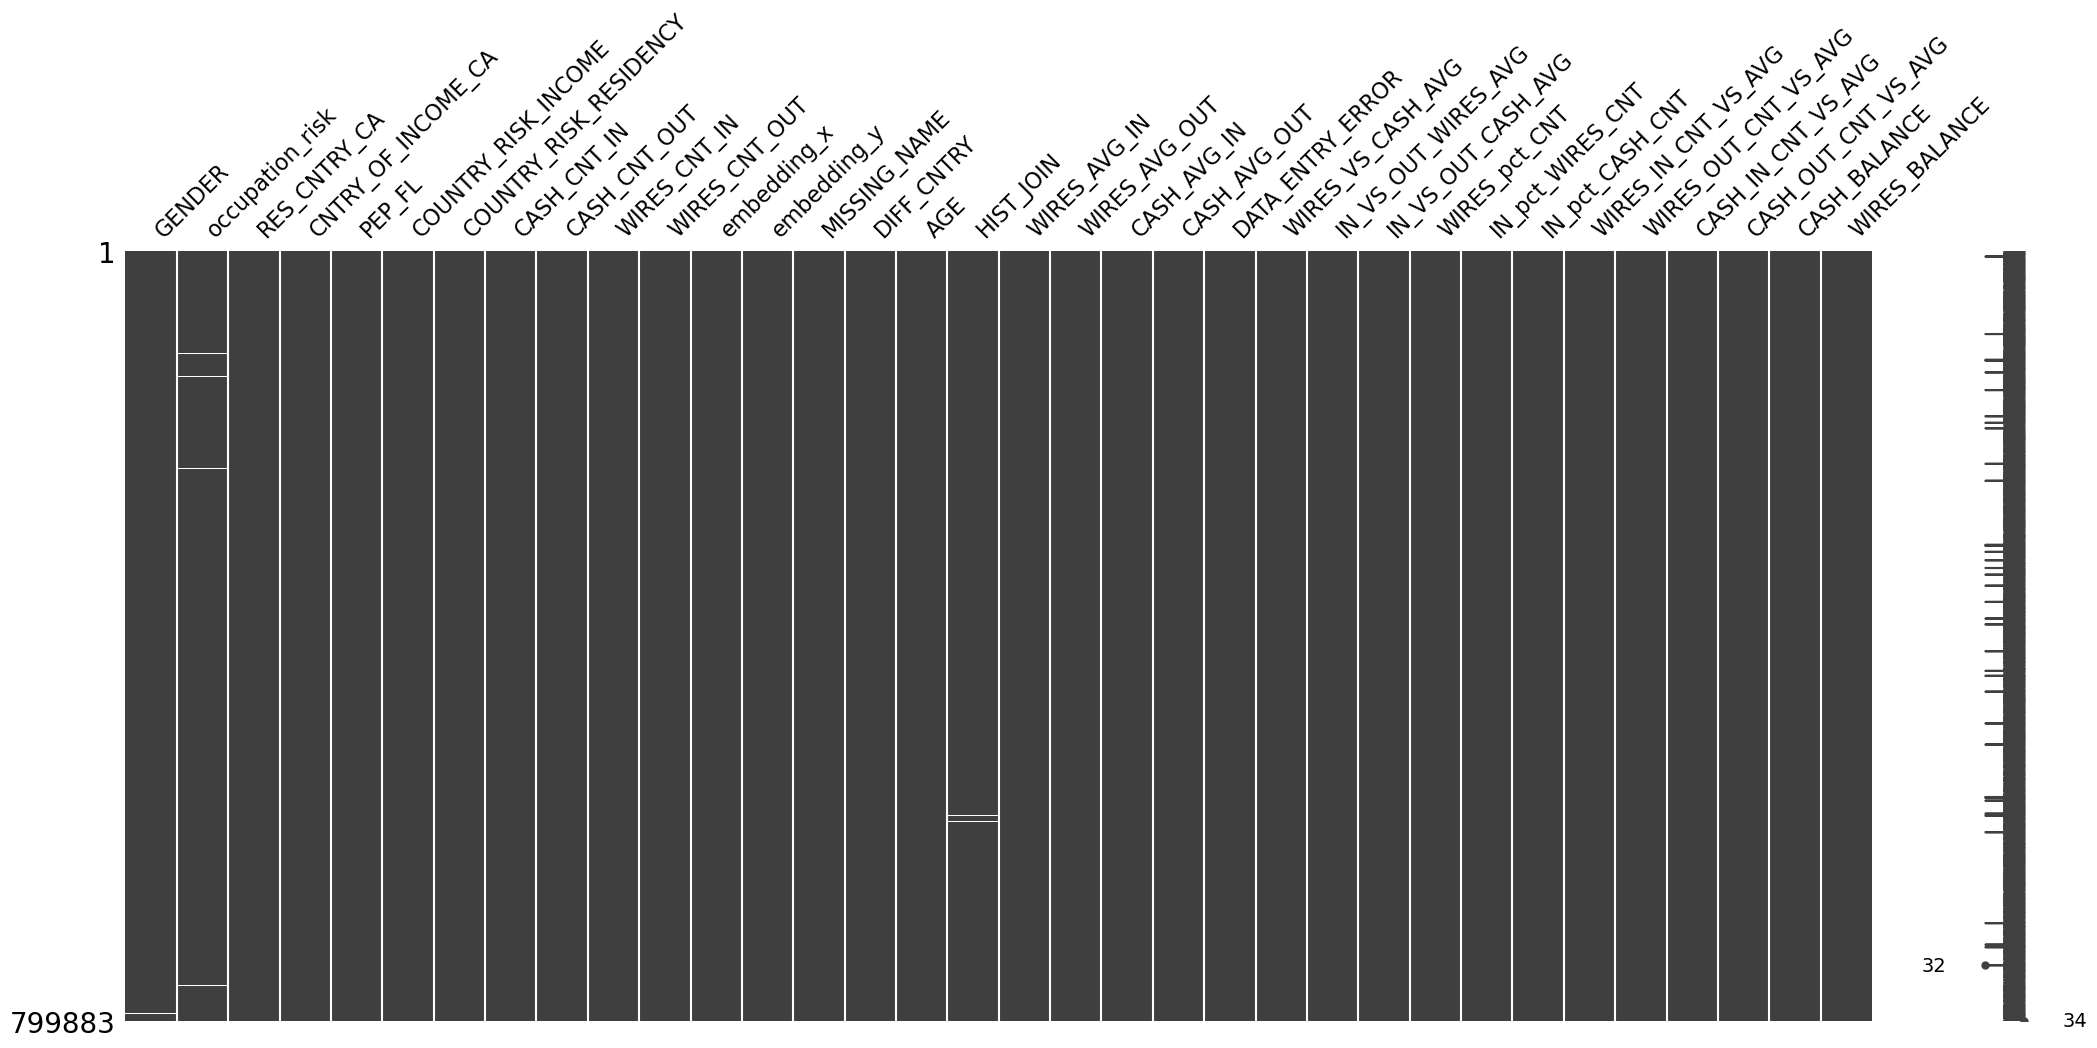

In [ ]:
msno.matrix(X_train)

<AxesSubplot:>

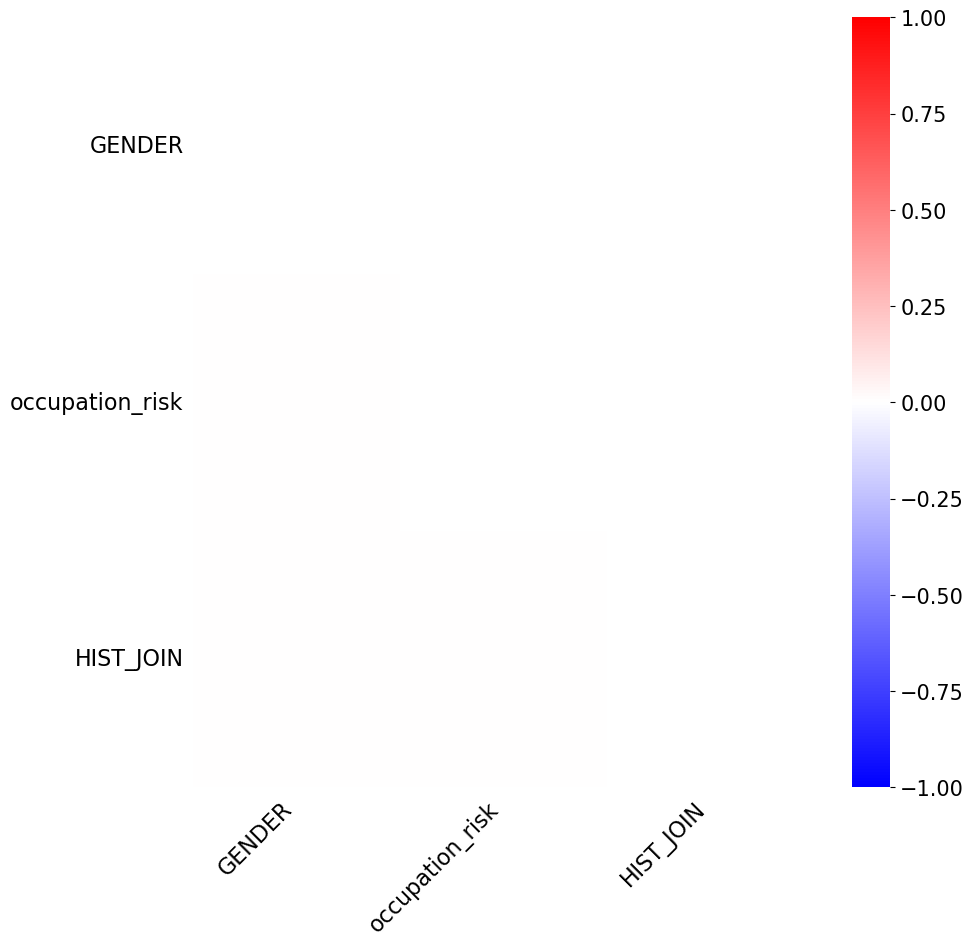

In [ ]:
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 
# 0 (variables appearing or not appearing have no effect on one another) to 
# 1 (if one variable appears the other definitely also does).
msno.heatmap(X_train, figsize = (10,10), cmap='bwr')

### RandomImputer or MySimpleImputer
- impute embeddings at random for bad_actor = 1 or 0
- impute occupation_risk and HIST_JOIN at random to maintain the spread of distribution
- impute GENDER with random values when MISSING_NAME == 1

In [ ]:
X_train.isna().sum().sum()

8980

In [ ]:
X_clean = RandomImputer().fit_transform(X_train)

In [ ]:
X_clean.isna().sum().sum()

0

## data_preparation pipeline for X
- numerical
  - Non-linear transformation to normal distribution
- categorical
  - unordered
    - OneHotEncoder:
      - no need to collapse infrequent categories -> infrequent class could represent minority class in target variable
  - ordered
    - ThermometerEncoder
    - [(2012) Evaluating the Impact of Categorical Data Encoding and Scaling on Neural Network Classification Performance: The Case of Repeat Consumption of Identical Cultural Goods (Elena Fitkov-Norris, Samireh Vahid, and Chris Hand from Kingston University London)](https://www.researchgate.net/publication/262173733_Evaluating_the_Impact_of_Categorical_Data_Encoding_and_Scaling_on_Neural_Network_Classification_Performance_The_Case_of_Repeat_Consumption_of_Identical_Cultural_Goods)
  - MinMaxScaler to rescale to -2 to +2 (95% confidence interval of normal distribution)
  - alternative: bin counting (prone to data leakage)

In [ ]:
num_pipeline = make_pipeline(
    # Impute missing values
    RandomImputer(),
    # MySimpleImputer(strategy='mean'),
    # transformation
    MyQuantileTransformer(output_distribution = 'normal', random_state=42, n_quantiles=100_000)
)

cat_pipeline = make_pipeline(
    # Impute missing values instead of treating as additional category (only a small portion is missing)
    RandomImputer(),
    # MySimpleImputer(strategy='most_frequent'),
    # transform with dummy variables
    MyOneHotEncoder(drop = 'if_binary', sparse = False),
    # scale to -2 and +2 to match 95% CI
    MyMinMaxScaler(feature_range=(-2, 2))
)

ordinal_pipeline = make_pipeline(
    # Impute missing values instead of treating as additional category (only a small portion is missing)
    RandomImputer(),
    # MySimpleImputer(strategy='most_frequent'),
    # transform with thermometer scaling
    ThermometerEncoder(),
    # scale to -2 and +2 to match 95% CI
    MyMinMaxScaler(feature_range=(-2, 2))
)

data_preparation = make_pipeline(
    # data transformation
    ColumnTransformer([
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        ("cat", cat_pipeline, ['GENDER', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'MISSING_NAME', 'DIFF_CNTRY', 'DATA_ENTRY_ERROR']),
        ("ord", ordinal_pipeline, ['occupation_risk', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY']),
      ], 
      # drop remaining columns if any
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    )
)

### X_train -> X_prep

In [ ]:
X_train.shape

(599916, 132)

In [ ]:
X_train.select_dtypes('category').columns

Index(['GENDER', 'occupation_risk', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA',
       'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY',
       'MISSING_NAME', 'DIFF_CNTRY', 'DATA_ENTRY_ERROR'],
      dtype='object')

In [ ]:
X_prep = pd.DataFrame(data_preparation.fit_transform(X_train), columns = data_preparation.get_feature_names_out())
X_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  \
0            0.6332        0.5261        0.6983         0.7469      -1.1346   
1           -1.3221        0.1960        0.9040        -0.3041       0.0590   
2            0.8148        1.4916        0.8824         0.6640       0.4959   
3           -0.8985        0.5692        0.4415         0.0307      -1.0706   
4           -0.8985        0.1960        0.8261         0.2651      -0.8229   
...             ...           ...           ...            ...          ...   
599911      -0.8985       -1.3105       -1.3816        -1.0217       1.2567   
599912       0.5320        0.0896        1.9823         1.6885       0.3414   
599913      -5.1993       -1.0068        1.0956         0.3363      -0.6306   
599914      -0.0055       -0.2831       -0.1835        -1.0588      -0.6130   
599915      -0.8985       -1.0068        0.4160        -0.0632      -0.3033   

        embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0            1.6550       1.2317       1.8000       1.6438      -1.9460   
1            0.4200      -0.3791      -0.1692      -0.0002      -0.0190   
2           -0.2502      -0.5242       0.1467      -0.9436      -0.5589   
3           -0.9008       0.9549      -0.7795       1.3232       0.9745   
4           -1.6345       0.9800       1.1996       0.6215       1.5840   
...             ...          ...          ...          ...          ...   
599911      -0.2172      -0.6790       0.1141      -0.6545      -0.0172   
599912       0.5657      -0.3795       0.0839      -1.2316      -1.1355   
599913      -0.5275       0.0622      -0.6172       0.6541      -1.2907   
599914      -0.8490       0.2913      -1.2264       0.5020       0.9647   
599915      -0.4118       0.5635       0.8418       0.5135       0.9009   

        embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
0           -2.2769       1.4357      -1.5671       1.0702       -0.5456   
1           -0.6859      -0.3428       1.2629       0.0989        0.5428   
2            0.0004      -0.0143       0.9955      -0.3879        0.8296   
3            1.3711       1.0327      -1.2228       1.4639       -1.5165   
4            1.6235       0.9994      -0.9263       0.3896       -1.1021   
...             ...          ...          ...          ...           ...   
599911      -0.7903      -0.4874       0.9327      -1.6354        1.2308   
599912      -0.5724      -0.5154       0.1840      -0.0335        0.6093   
599913       1.0555       0.2172      -0.5143       0.2042       -0.6895   
599914      -1.2596       0.2918      -0.2185       0.5495       -0.5529   
599915       1.1287       0.4181      -0.5890       0.7757       -0.7380   

        embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
0            -2.2251        1.9148       -2.0242        1.8016       -1.4624   
1             0.4492       -0.9050        0.6705       -1.5287        1.1486   
2             0.0477       -0.1164        0.2650       -0.1275        0.3332   
3             1.0275       -0.7090       -0.9487        0.9894       -0.7888   
4             1.4312        1.2733       -0.6865        0.8382       -0.9240   
...              ...           ...           ...           ...           ...   
599911        0.2364       -0.6928        1.5263       -1.6795        0.7374   
599912        0.0799       -1.5797        0.8606       -0.2560        0.9050   
599913        0.0298        0.6416       -0.1274        0.4551       -0.2486   
599914        0.4211        0.7690       -0.4212        0.2444       -0.3251   
599915        1.0238        0.4297       -0.4271        0.3208       -0.5381   

        embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  \
0             1.7890        1.1749       -1.8032        0.5627        1.9303   
1            -0.3372       -1.6062        0.6370        0.4330        0.0091   
2            -1.9318       -0.5092        2.

In [ ]:
X_prep.describe(percentiles = [0.025, 0.5, 0.975])

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  \
count 599,916.0000  599,916.0000  599,916.0000   599,916.0000 599,916.0000   
mean       -0.1399       -0.0390       -0.0109        -0.0051       0.0014   
std         1.4232        1.1469        1.0329         1.0166       0.9981   
min        -5.1993       -5.1993       -5.1993        -5.1993      -5.1993   
2.5%       -5.1993       -1.8639       -1.9857        -1.9487      -1.9641   
50%        -0.0055       -0.0248        0.0022         0.0061       0.0021   
97.5%       1.9499        1.9655        1.9544         1.9504       1.9495   
max         5.1993        5.1993        5.1993         5.1993       5.1993   

       embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
count 599,916.0000 599,916.0000 599,916.0000 599,916.0000 599,916.0000   
mean       -0.0036       0.0008      -0.0042       0.0018       0.0027   
std         0.9993       0.9995       1.0002       0.9992       1.0016   
min        -5.1993      -5.1993      -5.1993      -5.1993      -5.1993   
2.5%       -1.9617      -1.9620      -1.9750      -1.9540      -1.9657   
50%        -0.0057      -0.0022      -0.0001       0.0084       0.0031   
97.5%       1.9659       1.9564       1.9494       1.9557       1.9657   
max         5.1993       5.1993       5.1993       5.1993       5.1993   

       embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
count 599,916.0000 599,916.0000 599,916.0000 599,916.0000  599,916.0000   
mean        0.0045      -0.0002       0.0063      -0.0028        0.0020   
std         1.0009       1.0023       1.0042       0.9970        1.0041   
min        -5.1993      -5.1993      -5.1993      -5.1993       -5.1993   
2.5%       -1.9574      -1.9658      -1.9594      -1.9580       -1.9707   
50%         0.0082      -0.0054       0.0043      -0.0032        0.0029   
97.5%       1.9641       1.9677       1.9721       1.9574        1.9719   
max         5.1993       5.1993       5.1993       5.1993        5.1993   

       embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
count  599,916.0000  599,916.0000  599,916.0000  599,916.0000  599,916.0000   
mean        -0.0080       -0.0028        0.0006        0.0041       -0.0007   
std          0.9966        0.9988        0.9996        0.9989        1.0028   
min         -5.1993       -5.1993       -5.1993       -5.1993       -5.1993   
2.5%        -1.9715       -1.9623       -1.9480       -1.9463       -1.9610   
50%         -0.0082       -0.0040        0.0000        0.0044       -0.0002   
97.5%        1.9421        1.9671        1.9656        1.9626        1.9613   
max          5.1993        5.1993        5.1993        5.1993        5.1993   

       embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  \
count  599,916.0000  599,916.0000  599,916.0000  599,916.0000  599,916.0000   
mean        -0.0035       -0.0009        0.0002       -0.0047        0.0018   
std          1.0014        0.9993        1.0001        1.0019        0.9993   
min         -5.1993       -5.1993       -5.1993       -5.1993       -5.1993   
2.5%        -1.9727       -1.9516       -1.9606       -1.9636       -1.9586   
50%         -0.0021        0.0008       -0.0033       -0.0054        0.0013   
97.5%        1.9572        1.9508        1.9631        1.9612        1.9567   
max          5.1993        5.1993        5.1993        5.1993        5.1993   

       embedding_21  embedding_22  embedding_23  embedding_24  embedding_25  \
count  599,916.0000  599,916.0000  599,916.0000  599,916.0000  599,916.0000   
mean         0.0002        0.0022       -0.0005       -0.0021        0.0040   
std          1.0011        1.0012        1.0017        1.0026        1.0026   
min         -5.1993       -5.1993       -5.1993       -5.1993       -5.1993   
2.5%        -1.9620       -1.9550       -1.9519       -1.9641       -1.9485   
50%          0.0019       -0.0014       -0.0021       -0.0029  

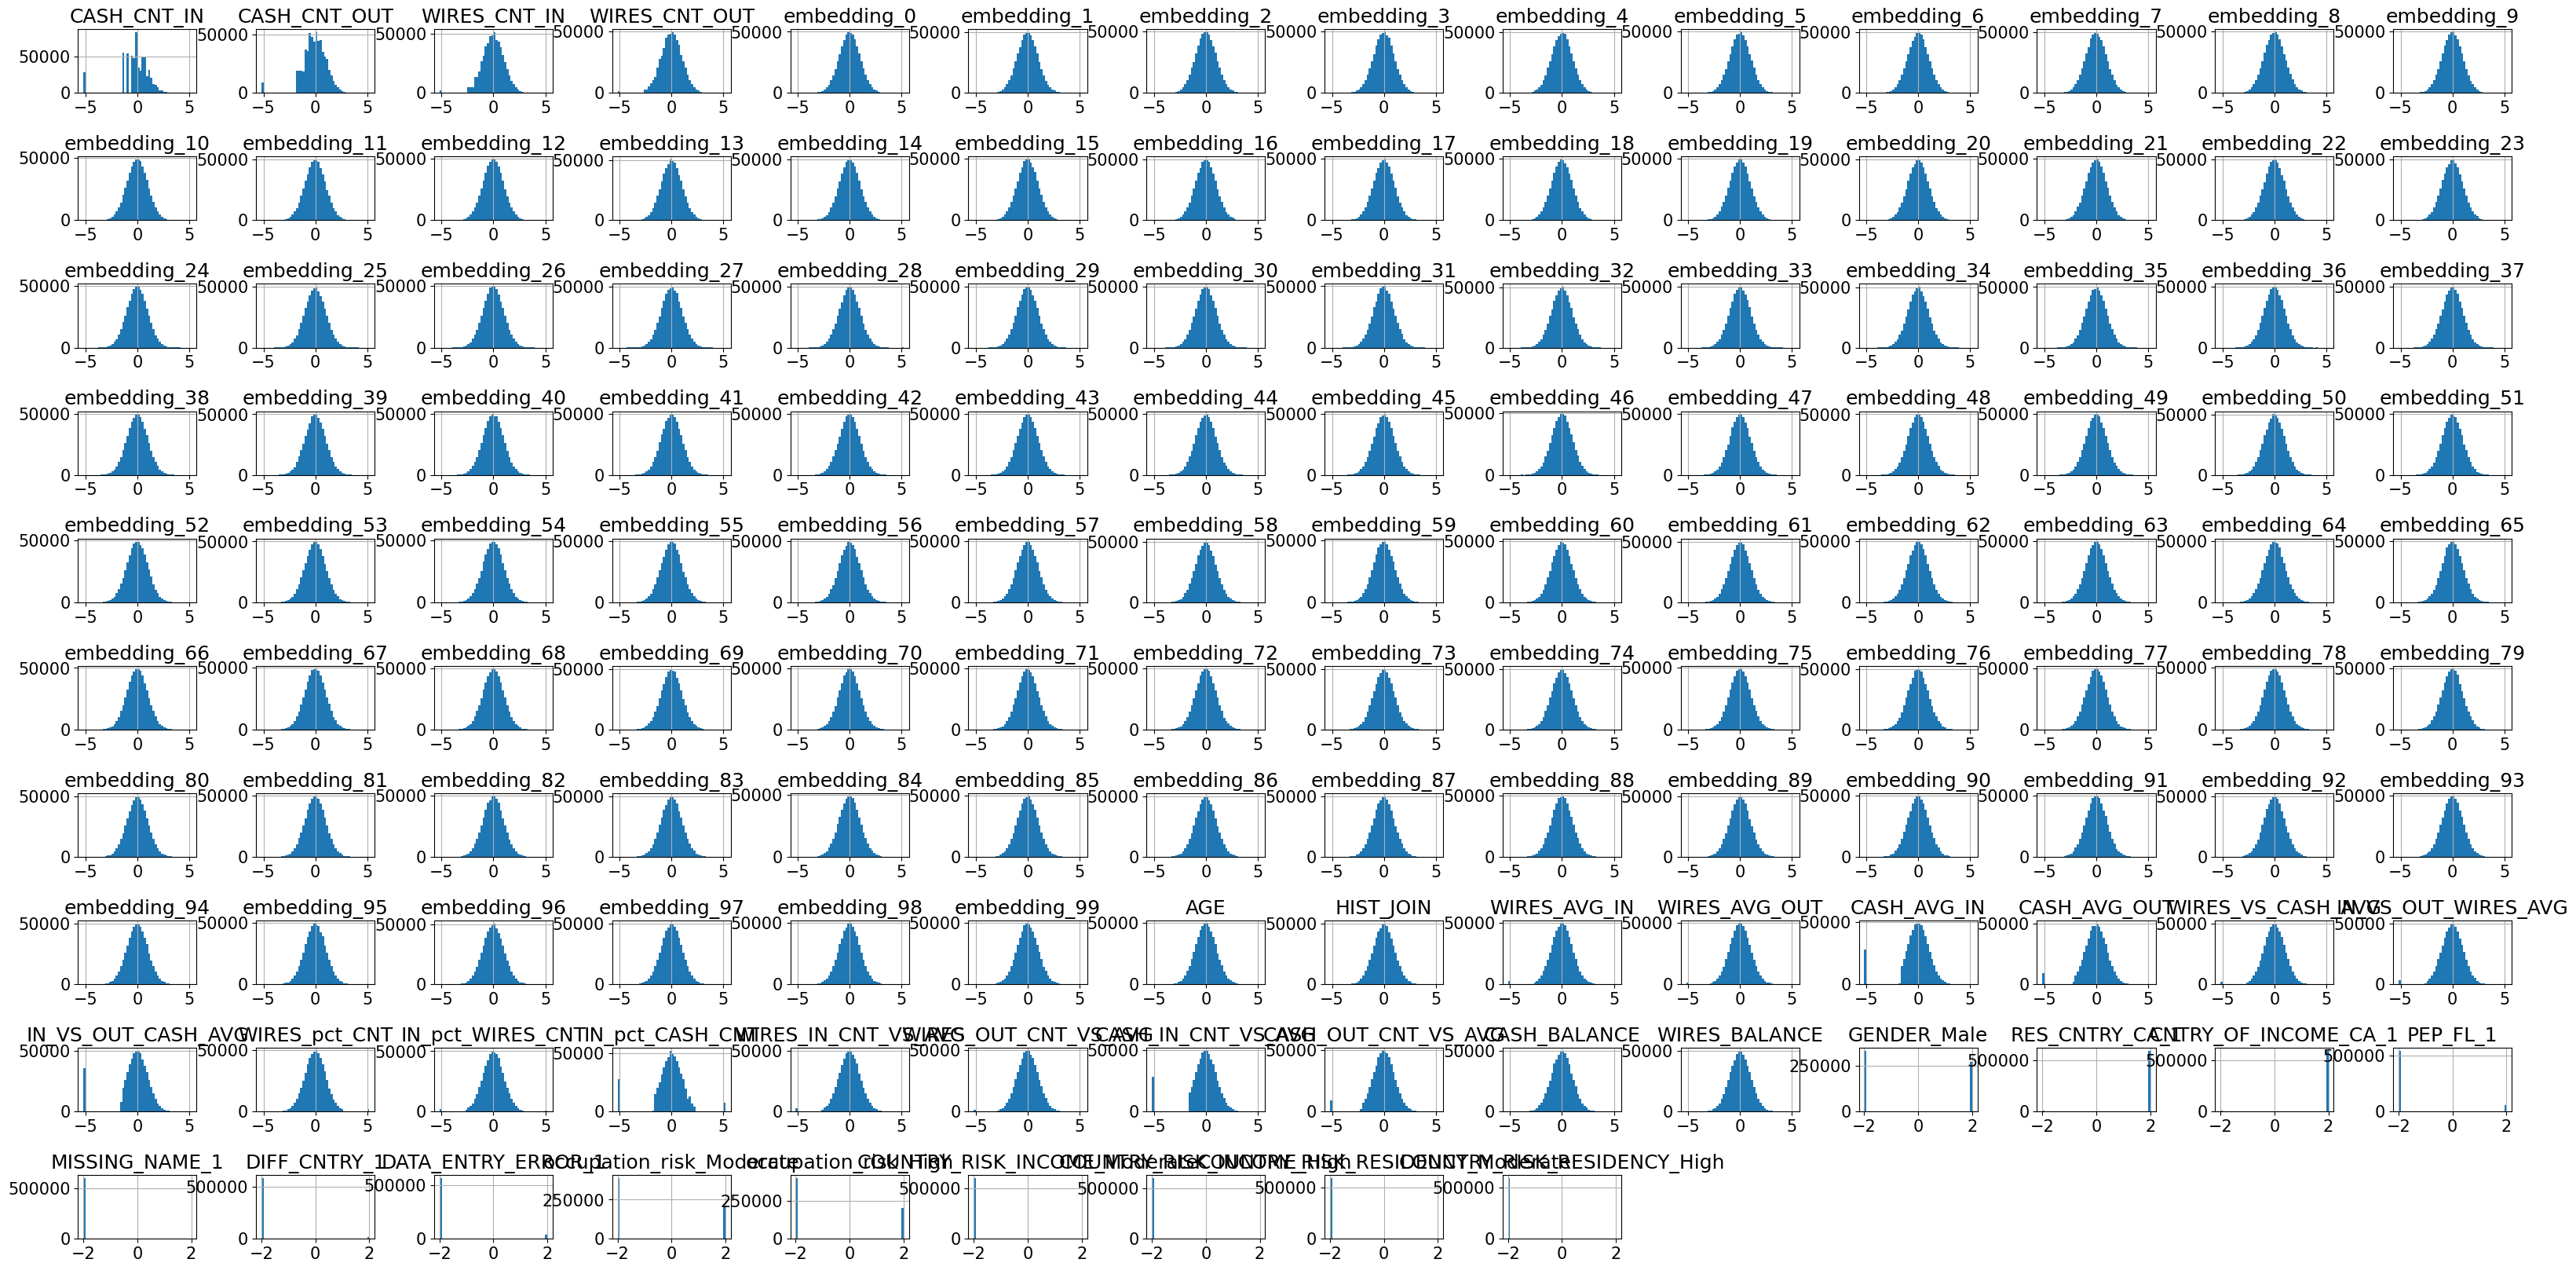

In [ ]:
X_prep.hist(bins = 50, layout = (10, int(X_prep.select_dtypes(include = np.number).shape[1] / 10) + 1), figsize= (40,20))
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

### y_train -> y_prep 0,1

In [ ]:
# binary
y_prep = y_train.to_numpy()

## 3-fold custom CV iterator Stratified Shuffle Split()

In [ ]:
cv_split = StratifiedShuffleSplit(n_splits = 3, test_size=1/3, random_state = 42)

In [ ]:
for i, (train_index, test_index) in enumerate(cv_split.split(X_train, y_train)):
    print(f"Fold {i}:")
    print(f"  Train ({len(train_index):,.0f}): index={train_index}")
    print(f"  Test  ({len(test_index):,.0f}):  index={test_index}")
    print(f"  Number of bad actors = {sum(y_train[test_index] == 1)}")

Fold 0:
  Train (399,944): index=[   603  37151 338410 ... 585145 523649 373037]
  Test  (199,972):  index=[258198 430421  18610 ... 589084 403608 225306]
  Number of bad actors = 10
Fold 1:
  Train (399,944): index=[591010 436858 478279 ... 459933  94778  95423]
  Test  (199,972):  index=[ 75337 454785 345469 ... 152163 512604 245854]
  Number of bad actors = 10
Fold 2:
  Train (399,944): index=[249619 114741 504211 ... 485517  40410 150811]
  Test  (199,972):  index=[316227 250505 373009 ...  97386  52852 527025]
  Number of bad actors = 10


In [ ]:
# check class balance is maintained in CV folds
# CV_train_index, CV_test_index = next(cv_split.split(X_prep, y_train))
# class_label, class_balance = np.unique(y_train, return_counts=True, axis = 0)
# print(f"Original class balance = \n{class_label}, \n{class_balance / class_balance.sum()}")
# class_label, class_balance = np.unique(y_train[CV_test_index,:], return_counts=True, axis = 0)
# print(f"CV-fold class balance = \n{class_label}, \n{class_balance / class_balance.sum()}")

## X,y_train -> X_subset, y_subset for 100k rows to test

In [ ]:
first_n = None
X_subset = X_prep[:first_n]
y_subset = y_prep[:first_n]

In [ ]:
np.unique(y_subset, return_counts=True)

(array([0, 1], dtype=int64), array([599886,     30], dtype=int64))

## Combine all as data_preparation()

In [ ]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(n_quantiles=100000,
                                                                                         output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000181060AF880>),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                  ['GENDER', 'RES_CNTRY_CA',
                                                   'CNTRY_OF_INCOME_CA',
                                                   'PEP_FL', 'MISSING_NAME',
                                                   'DIFF_CNTRY',
                                                   'DATA_ENTRY_ERROR']),
                                                 ('ord',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('thermometerencoder',
                                                                   ThermometerEncoder()),
                                                                  ('myminmaxscaler',
                                                                   MyMinMaxScaler(feature_range=(-2,
                                                                                                 2)))]),
                                                  ['occupation_risk',
                                                   'COUNTRY_RISK_INCOME',
                                                   'COUNTRY_RISK_RESIDENCY'])],
                                   verbose_feature_names_out=False))])

## runtime: 58min for all 700k rows

In [ ]:
X_subset_prep = X_prep
X_subset_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  \
0            0.6332        0.5261        0.6983         0.7469      -1.1346   
1           -1.3221        0.1960        0.9040        -0.3041       0.0590   
2            0.8148        1.4916        0.8824         0.6640       0.4959   
3           -0.8985        0.5692        0.4415         0.0307      -1.0706   
4           -0.8985        0.1960        0.8261         0.2651      -0.8229   
...             ...           ...           ...            ...          ...   
599911      -0.8985       -1.3105       -1.3816        -1.0217       1.2567   
599912       0.5320        0.0896        1.9823         1.6885       0.3414   
599913      -5.1993       -1.0068        1.0956         0.3363      -0.6306   
599914      -0.0055       -0.2831       -0.1835        -1.0588      -0.6130   
599915      -0.8985       -1.0068        0.4160        -0.0632      -0.3033   

        embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0            1.6550       1.2317       1.8000       1.6438      -1.9460   
1            0.4200      -0.3791      -0.1692      -0.0002      -0.0190   
2           -0.2502      -0.5242       0.1467      -0.9436      -0.5589   
3           -0.9008       0.9549      -0.7795       1.3232       0.9745   
4           -1.6345       0.9800       1.1996       0.6215       1.5840   
...             ...          ...          ...          ...          ...   
599911      -0.2172      -0.6790       0.1141      -0.6545      -0.0172   
599912       0.5657      -0.3795       0.0839      -1.2316      -1.1355   
599913      -0.5275       0.0622      -0.6172       0.6541      -1.2907   
599914      -0.8490       0.2913      -1.2264       0.5020       0.9647   
599915      -0.4118       0.5635       0.8418       0.5135       0.9009   

        embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
0           -2.2769       1.4357      -1.5671       1.0702       -0.5456   
1           -0.6859      -0.3428       1.2629       0.0989        0.5428   
2            0.0004      -0.0143       0.9955      -0.3879        0.8296   
3            1.3711       1.0327      -1.2228       1.4639       -1.5165   
4            1.6235       0.9994      -0.9263       0.3896       -1.1021   
...             ...          ...          ...          ...           ...   
599911      -0.7903      -0.4874       0.9327      -1.6354        1.2308   
599912      -0.5724      -0.5154       0.1840      -0.0335        0.6093   
599913       1.0555       0.2172      -0.5143       0.2042       -0.6895   
599914      -1.2596       0.2918      -0.2185       0.5495       -0.5529   
599915       1.1287       0.4181      -0.5890       0.7757       -0.7380   

        embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
0            -2.2251        1.9148       -2.0242        1.8016       -1.4624   
1             0.4492       -0.9050        0.6705       -1.5287        1.1486   
2             0.0477       -0.1164        0.2650       -0.1275        0.3332   
3             1.0275       -0.7090       -0.9487        0.9894       -0.7888   
4             1.4312        1.2733       -0.6865        0.8382       -0.9240   
...              ...           ...           ...           ...           ...   
599911        0.2364       -0.6928        1.5263       -1.6795        0.7374   
599912        0.0799       -1.5797        0.8606       -0.2560        0.9050   
599913        0.0298        0.6416       -0.1274        0.4551       -0.2486   
599914        0.4211        0.7690       -0.4212        0.2444       -0.3251   
599915        1.0238        0.4297       -0.4271        0.3208       -0.5381   

        embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  \
0             1.7890        1.1749       -1.8032        0.5627        1.9303   
1            -0.3372       -1.6062        0.6370        0.4330        0.0091   
2            -1.9318       -0.5092        2.

## dump data_preparation.joblib

In [ ]:
dump(data_preparation, f'data_preparation.joblib')

['data_preparation.joblib']

## load data_preparation()

In [ ]:
data_preparation = load('data_preparation.joblib')
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(n_quantiles=100000,
                                                                                         output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001813287A3A0>),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                  ['GENDER', 'RES_CNTRY_CA',
                                                   'CNTRY_OF_INCOME_CA',
                                                   'PEP_FL', 'MISSING_NAME',
                                                   'DIFF_CNTRY',
                                                   'DATA_ENTRY_ERROR']),
                                                 ('ord',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('thermometerencoder',
                                                                   ThermometerEncoder()),
                                                                  ('myminmaxscaler',
                                                                   MyMinMaxScaler(feature_range=(-2,
                                                                                                 2)))]),
                                                  ['occupation_risk',
                                                   'COUNTRY_RISK_INCOME',
                                                   'COUNTRY_RISK_RESIDENCY'])],
                                   verbose_feature_names_out=False))])

# Shortlist promising models (12min)

In [ ]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {
    # 1) need predict_proba() for all classifiers such that we can use some ensemble methods later
    # 2) class imbalance in data
      # current method: rebalance class weight
      # alternative: sampling methods, e.g. oversampling, undersampling, SMOTE, ADA
      # medium article: 

    # "isolation_forest": IsolationForest(n_jobs=-1, contamination=y_prep.sum()/y_prep.size),
    # "knn": KNeighborsClassifier(n_jobs=-1),
    "sgd": SGDClassifier(loss='log', penalty='elasticnet', class_weight = 'balanced'), # SGD solver for logistic regression
    "nb": GaussianNB(),
    # "logistic": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4, class_weight = 'balanced'),
    # "svc": SVC(kernel='linear', probability=True, class_weight = 'balanced'), # SVC instead of LinearSVC for predict_proba()
    # "svc_poly": SVC(kernel='poly', probability=True, class_weight = 'balanced'), # probability=True for predict_proba()
    # "svc_rbf": SVC(kernel='rbf', probability=True, class_weight = 'balanced'), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(class_weight = 'balanced'),
    "forest": RandomForestClassifier(n_jobs = -1, class_weight = 'balanced'),
    "extree": ExtraTreesClassifier(n_jobs = -1, class_weight = 'balanced'),
    # "gb": GradientBoostingClassifier(),
    "histgb": HistGradientBoostingClassifier(),
    # "bagging": BaggingClassifier(n_jobs = -1),
    # "ada": AdaBoostClassifier(),
    "xgb": XGBClassifier(n_jobs = -1, tree_method = 'hist'),
    "xgbrf": XGBRFClassifier(n_jobs = -1, tree_method = 'hist'),
    "lgbm": LGBMClassifier(class_weight='balanced'),
    # "catboost": CatBoostClassifier(auto_class_weights='Balanced', verbose = False)
}

In [ ]:
list_clf = []
AP_CVs = []
AP_train = []
list_precision = []
list_recall = []
list_thresholds = []
store_clf = []

# fit each classification algorithm and calculate 10-fold CV AP
for key, item in tqdm(dict_clf.items()):
  print(key)
  # add estimator after data_preparation pipeline
  clf = Pipeline(
        [(key, item)]
        ).fit(X_subset_prep, y_prep)
  try:
    AP_train.append(average_precision_score(y_prep, clf.decision_function(X_subset_prep)))
  except AttributeError:
    AP_train.append(average_precision_score(y_prep, clf.predict_proba(X_subset_prep)[:,1]))
  store_clf.append(clf)
  
  # cross validation score
  AP_CV = cross_val_score(clf, X_subset_prep, y_prep, cv = cv_split, scoring = 'average_precision', n_jobs = -1)

  list_clf.append(key)
  AP_CVs.append(AP_CV)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

sgd


 11%|█████████▎                                                                          | 1/9 [00:32<04:17, 32.21s/it]

nb


 22%|██████████████████▋                                                                 | 2/9 [00:39<02:00, 17.26s/it]

tree


 33%|████████████████████████████                                                        | 3/9 [01:30<03:17, 32.86s/it]

forest


 44%|█████████████████████████████████████▎                                              | 4/9 [03:14<05:05, 61.10s/it]

extree


 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:18<04:07, 61.89s/it]

histgb


 67%|████████████████████████████████████████████████████████                            | 6/9 [04:38<02:23, 47.84s/it]

xgb


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:24<01:34, 47.34s/it]

xgbrf


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:12<00:47, 47.51s/it]

lgbm


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:54<00:00, 46.06s/it]


In [ ]:
# sort the models by AP but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AP = [np.mean(AP) for AP in AP_CVs]
sd_AP = [np.std(AP) for AP in AP_CVs]
print("Models sorted by cross validation AP score")
for mean, sd, clf_name in sorted(zip(mean_AP, sd_AP, list_clf), reverse = True):
  print(f"CV AP: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AP score
CV AP: AVG 0.0730 / SD 0.0417 / extree
CV AP: AVG 0.0500 / SD 0.0549 / xgb
CV AP: AVG 0.0389 / SD 0.0437 / forest
CV AP: AVG 0.0337 / SD 0.0355 / sgd
CV AP: AVG 0.0122 / SD 0.0049 / xgbrf
CV AP: AVG 0.0063 / SD 0.0047 / lgbm
CV AP: AVG 0.0004 / SD 0.0001 / nb
CV AP: AVG 0.0002 / SD 0.0002 / histgb
CV AP: AVG 0.0001 / SD 0.0000 / tree


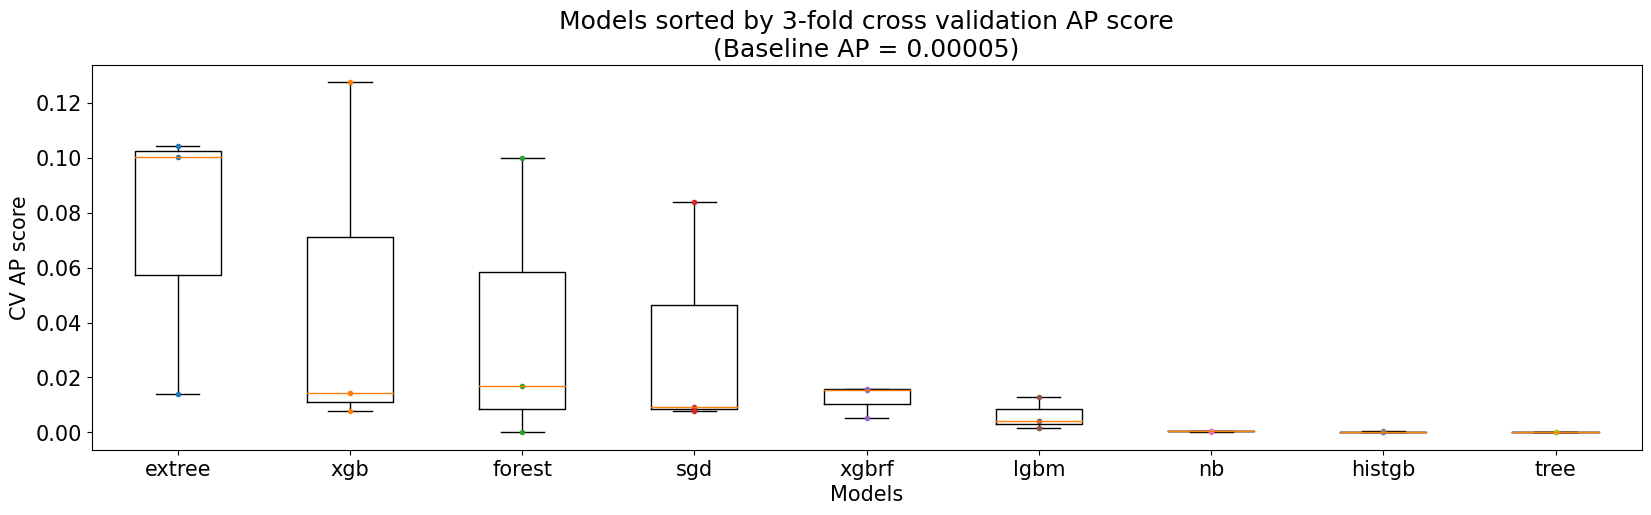

In [ ]:
# sort the models and plot the box plots of CV AP scores
mean_AP = [np.mean(AP) for AP in AP_CVs]
sorted_AP_CV = [i for _, i in [(mean_AP[i], AP_CVs[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_clf = [i for _, i in [(mean_AP[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_AP_train = [i for _, i in [(mean_AP[i], AP_train[i]) for i in np.argsort(mean_AP)[::-1]]]
plt.boxplot(sorted_AP_CV, labels=sorted_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_AP_CV):
  plt.plot([i+1]*len(AP), AP, ".")
# plt.plot([*range(1,len(sorted_AP_CV)+1,1)], sorted_AP_train, "ks", label='AP on train set')
plt.title(f"Models sorted by {cv_split.get_n_splits()}-fold cross validation AP score\n(Baseline AP = {(y_prep.sum() / y_prep.size):0.5f})")
plt.xlabel("Models")
plt.ylabel("CV AP score")
# plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

## test hyperparameter grid

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier based on performance and fitting time
def adjust_class_weight(x):
  return {0: y_prep.size / (len(set(y_prep)) * (y_prep.size - x)), 1: y_prep.size / (len(set(y_prep)) * x)}

def adjust_scale_pos_weight(x):
  return (y_prep.size - x) / x

# create a list of hyperparameters to tune for each shortlisted classifier based on performance and fitting time
shortlisted_clfs = {
    # "sgd": SGDClassifier(loss='log', penalty='elasticnet', class_weight = 'balanced'),
    # "xgb": XGBClassifier(tree_method = 'hist', n_jobs = -1),
    # "lgbm": LGBMClassifier(class_weight='balanced'),
    "extree": ExtraTreesClassifier(class_weight='balanced', n_jobs=-1),
}

param_grids = {
    # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#parameters-tuning
    # https://lightgbm.readthedocs.io/en/v3.3.5/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
    # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#deal-with-over-fitting
    "lgbm": {
        "lgbm__class_weight": [adjust_class_weight(w) for w in [10,20,30,40,50,60]],
        'lgbm__max_bin': [150, 175, 200, 225, 255, 300],
        "lgbm__num_leaves": [20, 25, 31, 40],
        "lgbm__min_data_in_leaf": [10, 20, 30],
        "lgbm__bagging_fraction": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "lgbm__bagging_freq": [1],
        "lgbm__feature_fraction": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "lgbm__lambda_l1": [1e-2, 1e-1, 1e0, 1e1, 1e2],
        "lgbm__lambda_l2": [1e-2, 1e-1, 1e0, 1e1, 1e2],
        "lgbm__min_gain_to_split": [1e-4, 1e-3, 1e-2, 1e-1],
        "lgbm__max_depth": [15, 20, 25, 30],
        "lgbm__extra_trees": [True],       
    },

    
    "xgb": {
        "xgb__scale_pos_weight": [adjust_scale_pos_weight(w) for w in [10,20,30,40,50]],
        "xgb__max_depth": [2,4,6,8,10],
        "xgb__n_estimators": [50, 100, 150],
        "xgb__max_bin": [100, 200, 300, 400, 500, 600],
        "xgb__min_child_weight": [1e-1, 1e0, 1e1],
        "xgb__subsample": [0.2, 0.4, 0.6, 0.8, 1.0],
        "xgb__colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1.0],
        "xgb__colsample_bylevel": [0.2, 0.4, 0.6, 0.8, 1.0],
        "xgb__colsample_bynode": [0.2, 0.4, 0.6, 0.8, 1.0],
    },
    
    "extree": {
        # "extree__n_estimators": [25, 50, 100, 150, 200],
        # "extree__criterion": ['gini', 'entropy'],
        # "extree__max_depth": [25, 50, 100, 125, 150],
        # "extree__min_samples_split": [0.2, 0.4, 0.6, 0.8, 1.0],
        # "extree__min_samples_leaf": [1e-5, 1e-4, 1e-3],
        "extree__min_weight_fraction_leaf": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        # "extree__max_features" : ["sqrt", "log2"],
        # "extree__min_impurity_decrease": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        # "extree__bootstrap": [True, False],
        # "extree__ccp_alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    }
    
}

def refit_strategy(cv_results):
  my_cv_result = pd.DataFrame(cv_results)
  my_cv_result['mean_2sd'] = my_cv_result['mean_test_score'] - 2 * my_cv_result['std_test_score']
  return my_cv_result.sort_values('mean_2sd', ascending=False).head(1).index[0]

In [ ]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
for clf_name, clf in tqdm(shortlisted_clfs.items()):
  
  # remove transformation and feature selection here from the pipeline to save time (alternative: cache)
  full_pipeline = Pipeline(
      [(clf_name, clf)]) 

  print(clf)


  param_grid = copy.deepcopy(param_grids.get(clf_name))

  
  random_search = GridSearchCV(
      full_pipeline, 
      param_grid, 
      cv = cv_split, 
      # n_iter= 5, 
      scoring = 'average_precision',
      # random_state = 42,
      n_jobs = -1,
      error_score = 'raise',
      refit=refit_strategy)
  random_search.fit(X_subset_prep, y_prep)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:04<00:00, 184.52s/it]


In [ ]:
cv_result = pd.DataFrame(random_search.cv_results_)
cv_result['mean_2sd'] = cv_result['mean_test_score'] - 2 * cv_result['std_test_score']
cv_result[['param_' + x for x in list(param_grid.keys())] + ['mean_test_score', 'std_test_score', 'mean_fit_time', 'mean_2sd']]
# cv_result.sort_values(['param_' + list(param_grid.keys())[-1]])[['param_' + x for x in list(param_grid.keys())] + ['mean_test_score', 'std_test_score', 'mean_fit_time', 'mean_2sd']]

param_extree__min_weight_fraction_leaf  mean_test_score  std_test_score  \
0                                 0.0000           0.0679          0.0467   
1                                 0.0001           0.1089          0.0713   
2                                 0.0010           0.0964          0.0694   
3                                 0.0100           0.1021          0.0626   
4                                 0.1000           0.0517          0.0629   

   mean_fit_time  mean_2sd  
0       155.1522   -0.0254  
1       157.2772   -0.0336  
2       156.6672   -0.0423  
3       155.6471   -0.0231  
4       102.9865   -0.0741

## scikit-optimize

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier based on performance and fitting time
def adjust_class_weight(x):
  return {0: y_prep.size / (len(set(y_prep)) * (y_prep.size - x)), 1: y_prep.size / (len(set(y_prep)) * x)}

def adjust_scale_pos_weight(x):
  return (y_prep.size - x) / x

# create a list of hyperparameters to tune for each shortlisted classifier based on performance and fitting time
shortlisted_clfs = {
    "extree": ExtraTreesClassifier(class_weight='balanced', n_jobs=-1),
    "xgbrf": XGBRFClassifier(tree_method = 'hist', n_jobs = -1),
    "lgbm": LGBMClassifier(class_weight='balanced'),
}

param_grids = {
    # # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#parameters-tuning
    # # https://lightgbm.readthedocs.io/en/v3.3.5/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
    # # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#deal-with-over-fitting
    "lgbm": {
        # "lgbm__class_weight": [adjust_class_weight(w) for w in [10,20,30,40,50]],
        'lgbm__max_bin': (150, 300),
        "lgbm__num_leaves": (20, 40),
        "lgbm__min_data_in_leaf": (10, 30),
        "lgbm__bagging_fraction": (0.1, 1.0, "uniform"),
        "lgbm__bagging_freq": [1],
        "lgbm__feature_fraction": (0.1, 1.0, "uniform"),
        "lgbm__lambda_l1": (1e-2, 1e2, 'log-uniform'),
        "lgbm__lambda_l2": (1e-2, 1e2, 'log-uniform'),
        "lgbm__min_gain_to_split": (1e-4, 1e-1, 'log-uniform'),
        "lgbm__max_depth": (15, 30),
        "lgbm__extra_trees": [True],
    },

    "xgbrf": {
        # "xgbrf__scale_pos_weight": [adjust_scale_pos_weight(w) for w in np.arange(10,55,5)],
        "xgbrf__max_depth": (2, 10),
        "xgbrf__n_estimators": (50, 150),
        "xgbrf__max_bin": (100, 1000),
        "xgbrf__min_child_weight": (1e-1, 1e1, 'log-uniform'),
        "xgbrf__subsample": (0.2, 1.0, "uniform"),
        "xgbrf__colsample_bytree": (0.2, 1.0, "uniform"),
        "xgbrf__colsample_bylevel": (0.2, 1.0, "uniform"),
        "xgbrf__colsample_bynode": (0.2, 1.0, "uniform"),
    },
    
    "extree": {
        "extree__n_estimators": (25, 200),
        "extree__criterion": ['gini', 'entropy'],
        "extree__max_depth": (25, 150),
        "extree__min_samples_split": (0.2, 1.0, "uniform"),
        "extree__min_samples_leaf": (1e-5, 1e-3, "log-uniform"),
        "extree__min_weight_fraction_leaf": (1e-5, 1e-1, "log-uniform"),
        "extree__max_features" : ["sqrt", "log2"],
        "extree__min_impurity_decrease": (1e-5, 1e-1, "log-uniform"),
        "extree__bootstrap": [True, False],
        "extree__ccp_alpha": (1e-5, 1e-1, "log-uniform"),
    }
    
}

def refit_strategy(cv_results):
  my_cv_result = pd.DataFrame(cv_results)
  my_cv_result['mean_2sd'] = my_cv_result['mean_test_score'] - 2 * my_cv_result['std_test_score']
  return my_cv_result.sort_values('mean_2sd', ascending=False).head(1).index[0]

In [ ]:
from skopt import BayesSearchCV
# Run RandomizedSearchCV to tune shortlisted models
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      [(clf_name, clf)]) 

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  print(param_grid)
  random_search = BayesSearchCV(
      full_pipeline, 
      search_spaces = param_grid, 
      cv = cv_split, 
      n_iter= 50, 
      scoring = 'average_precision',
      random_state = 42,
      n_jobs = -1,
      error_score = 'raise',
      refit=refit_strategy)
  random_search.fit(X_subset_prep, y_prep)
  random_clfs.append(random_search)

  # print best scores
  # print(f"\nbest_score: {random_search.best_score_}")
  # print(f"best_params: {random_search.best_params_}")
  
  # dump the best model
  print(f'{clf_name} dumped at {current_time}')
  dump(random_search, f'{clf_name}_IMI_{current_time}.joblib') 

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

extree
ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
{'extree__n_estimators': (25, 200), 'extree__criterion': ['gini', 'entropy'], 'extree__max_depth': (25, 150), 'extree__min_samples_split': (0.2, 1.0, 'uniform'), 'extree__min_samples_leaf': (1e-05, 0.001, 'log-uniform'), 'extree__min_weight_fraction_leaf': (1e-05, 0.1, 'log-uniform'), 'extree__max_features': ['sqrt', 'log2'], 'extree__min_impurity_decrease': (1e-05, 0.1, 'log-uniform'), 'extree__bootstrap': [True, False], 'extree__ccp_alpha': (1e-05, 0.1, 'log-uniform')}
extree dumped at 20230322_183533


 33%|███████████████████████████▎                                                      | 1/3 [23:15<46:30, 1395.39s/it]

xgbrf
XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None,
                reg_alpha=None, ...)
{'xgbrf__max_depth': (2, 10), 'xgbrf__n_estimators': (50, 150), 'xgbrf__max_bin': (100, 1000), 'xgbrf__min_child_weight': (0.1, 10.0, 'log-uniform'), 'xgbrf__subsample': (0.2, 1.0, 'uniform'), 'xgbrf__col

 67%|█████████████████████████████████████████████████████▎                          | 2/3 [1:06:02<34:44, 2084.46s/it]

xgbrf dumped at 20230322_183533
lgbm
LGBMClassifier(class_weight='balanced')
{'lgbm__max_bin': (150, 300), 'lgbm__num_leaves': (20, 40), 'lgbm__min_data_in_leaf': (10, 30), 'lgbm__bagging_fraction': (0.1, 1.0, 'uniform'), 'lgbm__bagging_freq': [1], 'lgbm__feature_fraction': (0.1, 1.0, 'uniform'), 'lgbm__lambda_l1': (0.01, 100.0, 'log-uniform'), 'lgbm__lambda_l2': (0.01, 100.0, 'log-uniform'), 'lgbm__min_gain_to_split': (0.0001, 0.1, 'log-uniform'), 'lgbm__max_depth': (15, 30), 'lgbm__extra_trees': [True]}
[LightGBM] [Warning] feature_fraction is set=0.18065687109717385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18065687109717385
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=0.0006282024627427977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006282024627427977
[LightGBM] [Warning] lambda_l1 is set=27.2576248584

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:27:19<00:00, 1746.40s/it]


# Check model performance after tuning

In [ ]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_IMI_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "IMI loaded", latest)

extree IMI loaded 20230322_183533
lgbm IMI loaded 20230322_183533
xgbrf IMI loaded 20230322_183533


## Average precision

In [ ]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [ ]:
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(auc) for auc in tuned_AP]
# mean_train_AP = [average_precision_score(y_prep, model.best_estimator_.predict_proba(X_subset_prep)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]
# sorted_train_AP = [i for _, i in sorted(zip(mean_tuned_AP, mean_train_AP), reverse = True)]

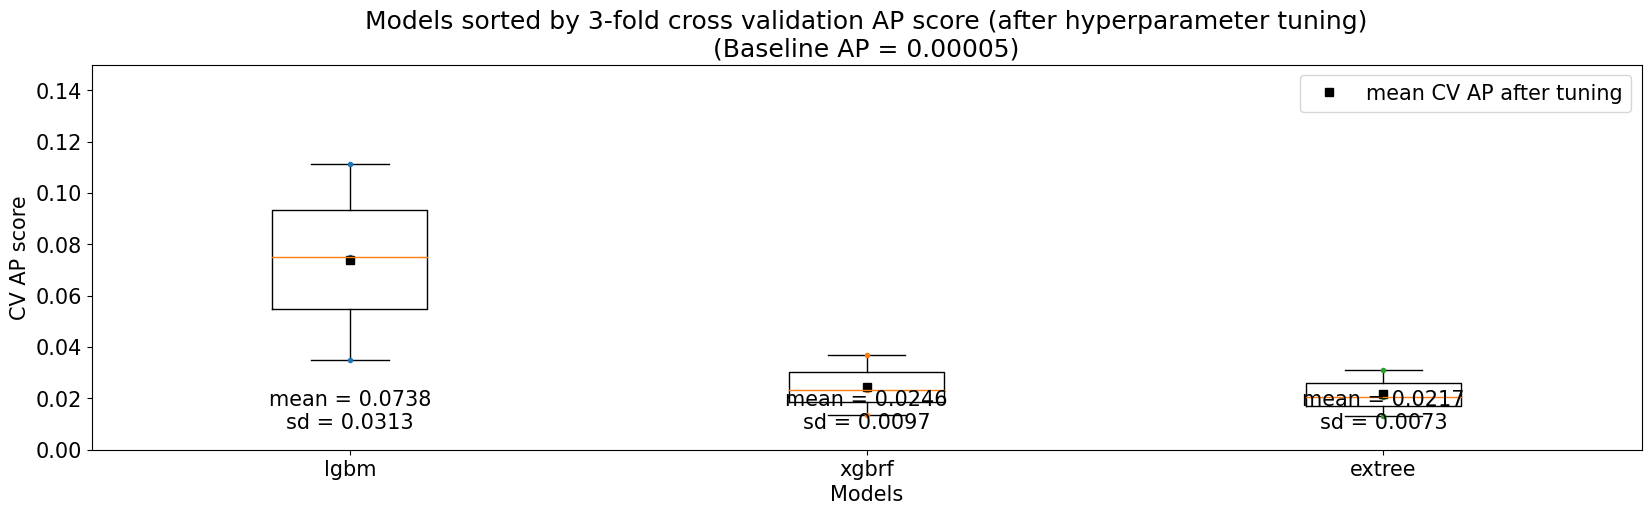

In [ ]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.015), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
# plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted_train_AP, 
#          "b^", label = 'Train set AP after tuning')
plt.legend()
plt.title(f"Models sorted by {cv_split.get_n_splits()}-fold cross validation AP score (after hyperparameter tuning)\n(Baseline AP = {(y_prep.sum() / y_prep.size):0.5f})")
plt.xlabel("Models")
plt.ylim(0,0.15)
plt.ylabel("CV AP score")
plt.show()

## AUROC

In [ ]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

# fit each tuned model and calculate 5-fold CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(X_subset_prep, y_prep)
  auc_CV = cross_val_score(clf, X_subset_prep, y_prep, cv = cv_split, scoring = 'roc_auc', n_jobs = -1)  
  # precision, recall, thresholds = precision_recall_curve(y_prep, clf.predict_proba(X_subset_prep))

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  try:
    auc_train.append(roc_auc_score(y_prep, clf.predict_proba(X_subset_prep)[:, 1]))
  except:
    auc_train.append(roc_auc_score(y_prep, clf.decision_function(X_subset_prep)))
  # list_precision.append(precision)
  # list_recall.append(recall)
  # list_thresholds.append(thresholds)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.10s/it]


In [ ]:
mean_auc_CVs = [np.mean(auc) for auc in auc_CVs]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_auc_CVs, tuned_models.keys()), reverse = True)]
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_auc_CVs, auc_CVs), reverse = True)]
# sorted_train_AUC = [i for _, i in sorted(zip(mean_auc_CVs, auc_train), reverse = True)]

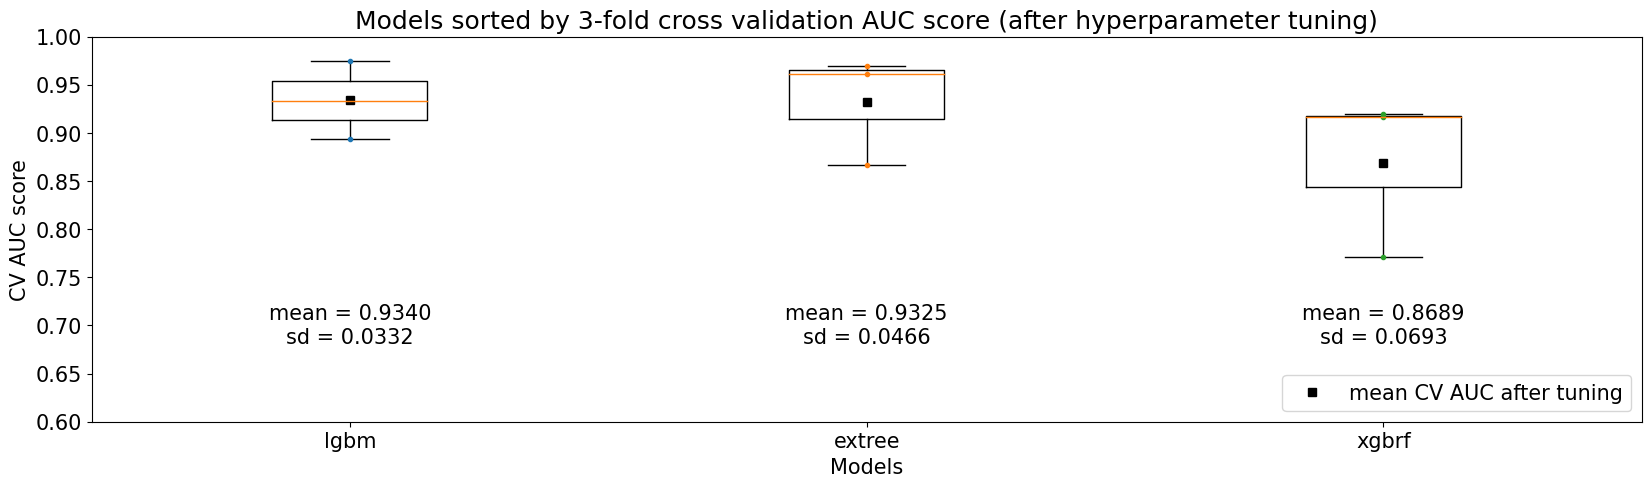

In [ ]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
#          "b^", label = 'Train set AUC after tuning')
plt.legend(loc = 'lower right')
plt.title(f"Models sorted by {cv_split.get_n_splits()}-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0.6,1)
plt.ylabel("CV AUC score")
plt.show()

## Lift and gain

In [ ]:
y_score = tuned_models['extree'].predict_proba(X_subset_prep)

y_probs_train = y_score[:,1]

temp_df = pd.DataFrame({
    'y': y_prep,
    'prob': y_probs_train
})
# temp_df = temp_df.drop_duplicates(subset=['prob'])
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [ ]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)
lift_n_gain

sum_of_positive_cases_identified   gain   lift
decile                                                
1                                     26 0.8667 8.6667
2                                      3 0.9667 4.8333
3                                      1 1.0000 3.3333
4                                      0 1.0000 2.5000
5                                      0 1.0000 2.0000
6                                      0 1.0000 1.6667
7                                      0 1.0000 1.4286
8                                      0 1.0000 1.2500
9                                      0 1.0000 1.1111
10                                     0 1.0000 1.0000

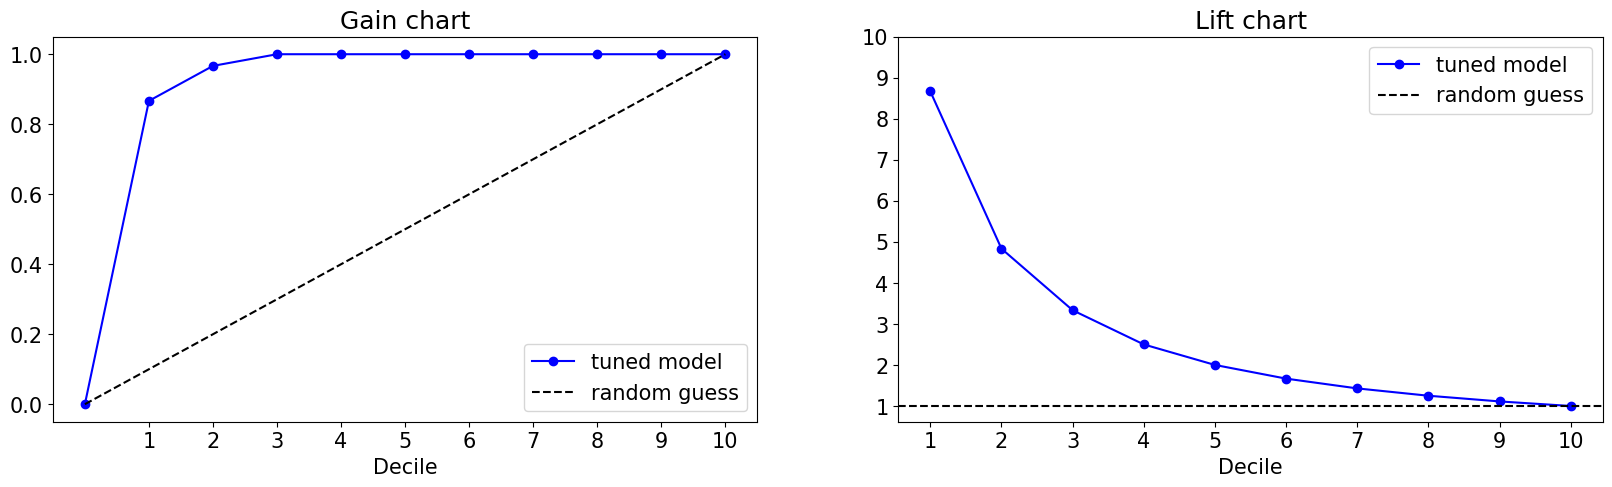

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(0,lift_n_gain.shape[0] + 1,1), [0] + list(lift_n_gain['gain'].values), 'bo-', label = 'tuned model')
axes[0].plot(np.arange(0,lift_n_gain.shape[0] + 1,1), np.arange(0,lift_n_gain.shape[0] + 1,1) / lift_n_gain.shape[0], 'k--', label = 'random guess')
axes[1].plot(np.arange(1,lift_n_gain.shape[0] + 1,1), lift_n_gain['lift'].values, 'bo-', label = 'tuned model')
axes[1].axhline(1, color = 'k', linestyle='--', label = 'random guess')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
for ax in axes:
  ax.set_xticks(np.arange(1,lift_n_gain.shape[0] + 1,1))
  ax.set_xlabel("Decile")
  ax.legend()
axes[1].set_yticks(np.arange(1,lift_n_gain.shape[0] + 1,1))
plt.show()

# Read test set

In [ ]:
test_set = pd.read_pickle("Task_3B_test.pkl")

## load dataset_preparation()

In [ ]:
dataset_preparation = load('dataset_preparation.joblib')
dataset_preparation

Pipeline(steps=[('manualtransformer', ManualTransformer()),
                ('outlierremoval', OutlierRemoval())])

In [ ]:
test_clean = dataset_preparation.transform(test_set)
test_clean

GENDER occupation_risk RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  \
0       Female            High            1                  1      0   
1       Female             Low            1                  1      0   
2         Male            High            1                  1      0   
3         Male        Moderate            1                  1      0   
4       Female             Low            1                  1      0   
...        ...             ...          ...                ...    ...   
399995  Female             Low            1                  1      0   
399996    Male             Low            1                  1      0   
399997  Female             Low            1                  1      0   
399998    Male             Low            1                  1      1   
399999  Female             Low            1                  1      0   

       COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY  CASH_CNT_IN  CASH_CNT_OUT  \
0                      Low                    Low      14.0000       18.0000   
1                      Low                    Low       0.0000        6.0000   
2                      Low                    Low       0.0000       13.0000   
3                      Low                    Low       3.0000        4.0000   
4                      Low                    Low       2.0000       59.0000   
...                    ...                    ...          ...           ...   
399995                 Low                    Low       1.0000       12.0000   
399996                 Low                    Low       8.0000        6.0000   
399997                 Low                    Low      36.0000       21.0000   
399998                 Low                    Low      23.0000       63.0000   
399999                 Low                    Low      18.0000       79.0000   

        WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  embedding_1  embedding_2  \
0           123.0000       188.0000      -0.0042      -0.0012      -0.0039   
1            18.0000       149.0000      -0.0248      -0.0273       0.0494   
2            23.0000        14.0000       0.0046       0.0047      -0.0010   
3            16.0000        63.0000      -0.0143       0.0051       0.0260   
4            28.0000        67.0000       0.0003      -0.0004       0.0017   
...              ...            ...          ...          ...          ...   
399995      123.0000       132.0000       0.0024       0.0014       0.0014   
399996       34.0000        66.0000      -0.0030       0.0044       0.0049   
399997      227.0000       327.0000      -0.0312      -0.0043       0.0287   
399998       50.0000       192.0000       0.0042       0.0006       0.0037   
399999      210.0000       354.0000       0.0013      -0.0020       0.0044   

        embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  \
0           -0.0032       0.0026      -0.0031       0.0005      -0.0002   
1            0.0105       0.0697      -0.0122       0.0109       0.0501   
2            0.0016      -0.0025      -0.0016       0.0026       0.0040   
3           -0.0008       0.0278       0.0116       0.0239       0.0149   
4            0.0041       0.0048       0.0001       0.0043      -0.0046   
...             ...          ...          ...          ...          ...   
399995       0.0015       0.0037       0.0041      -0.0049       0.0030   
399996       0.0041       0.0034      -0.0019      -0.0037       0.0046   
399997       0.0094       0.0407       0.0061       0.0025       0.0246   
399998       0.0015       0.0044       0.0026       0.0013      -0.0020   
399999      -0.0047      -0.0017       0.0006      -0.0010       0.0001   

        embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  \
0           -0.0039       0.0032        0.0042       -0.0003        0.0027   
1           -0.1003       0.0316       -0.0142        0.0105        0.0367   
2           -0.0025      -0.0032        0.0006        0.0011        0.0048   
3           -0.0186 

## X,y, sample_weights split

In [ ]:
# make a copy and split X and y
X_test = test_clean.drop(columns = ["BAD_ACTOR", "TOTAL_SUM"]).reset_index(drop = True).copy(deep = True)
y_test = test_clean["BAD_ACTOR"].reset_index(drop = True)
sample_weights_test = test_clean["TOTAL_SUM"].reset_index(drop = True)

In [ ]:
# multiclass
y_test_prep = y_test.to_numpy() 

## load data_preparation()

In [ ]:
data_preparation = load('data_preparation.joblib')
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('myquantiletransformer',
                                                                   MyQuantileTransformer(n_quantiles=100000,
                                                                                         output_distribution='normal',
                                                                                         random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001814B4ED880>),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                  ['GENDER', 'RES_CNTRY_CA',
                                                   'CNTRY_OF_INCOME_CA',
                                                   'PEP_FL', 'MISSING_NAME',
                                                   'DIFF_CNTRY',
                                                   'DATA_ENTRY_ERROR']),
                                                 ('ord',
                                                  Pipeline(steps=[('randomimputer',
                                                                   RandomImputer()),
                                                                  ('thermometerencoder',
                                                                   ThermometerEncoder()),
                                                                  ('myminmaxscaler',
                                                                   MyMinMaxScaler(feature_range=(-2,
                                                                                                 2)))]),
                                                  ['occupation_risk',
                                                   'COUNTRY_RISK_INCOME',
                                                   'COUNTRY_RISK_RESIDENCY'])],
                                   verbose_feature_names_out=False))])

In [ ]:
X_test_prep = pd.DataFrame(data_preparation.transform(X_test), columns=data_preparation.get_feature_names_out())
X_test_prep

CASH_CNT_IN  CASH_CNT_OUT  WIRES_CNT_IN  WIRES_CNT_OUT  embedding_0  \
0            0.8948        0.0337        0.6861         0.4734       0.0764   
1           -5.1993       -0.8863       -1.0966         0.1901      -0.3485   
2           -5.1993       -0.2831       -0.9345        -1.5449       1.6977   
3           -0.6062       -1.1449       -1.1686        -0.6232      -0.1254   
4           -0.8985        1.4916       -0.8017        -0.5744       0.6724   
...             ...           ...           ...            ...          ...   
399931      -1.3221       -0.3538        0.6861         0.0556       1.0382   
399932       0.2922       -0.8863       -0.6570        -0.5860       0.2169   
399933       2.1805        0.1960        1.7514         1.3303      -0.5262   
399934       1.4526        1.5848       -0.3410         0.5009       1.5405   
399935       1.1669        1.9422        1.5923         1.4753       0.8355   

        embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0            0.1920      -1.5083      -0.7857      -0.3006      -0.7235   
1           -1.1827       0.6239       0.8683       0.9154      -1.4050   
2            1.3303      -0.8095       0.0353      -1.1174      -0.4556   
3            1.4374       0.1407      -0.3502       0.1866       0.9480   
4            0.3060      -0.4276       0.4594      -0.0286      -0.1819   
...             ...          ...          ...          ...          ...   
399931       0.6052      -0.4596       0.0215      -0.1672       0.4783   
399932       1.2385      -0.0192       0.4516      -0.1977      -0.5011   
399933      -0.2780       0.1834       0.8202       0.4643       0.6976   
399934       0.4756      -0.1681       0.0197      -0.0812       0.2155   
399935       0.0766      -0.0793      -1.1189      -0.9416      -0.1094   

        embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
0           -0.1163      -0.6293       0.1674      -0.1371        1.4157   
1            0.8993       1.0036      -1.0086       0.8485       -0.3973   
2            0.2045      -0.0886       0.3371      -1.1516        0.6380   
3            1.2969       0.1804      -0.0095       0.1359       -0.3225   
4            0.4941      -1.6627       0.8637      -1.1731       -0.0855   
...             ...          ...          ...          ...           ...   
399931      -1.1596      -0.2101       1.0721      -1.0347        1.6479   
399932      -0.8858      -0.0074       0.8119      -1.0307        1.3367   
399933       0.1899       0.4331      -0.4696       0.4946       -0.7519   
399934       0.0042      -0.9485       0.3713      -0.0165        1.2521   
399935      -0.3734      -0.5926       0.8825      -0.4598        0.3697   

        embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
0            -0.3848       -0.2061        0.3317       -1.7029        0.7304   
1             0.7029        0.9060       -1.0751        0.7305       -0.6757   
2            -0.1633        0.0593        0.8468       -0.8355        0.6172   
3            -0.0334        0.1145       -0.0554        0.2141       -0.1864   
4            -0.8784       -0.2104        0.4975       -0.2792        1.7135   
...              ...           ...           ...           ...           ...   
399931       -0.6091       -0.5473        1.4147       -0.3602        0.9852   
399932        0.2074       -1.7362        0.9565       -0.2167        0.1579   
399933        0.0906        0.1420       -0.4337        0.5095       -0.4432   
399934       -0.2795       -1.0964        0.3209       -0.3308        0.2892   
399935       -0.4753       -0.5759        0.6704       -1.2037        1.1835   

        embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  \
0            -1.0829       -0.6820        0.4095       -0.1290       -1.1031   
1             0.6953        0.9306       -0.7940       -1.1422        0.8544   
2            -1.9102       -1.5990        0.

## test optuna performance

In [ ]:
# df_test = predict_LGBM(models,X_test_prep, X_test_prep.columns.tolist(), 'Pred')
# average_precision_score(y_test_prep, df_test["Pred"])

## load model

In [ ]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_IMI_(\w+).joblib'

for current_time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(current_time, "%Y%m%d_%H%M%S"))
  time_list.append(current_time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "IMI loaded", latest)

extree IMI loaded 20230322_183533
lgbm IMI loaded 20230322_183533
xgbrf IMI loaded 20230322_183533


## Pick best model

In [ ]:
best_model = tuned_models['lgbm'].best_estimator_
best_model

Pipeline(steps=[('lgbm',
                 LGBMClassifier(bagging_fraction=0.8498180112482666,
                                bagging_freq=1, class_weight='balanced',
                                extra_trees=True,
                                feature_fraction=0.18065687109717385,
                                lambda_l1=27.257624858426954,
                                lambda_l2=0.010196522688484377, max_bin=232,
                                max_depth=29, min_data_in_leaf=14,
                                min_gain_to_split=0.0006282024627427977,
                                num_leaves=28))])

# Evaluation on test set

# Model performance on test set

## Predicted Probabilities distribution

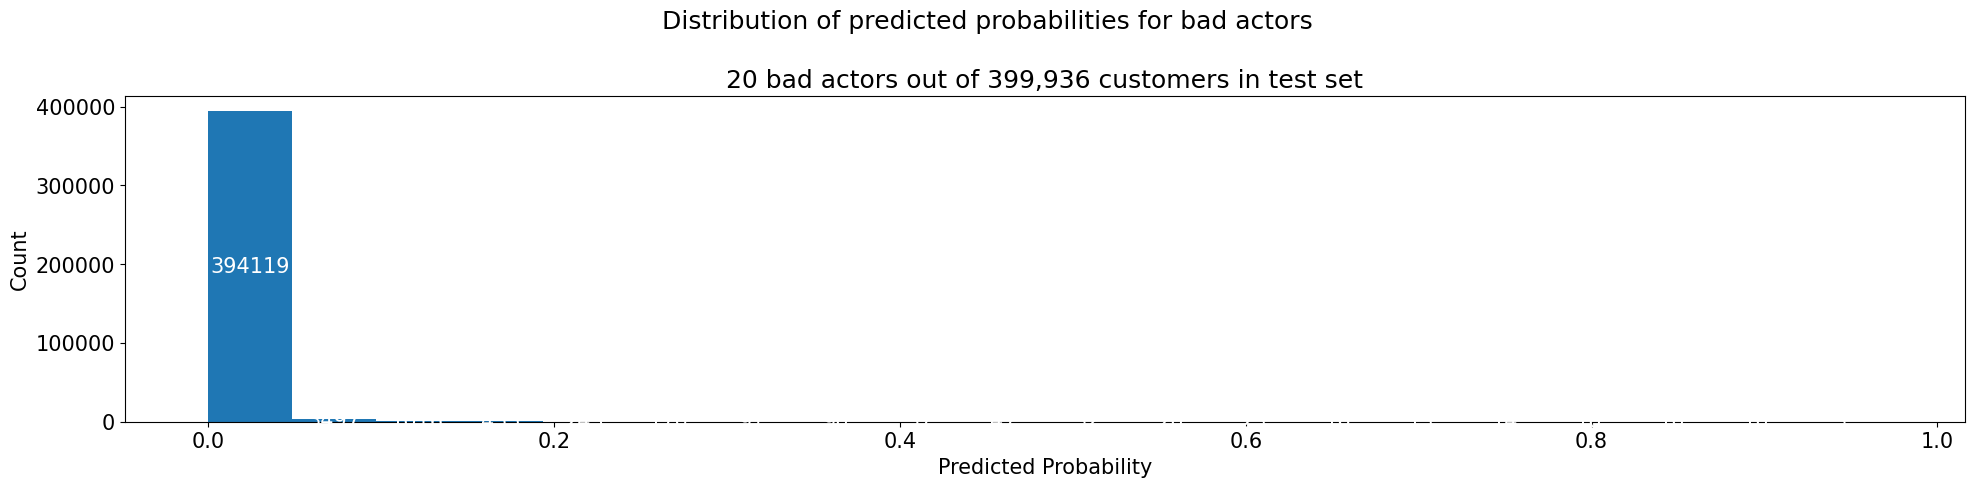

In [ ]:
# prediction
y_score = best_model.predict_proba(X_test_prep)
fig, ax = plt.subplots(1,1)

y_probs = y_score[:,1]
ax.hist(y_probs, bins = 20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
# ax.set_xlim(0,1)
# ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Count")
ax.set_title(f"{y_test_prep.sum():,.0f} bad actors out of {y_test_prep.size:,.0f} customers in test set")

plt.suptitle("Distribution of predicted probabilities for bad actors")
plt.tight_layout()
plt.show()

## Average Precision
- Average precision = area under precision-recall curve
  - [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

In [ ]:
CV_model = tuned_models[best_model.steps[-1][0]]
cv_result = pd.DataFrame(CV_model.cv_results_)
cv_AP_colindex = [i for i, x in enumerate(cv_result.columns.values) if re.search('split\w+_test_score', x) is not None]
best_CV_AP = pd.DataFrame(CV_model.cv_results_).iloc[CV_model.best_index_,cv_AP_colindex].values

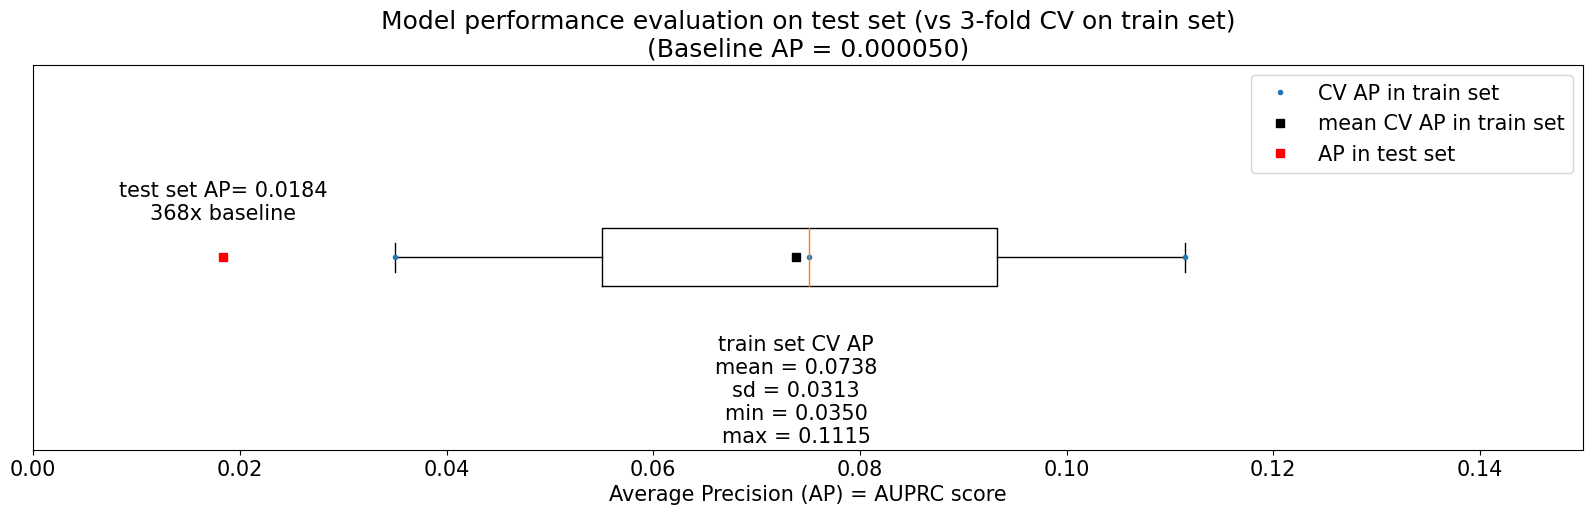

In [ ]:
# plot CV AP scores on train set
plt.boxplot(best_CV_AP, labels = [""], vert=False)
plt.plot(best_CV_AP, [1]*len(best_CV_AP), ".", label='CV AP in train set')
plt.annotate(f"train set CV AP\n" + 
             f"mean = {np.mean(best_CV_AP):0.4f}\n" + 
             f"sd = {np.std(best_CV_AP):0.4f}\n" + 
             f"min = {np.min(best_CV_AP):0.4f}\n" + 
             f"max = {np.max(best_CV_AP):0.4f}",
             (np.mean(best_CV_AP), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AP), [1], "ks", label = 'mean CV AP in train set')

# compare with AP score on test set
test_AP = average_precision_score(y_test, y_probs)
plt.plot(test_AP, [1], "rs", label = 'AP in test set')
plt.annotate(f"test set AP= {test_AP:0.4f}\n{test_AP / (y_test_prep.sum() / y_test_prep.size):0.0f}x baseline",(test_AP, 1.2), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs {cv_split.get_n_splits()}-fold CV on train set)\n(Baseline AP = {y_test_prep.sum() / y_test_prep.size:0.6f})")
plt.xlabel("Average Precision (AP) = AUPRC score")
plt.xlim(0.0, 0.15)
plt.ylabel("")
plt.yticks([])
plt.show()

## Lift and gain chart

In [ ]:
temp_df = pd.DataFrame({
    'y': y_test_prep,
    'prob': y_probs
})
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [ ]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / temp_df.decile.nunique())

In [ ]:
lift_n_gain

sum_of_positive_cases_identified   gain   lift
decile                                                
1                                     14 0.7000 7.0000
2                                      2 0.8000 4.0000
3                                      1 0.8500 2.8333
4                                      2 0.9500 2.3750
5                                      1 1.0000 2.0000
6                                      0 1.0000 1.6667
7                                      0 1.0000 1.4286
8                                      0 1.0000 1.2500
9                                      0 1.0000 1.1111
10                                     0 1.0000 1.0000

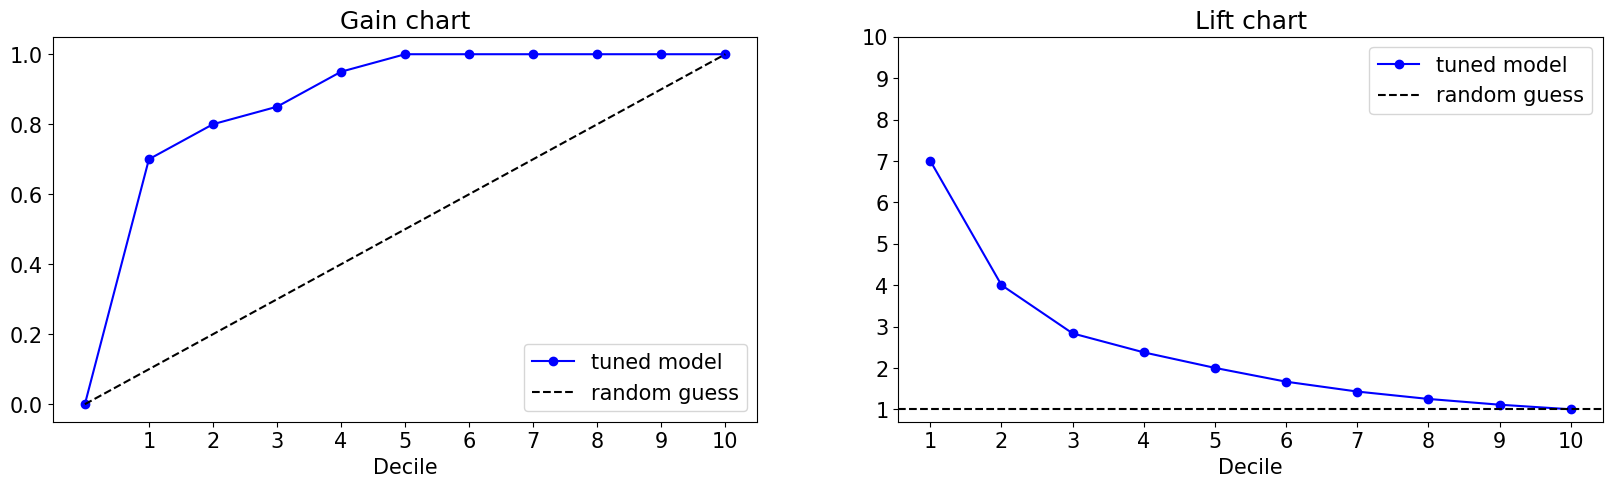

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(0,lift_n_gain.shape[0]+1,1), [0] + list(lift_n_gain['gain'].values), 'bo-', label = 'tuned model')
axes[0].plot(np.arange(0,lift_n_gain.shape[0]+1,1), np.arange(0,lift_n_gain.shape[0]+1,1) / lift_n_gain.shape[0], 'k--', label = 'random guess')
axes[1].plot(np.arange(1,lift_n_gain.shape[0]+1,1), lift_n_gain['lift'].values, 'bo-', label = 'tuned model')
axes[1].axhline(1, color = 'k', linestyle='--', label = 'random guess')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
for ax in axes:
  ax.set_xticks(np.arange(1,11,1))
  ax.set_xlabel("Decile")
  ax.legend()
axes[1].set_yticks(np.arange(1,11,1))
plt.show()

## AUROC

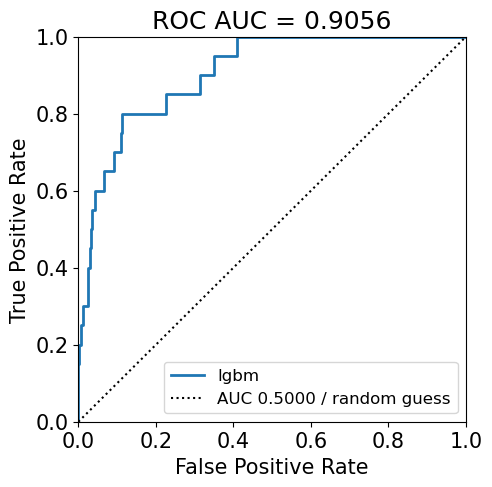

In [ ]:
fpr, tpr, _ = roc_curve(y_test_prep, y_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"{best_model.steps[-1][0]}")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test_prep, y_probs):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right', prop={'size': 12})

plt.show()

# Probability cutoff

## Precision Recall Curve

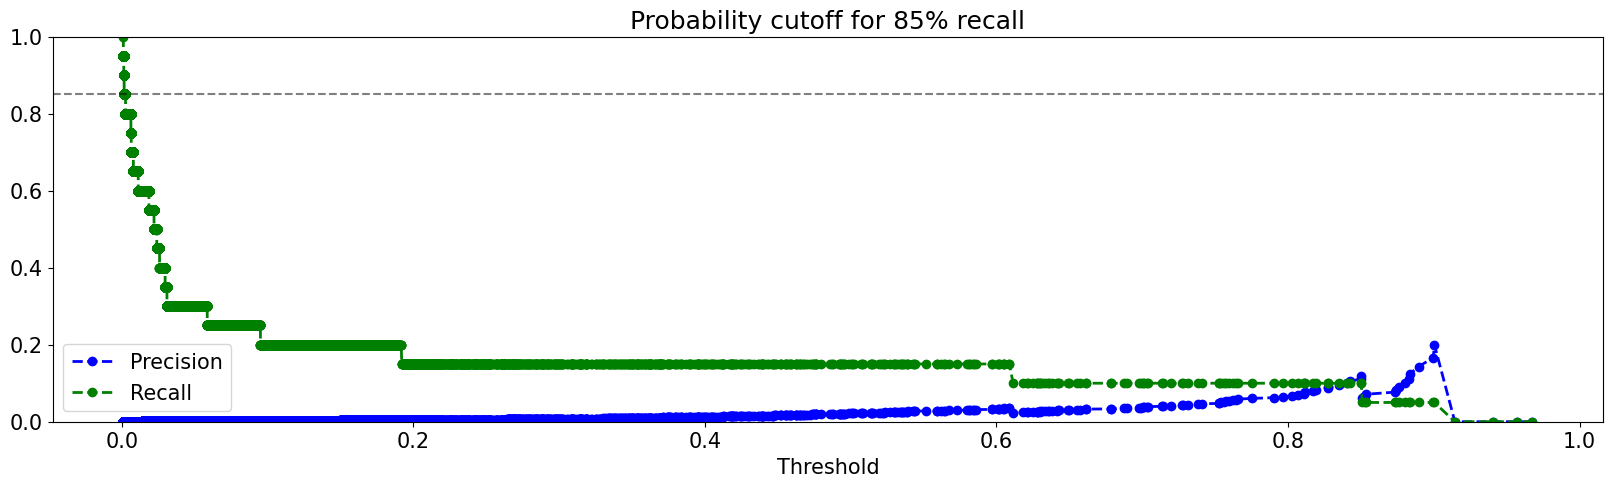

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_prep, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.axhline(0.85, ls='--', c='k', alpha=0.5)
plt.title("Probability cutoff for 85% recall")
plt.legend()
plt.show()

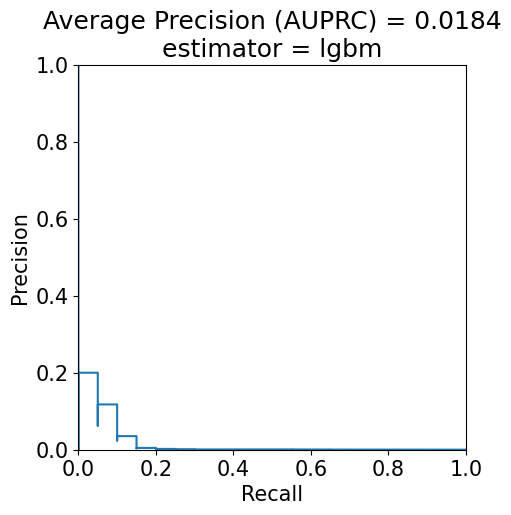

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot(ax=ax)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Average Precision (AUPRC) = {average_precision_score(y_test_prep, y_probs):0.4f}\nestimator = {best_model.steps[-1][0]}")
plt.show()

## Cost sensitive cutoff

### misclassification loss = 0 to 100%

In [ ]:
# as a % of revenue per customer
misclassification_matrix = np.array([
    [0.0, y_test_prep.sum() / y_test_prep.size],
    [1 - y_test_prep.sum() / y_test_prep.size, 0.0]
    ])

In [ ]:
def plot_misclassification_losses(y_pred, cutoff = None):
  # y_pred, cutoff
  fig, axes = plt.subplots(1,3)
  ConfusionMatrixDisplay(
      misclassification_matrix,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[0], values_format='.4%')
  axes[0].set_title('Asymmetric loss matrix\n(misclassification loss as %)', fontsize = 14)

  confusion_mat = confusion_matrix(y_test_prep, y_pred)

  ConfusionMatrixDisplay(
      confusion_mat,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[1], values_format=',.0f')
  axes[1].set_title(f"Confusion matrix\n({np.sum(confusion_mat):,.0f} customers)", fontsize = 14)

  rev_per_customer = 100
  total_loss = confusion_mat * misclassification_matrix * rev_per_customer
  ConfusionMatrixDisplay(
      total_loss,
      display_labels=y_test.cat.categories).plot(cmap = 'Blues', ax = axes[2], values_format=',.0f')
  axes[2].set_title(f'Total misclassification losses\n(${rev_per_customer} from each customer)', fontsize = 14)

  plt.tight_layout(rect=[0, 0.03, 1, 0.85])
  number_of_misclassified_customers = confusion_mat.flatten()[1:3].sum()
  if cutoff is None:
    plt.suptitle(f"""Loss per missclassified customer = ${np.sum(total_loss) / number_of_misclassified_customers:,.4f} with cutoff = 0.5
    (or \${np.sum(total_loss):,.0f} in total for {np.sum(confusion_mat):,.0f} customers)""")
  else:
    plt.suptitle(f"""Loss per missclassified customer = ${np.sum(total_loss) / number_of_misclassified_customers:,.4f} with cutoff = [{cutoff:0.4f} for bad actor]
    (or \${np.sum(total_loss):,.0f} in total for {np.sum(confusion_mat):,.0f} customers)""")
  plt.show()

### default threshold

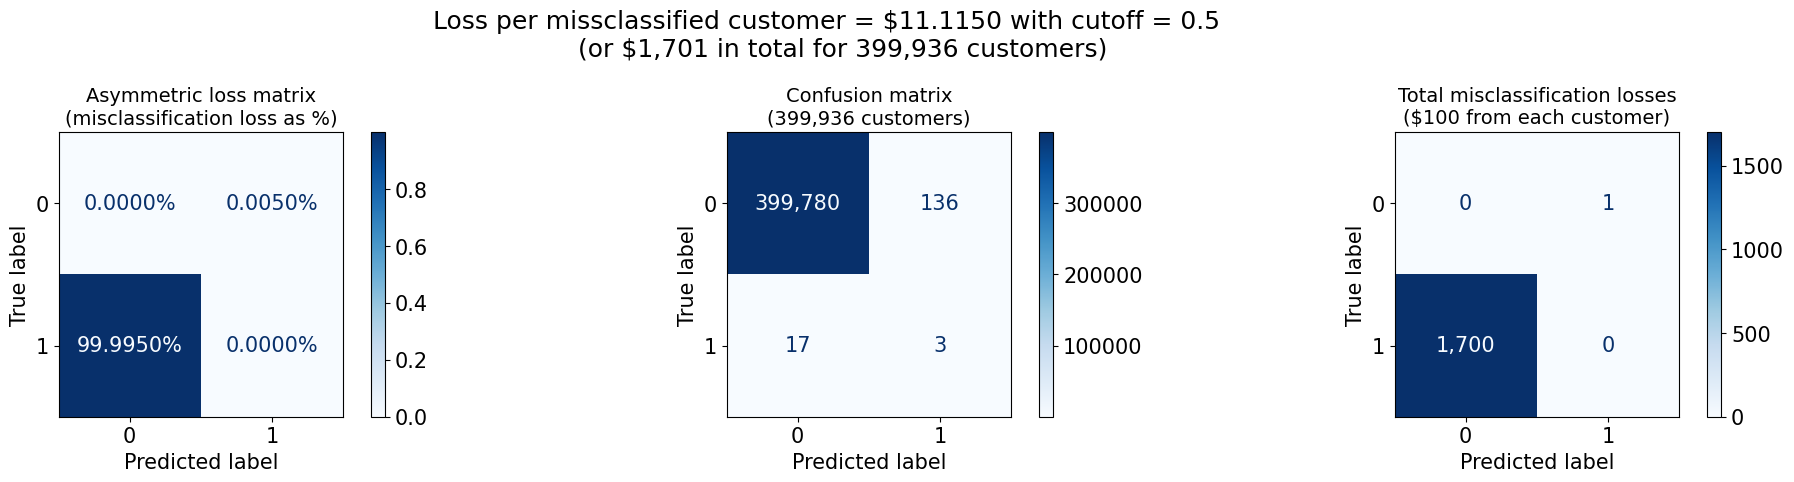

In [ ]:
plot_misclassification_losses(best_model.predict(X_test_prep), None)

In [ ]:
print(classification_report(y_test_prep, best_model.predict(X_test_prep)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    399916
           1       0.02      0.15      0.04        20

    accuracy                           1.00    399936
   macro avg       0.51      0.57      0.52    399936
weighted avg       1.00      1.00      1.00    399936



### optimized threshold

In [ ]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

chosen threshold:  0.8509083867
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    399916
           1       0.06      0.05      0.06        20

    accuracy                           1.00    399936
   macro avg       0.53      0.52      0.53    399936
weighted avg       1.00      1.00      1.00    399936



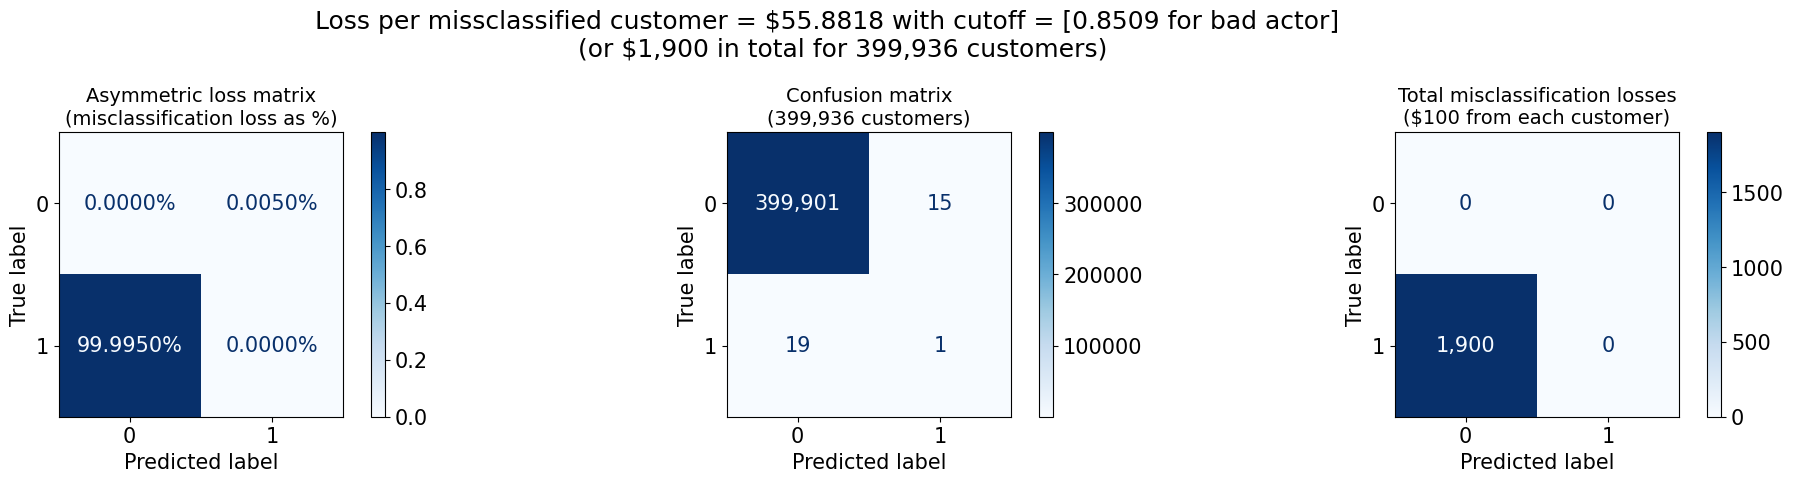

chosen threshold:  0.1920447398
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    399916
           1       0.00      0.15      0.01        20

    accuracy                           1.00    399936
   macro avg       0.50      0.57      0.50    399936
weighted avg       1.00      1.00      1.00    399936



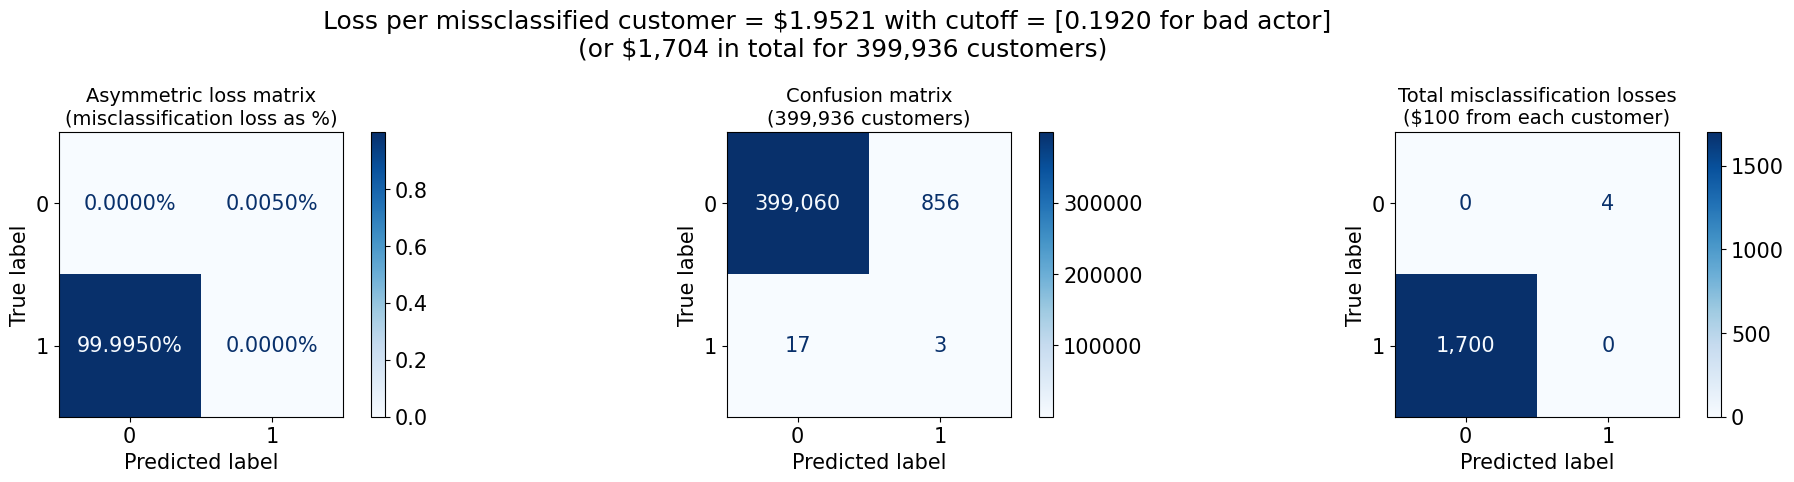

chosen threshold:  0.0309730518
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    399916
           1       0.00      0.30      0.00        20

    accuracy                           0.98    399936
   macro avg       0.50      0.64      0.49    399936
weighted avg       1.00      0.98      0.99    399936



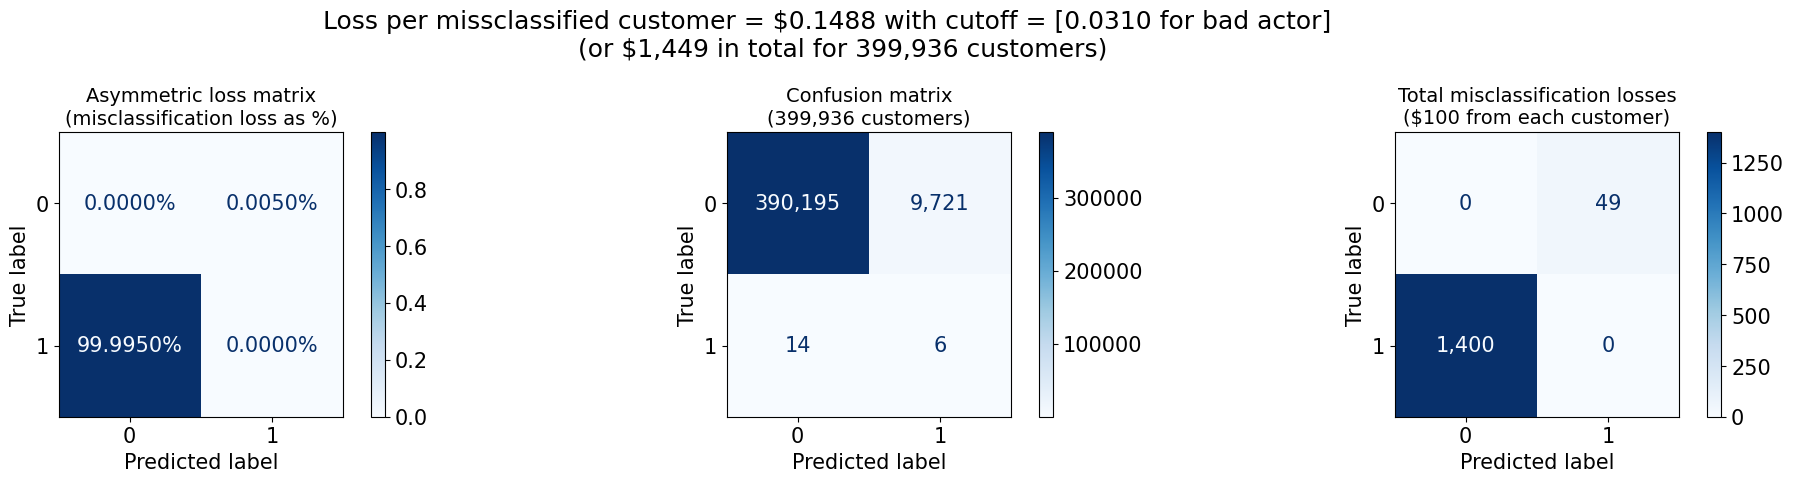

chosen threshold:  0.0297017190
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    399916
           1       0.00      0.35      0.00        20

    accuracy                           0.97    399936
   macro avg       0.50      0.66      0.49    399936
weighted avg       1.00      0.97      0.99    399936



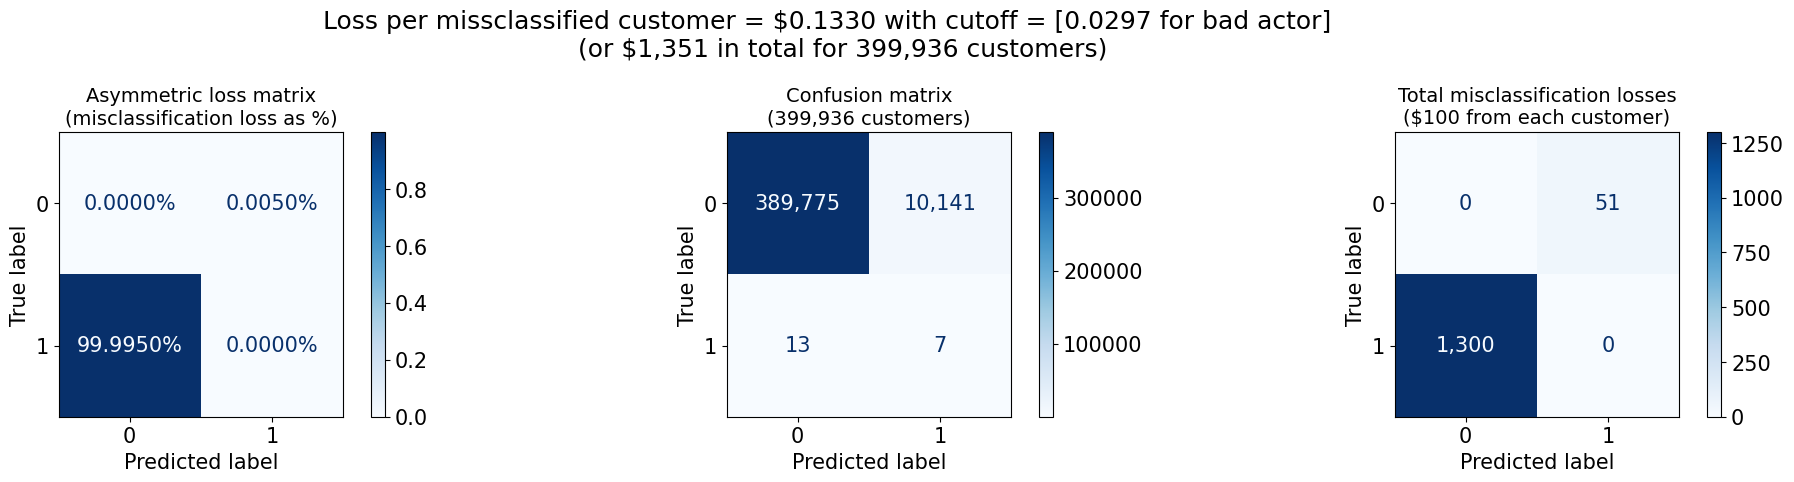

chosen threshold:  0.0239800198
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    399916
           1       0.00      0.45      0.00        20

    accuracy                           0.97    399936
   macro avg       0.50      0.71      0.49    399936
weighted avg       1.00      0.97      0.98    399936



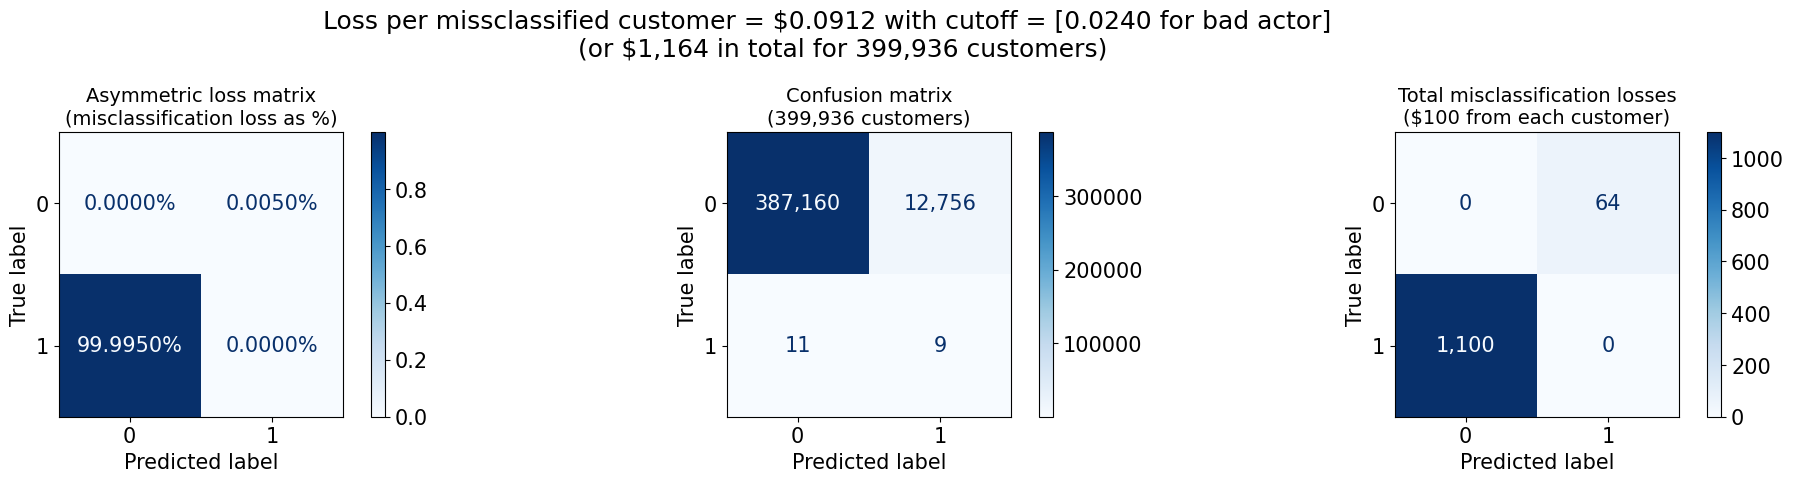

chosen threshold:  0.0186049986
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    399916
           1       0.00      0.55      0.00        20

    accuracy                           0.96    399936
   macro avg       0.50      0.75      0.49    399936
weighted avg       1.00      0.96      0.98    399936



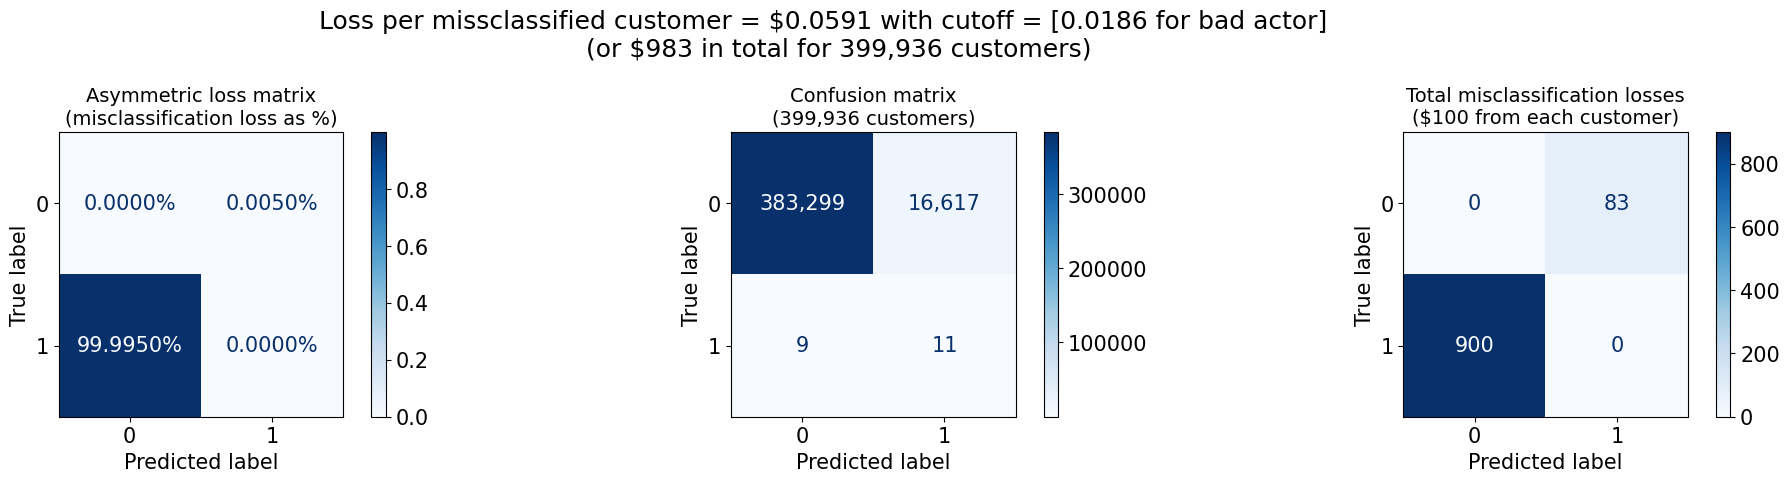

chosen threshold:  0.0064819194
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    399916
           1       0.00      0.70      0.00        20

    accuracy                           0.89    399936
   macro avg       0.50      0.80      0.47    399936
weighted avg       1.00      0.89      0.94    399936



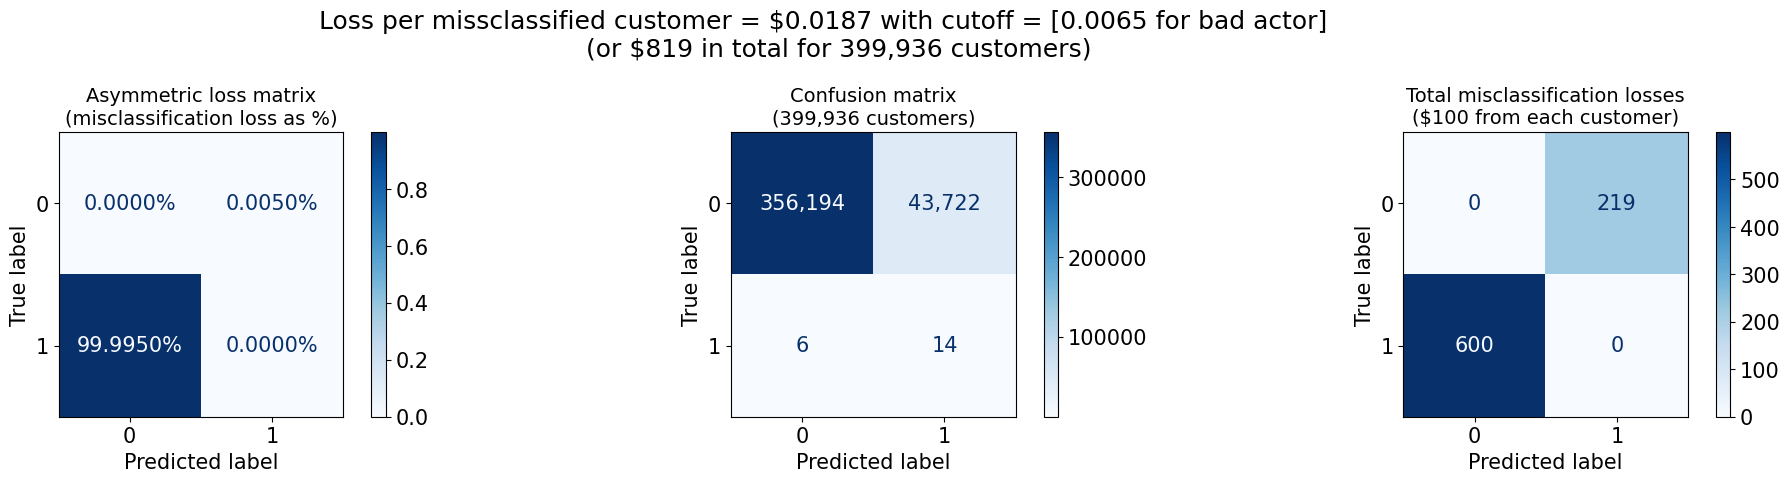

chosen threshold:  0.0062386173
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    399916
           1       0.00      0.75      0.00        20

    accuracy                           0.89    399936
   macro avg       0.50      0.82      0.47    399936
weighted avg       1.00      0.89      0.94    399936



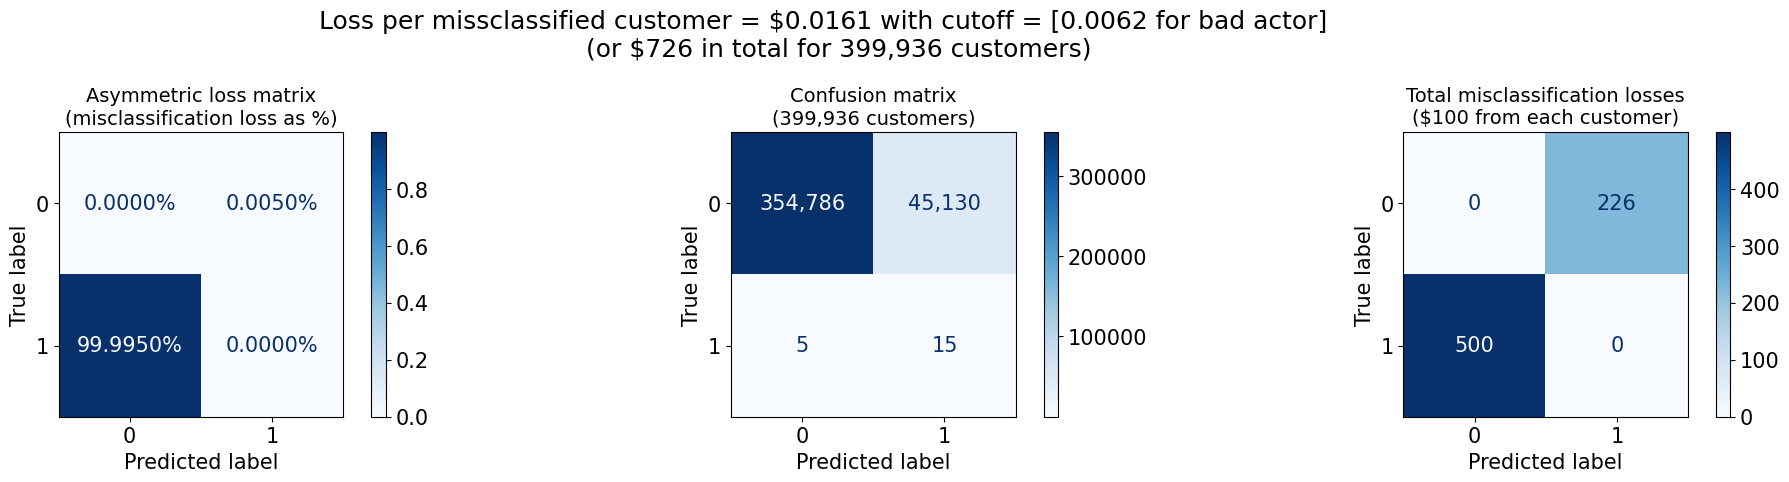

chosen threshold:  0.0015952552
              precision    recall  f1-score   support

           0       1.00      0.69      0.81    399916
           1       0.00      0.85      0.00        20

    accuracy                           0.69    399936
   macro avg       0.50      0.77      0.41    399936
weighted avg       1.00      0.69      0.81    399936



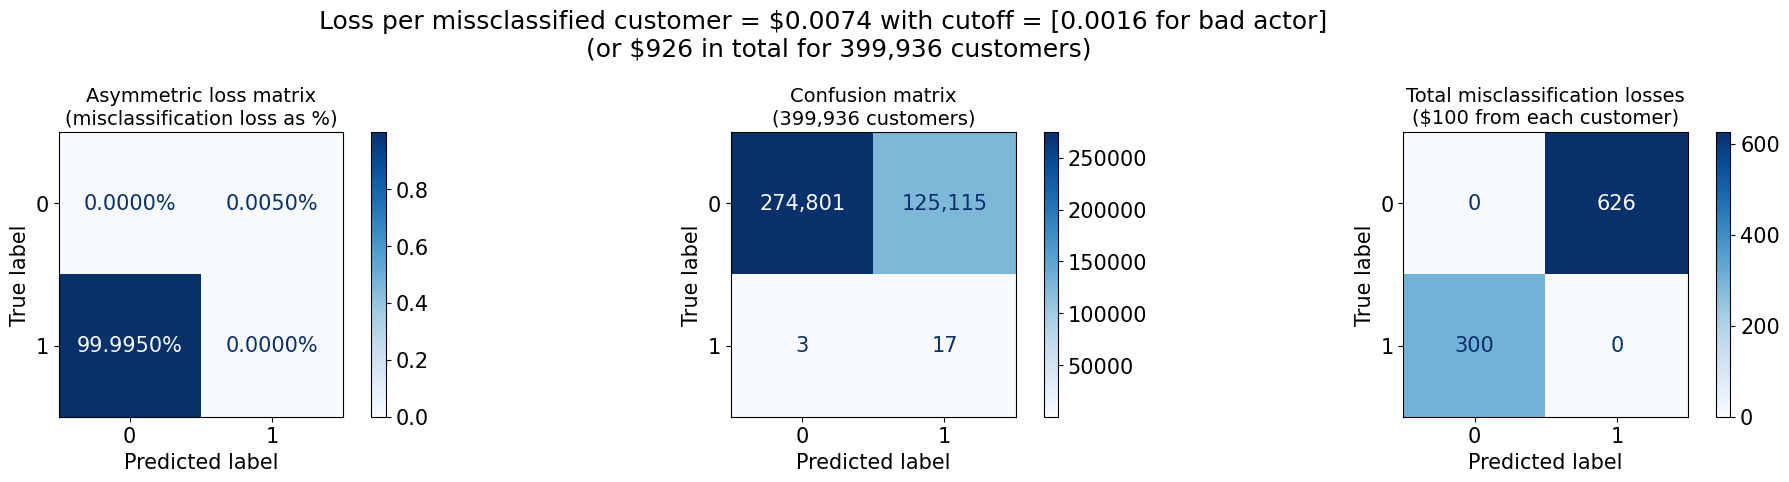

chosen threshold:  0.0010541307
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    399916
           1       0.00      0.95      0.00        20

    accuracy                           0.59    399936
   macro avg       0.50      0.77      0.37    399936
weighted avg       1.00      0.59      0.74    399936



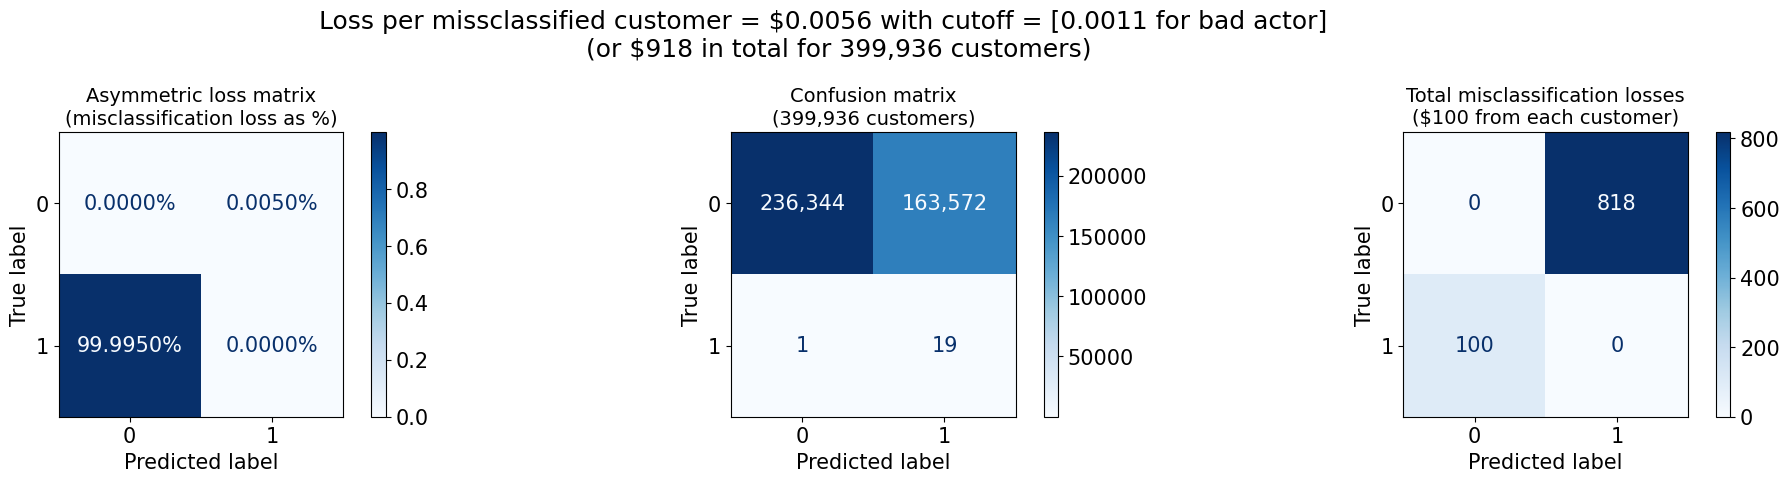

chosen threshold:  0.0010541160
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    399916
           1       0.00      1.00      0.00        20

    accuracy                           0.59    399936
   macro avg       0.50      0.80      0.37    399936
weighted avg       1.00      0.59      0.74    399936



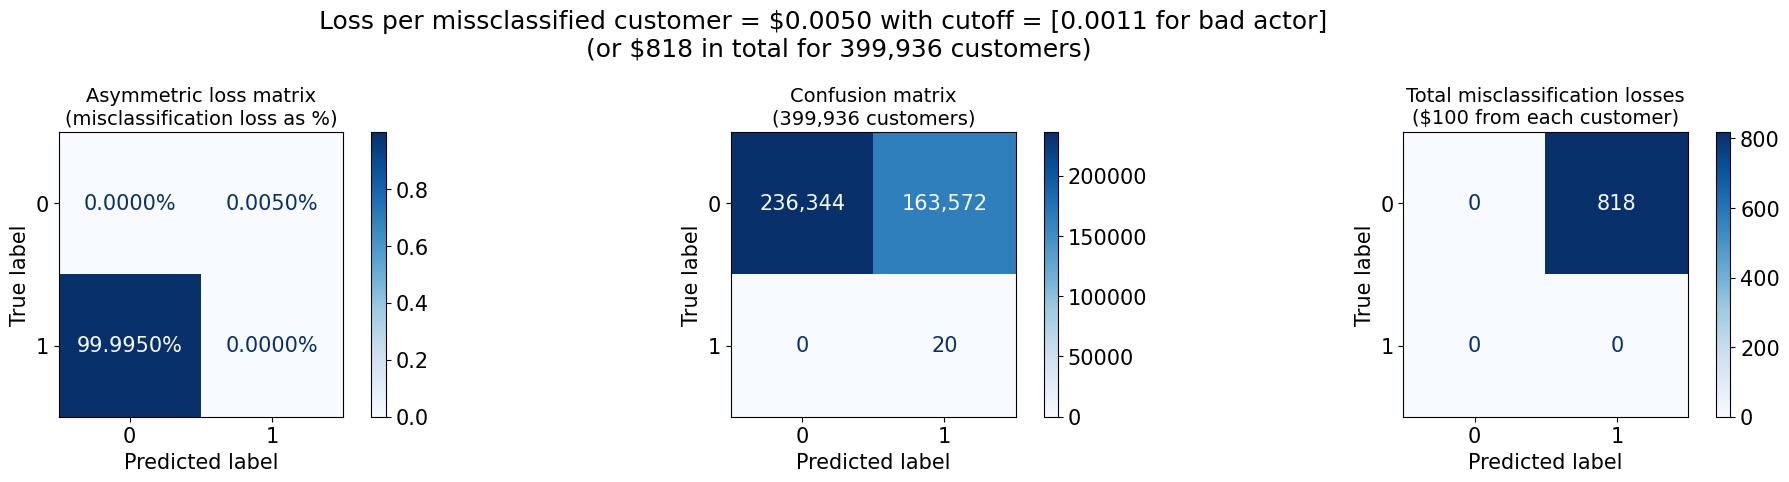

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
# to achieve a recall of 80% or more
for recall_pct in np.arange(0.1, 1.2, 0.1):
  # recall_pct = 1
  idx_for_chosen_recall = (recalls >= recall_pct).argmin()
  chosen_threshold = thresholds[idx_for_chosen_recall]
  print(f"chosen threshold: {chosen_threshold: 0.10f}")
  y_predict = (best_model.predict_proba(X_test_prep)[:,1] >= chosen_threshold)
  print(classification_report(y_test_prep, y_predict))

  y_pred_best = (y_score[:,1] >= chosen_threshold).astype(int)

  plot_misclassification_losses(y_pred_best, chosen_threshold)

# Interpretability

## Feature importances and Permutation importance (!increase to n_repeats=30)

Number of features after fitting estimator with regularization: 
135
features = ['embedding_16', 'occupation_risk_High', 'embedding_64', 'embedding_80', 'embedding_48', 'CASH_AVG_IN', 'embedding_8', 'AGE', 'embedding_32', 'embedding_20', 'CASH_BALANCE', 'embedding_90', 'WIRES_IN_CNT_VS_AVG', 'embedding_24', 'embedding_98', 'WIRES_BALANCE', 'COUNTRY_RISK_INCOME_High', 'WIRES_AVG_IN', 'embedding_96', 'embedding_68', 'WIRES_CNT_IN', 'embedding_40', 'embedding_6', 'embedding_36', 'CNTRY_OF_INCOME_CA_1', 'occupation_risk_Moderate', 'embedding_72', 'embedding_33', 'embedding_12', 'embedding_0', 'COUNTRY_RISK_INCOME_Moderate', 'embedding_56', 'embedding_78', 'embedding_76', 'embedding_38', 'WIRES_AVG_OUT', 'GENDER_Male', 'embedding_82', 'embedding_47', 'embedding_44', 'IN_pct_WIRES_CNT', 'COUNTRY_RISK_RESIDENCY_High', 'CASH_AVG_OUT', 'embedding_26', 'IN_VS_OUT_CASH_AVG', 'embedding_66', 'embedding_2', 'embedding_60', 'embedding_52', 'embedding_73', 'embedding_58', 'embedding_42', 'embedding_1

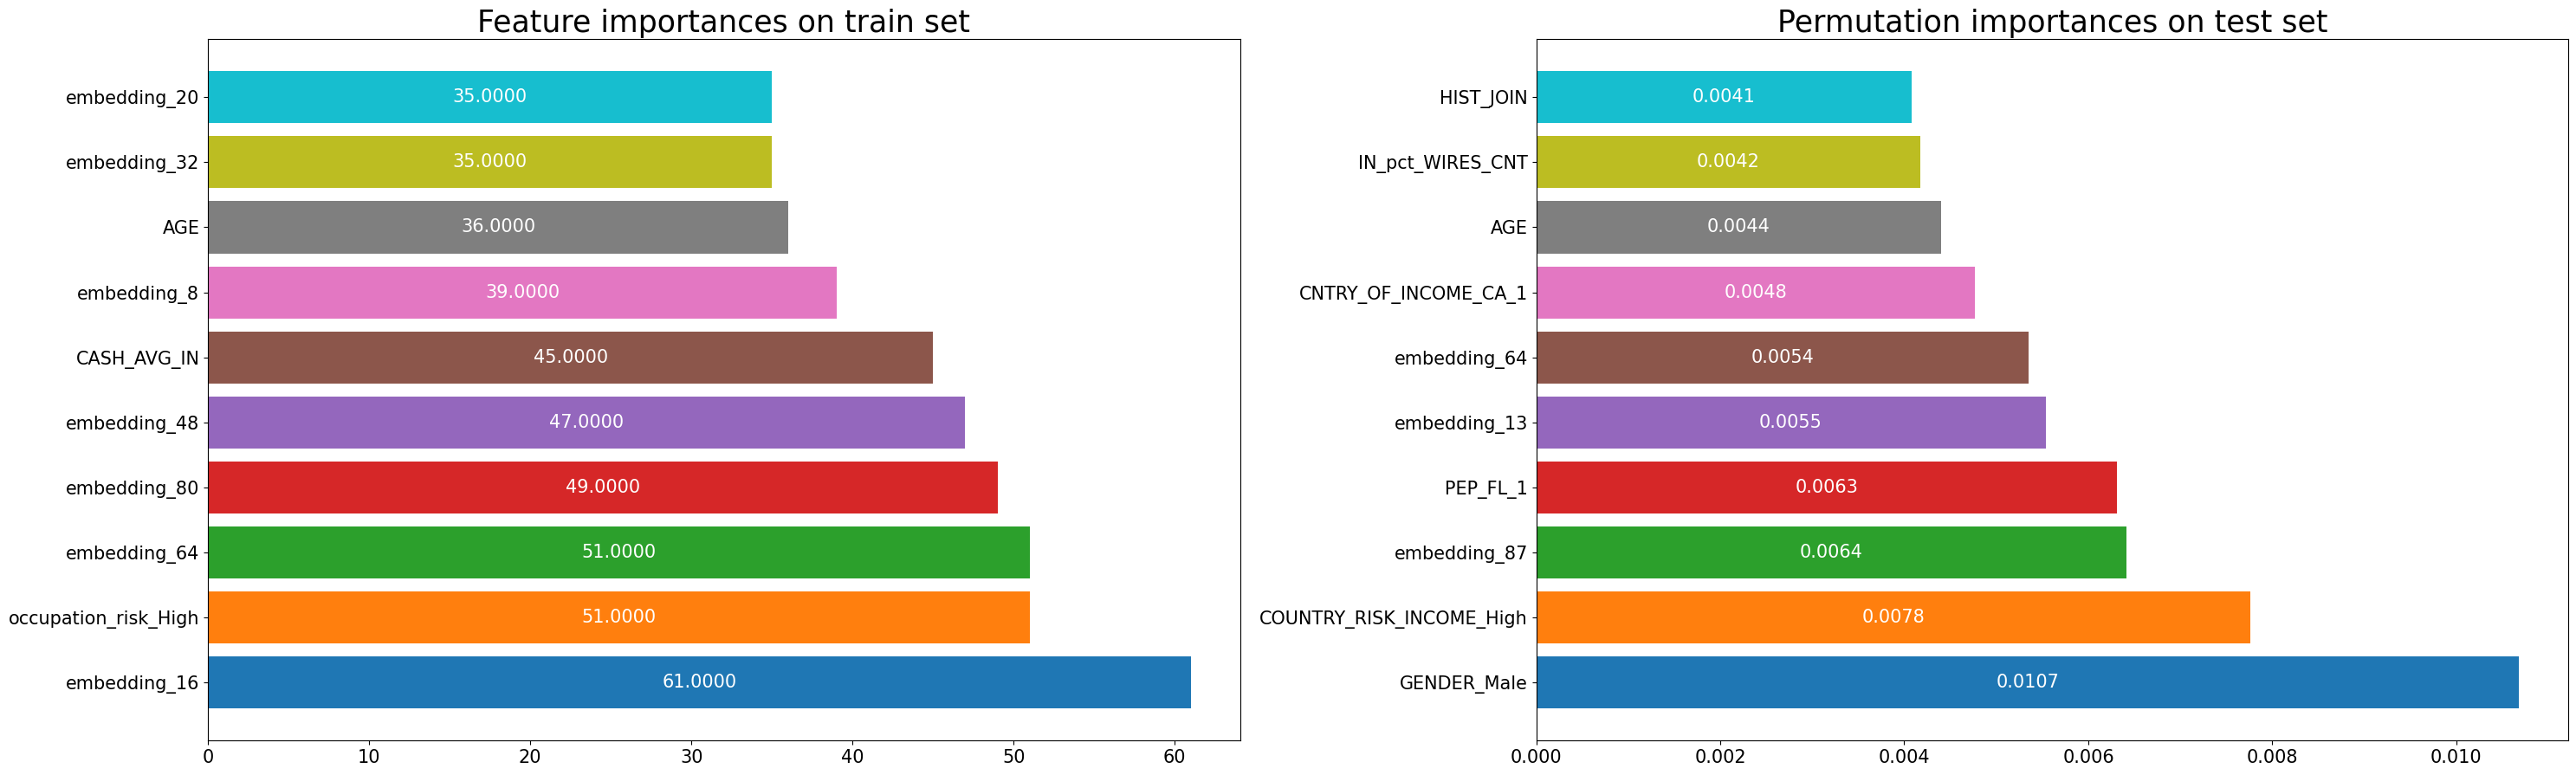

In [ ]:
# non-zero (signficant) features after regularization in fitting estimator
features_out = data_preparation.get_feature_names_out()
top_features = {}

fig, axes = plt.subplots(1,2, figsize = (30,10))

for xyz, ax in zip(range(2), axes.flatten()):

  if xyz == 0:
    try:
      coef = best_model.steps[-1][1].feature_importances_
    except:
      coef = best_model.steps[-1][1].coef_[0]
  elif xyz == 1:
    coef = permutation_importance(best_model.steps[-1][1], X_test_prep, y_test_prep, n_repeats=30, random_state=42, scoring = 'average_precision').importances_mean
  print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
  features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
  coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
  print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
  print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

  if xyz == 0:
    abs_coef = np.abs(coef)
  else:
    abs_coef = coef
  top_n = 10
  top_features[xyz] = sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]
  for i, (_, coef, name) in enumerate(top_features[xyz]):
    ax.barh(name, coef)
  for rect in ax.patches:
      width = rect.get_width()
      if xyz == 0:
        annot_txt = f"{width:0.4f}"
      else:
        annot_txt = f"{width:0,.4f}"
      ax.annotate(annot_txt,
                  xy=(width/2, rect.get_y() + rect.get_height() / 2),
                  xytext=(0, 0),  # 3 points vertical offset
                  textcoords="offset points",
                  fontsize = 15,
                  color = 'white',
                  ha='center', va='center')
  ax.tick_params(axis='both', which='major', labelsize=15)
  if xyz == 0:
    ax.set_title(f"Feature importances on train set", size = 25)
  else:
    ax.set_title(f"Permutation importances on test set", size = 25)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### EDA of top features

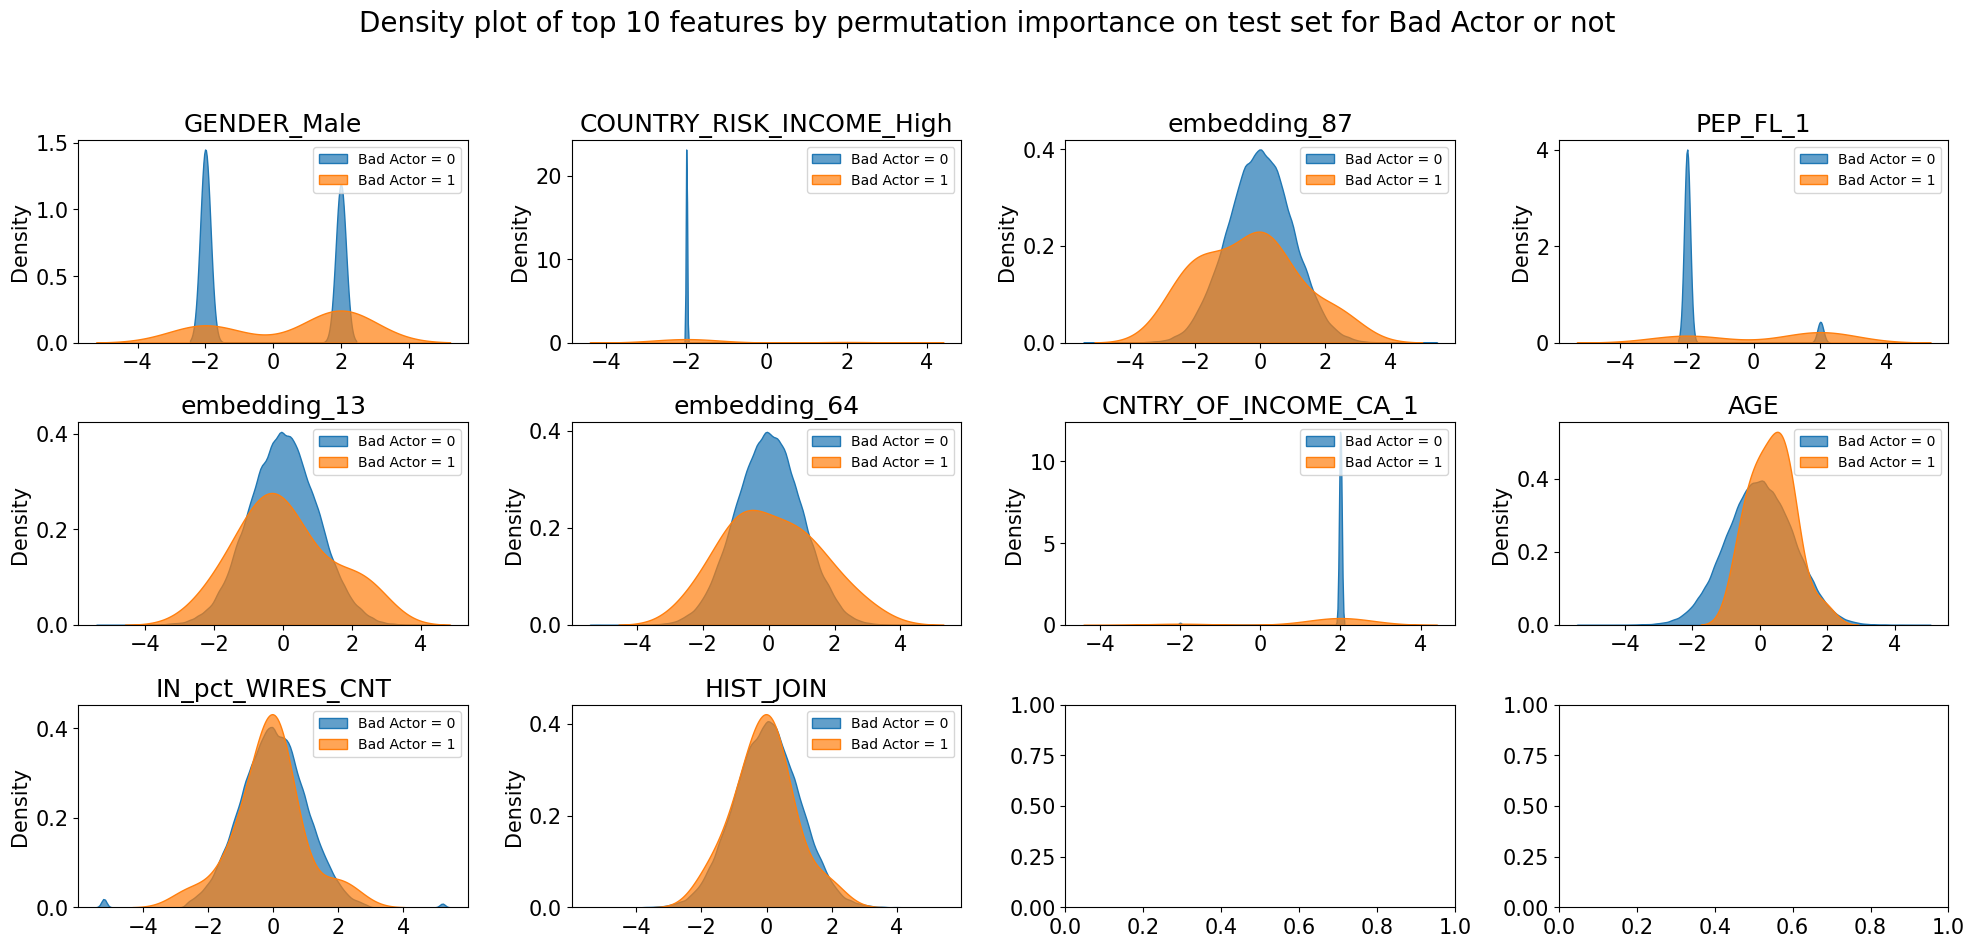

In [ ]:
# Univariate density plot by bad_actor rating
fig, axes = plt.subplots(3,int(top_n // 3) + 1,figsize=(20,10))

norm_clean = pd.concat([
    X_test_prep,
    y_test], axis = 1)

for ax, col in zip(axes.flatten(), [x[2] for x in top_features[1]]):
  for bad_actor in sorted(y_test.unique()):
    try:
      sns.kdeplot(norm_clean.loc[norm_clean['BAD_ACTOR'] == bad_actor, col], fill=True, label=f"Bad Actor = {bad_actor}", alpha=.7, ax=ax, warn_singular=False, 
                  gridsize=200, legend = True)
    except LinAlgError:
      print(f"only 1 unique value of {norm_clean.loc[norm_clean['cluster'] == bad_actor, col].unique()[0]:0.3f} for {col} in bad_actor {bad_actor}")
  ax.set_title(col)
  ax.legend(loc = 'upper right', prop={'size': 10})
  ax.set_xlabel('')

fig.suptitle('Density plot of top 10 features by permutation importance on test set for Bad Actor or not', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Shapley values

In [ ]:
explainer = shap.Explainer(lambda x: best_model.predict_proba(x), X_test_prep.median().values.reshape(1,-1))
shap_values = explainer(pd.concat([
    X_test_prep[y_test_prep == 1], 
    X_test_prep.sample(10_000, replace=True)], axis = 0)) # sample 10k (runtime = 1 minute)

Permutation explainer: 10021it [01:13, 126.37it/s]


In [ ]:
shap_values.shape

(10020, 135, 2)

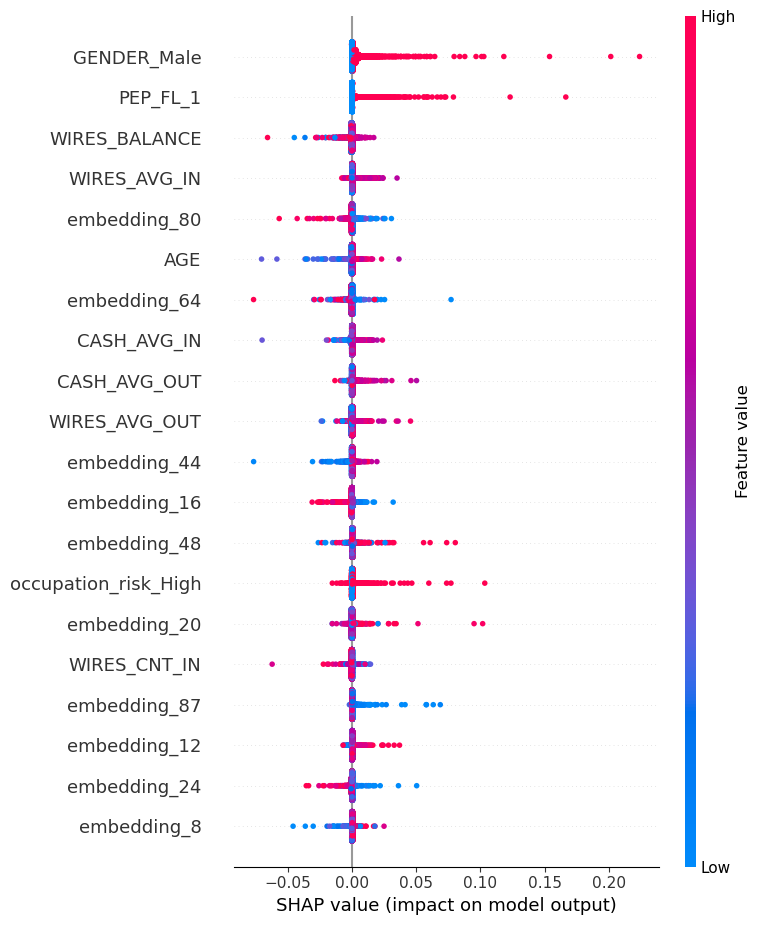

In [ ]:
# bad actor
shap.summary_plot(shap_values[:,:,1], plot_type = "dot", title="SHAP Data")

## Partial dependence plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
X_test_prep.columns[best_model[0].feature_importances_.argsort()]

Index(['embedding_55', 'embedding_67', 'embedding_5', 'embedding_79',
       'MISSING_NAME_1', 'embedding_45', 'embedding_37', 'embedding_31',
       'embedding_65', 'WIRES_OUT_CNT_VS_AVG',
       ...
       'embedding_20', 'CASH_BALANCE', 'AGE', 'embedding_8', 'CASH_AVG_IN',
       'embedding_48', 'embedding_80', 'embedding_64', 'occupation_risk_High',
       'embedding_16'],
      dtype='object', length=135)

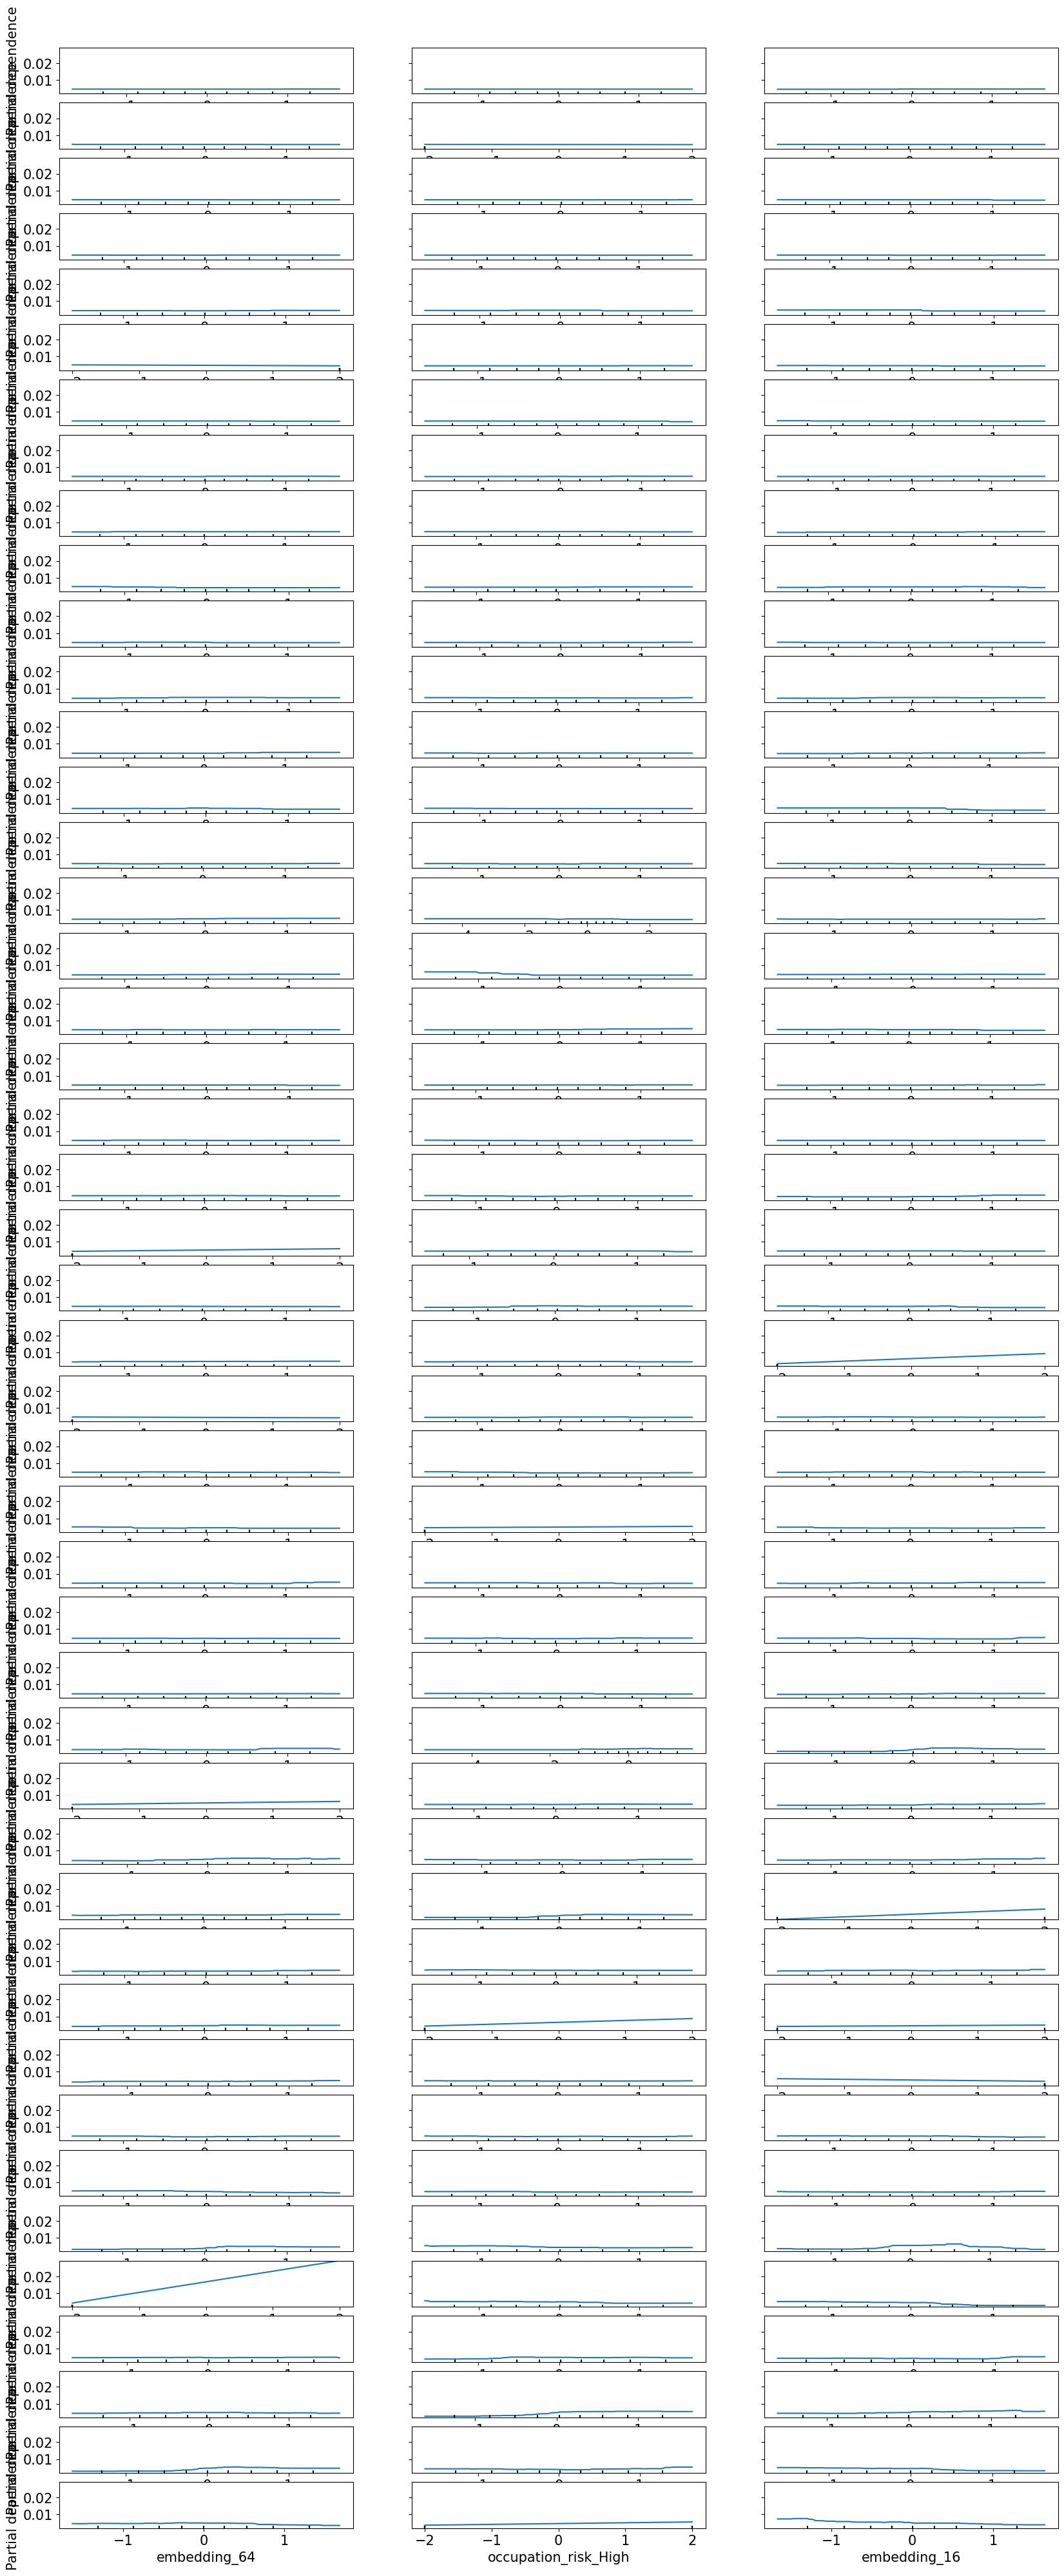

In [ ]:
# bad actor
fig, ax = plt.subplots(1,1, figsize = (20,50))
PartialDependenceDisplay.from_estimator(
    best_model, 
    pd.concat([
        X_test_prep[y_test_prep == 1], 
        X_test_prep.sample(10_000, replace=True)], axis = 0), 
    features = X_test_prep.columns[best_model[0].feature_importances_.argsort()], 
    feature_names = X_test_prep.columns, 
    target=1, 
    kind='average',
    response_method='predict_proba', 
    n_jobs=-1,
    ax=ax)

# Resources AML
- https://fintrac-canafe.canada.ca/guidance-directives/guidance-directives-eng